In [1]:
import os
import gc
import time
import json
import copy

import pickle
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cv2
from PIL import Image

import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## a. Utils Functions

In [2]:
# 用于读取图片
# 1. 读取图片：直接使用opencv获取的。
# 2. 还需要考虑图片的resize：长边固定为1024
# 3. SAM和SAM2都是使用opencv读取的图片进行inference; FastSAM使用路径提供图片即可。

def getImage_opencv(img_path, resized_width = 1024, color_space="rgb"):
    img = cv2.imread(img_path)
    if color_space == "rgb":
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width = img.shape[:2]
    resized_height = resized_width * height/width
    img = cv2.resize(img, (int(resized_width), int(resized_height)))
    return img

def getImage_pillow(img_path, resized_width = 1024):
    img = Image.open(img_path)
    img = img.convert("RGB")
    
    width, height = img.size
    resized_height = resized_width * height/width
    img = img.resize((int(resized_width), int(resized_height)))
    return img

def opencv_to_pillow(img):
    img = Image.fromarray(img)
    return img

In [3]:
# 用于展示图片和masks
def simple_show(img, size = (4,3)):
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.show()

def show_masks(used_img, masks, borders = True, show_img = True, show_mask = True, size=(8,6)):
    np.random.seed(3)
    plt.figure(figsize=size)
    if show_img:
        plt.imshow(used_img)

    if show_mask:
        if len(masks) == 0:
            return

        ax = plt.gca()
        # 打开或关闭图形的自动缩放功能。
        # 当自动缩放功能开启时，图形会根据数据自动调整坐标轴的范围，以确保所有数据点都能够适应在图形中显示。
        ax.set_autoscale_on(False) 

        height, width = used_img.shape[:2]
        
        img = np.ones((height, width, 4))
        img[:,:,3] = 0

        for r in masks:
            m = r["segmentation"]
            color_mask = np.concatenate([np.random.random(3), [0.5]])
            img[m] = color_mask
            if borders:
                contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
                cv2.drawContours(img, contours, -1, (1, 0, 0, 0.5), thickness=2)
        ax.imshow(img)

def show_def_masks(
    used_img, sorted_masks, mask = None, maskIDs = None, 
    drawBbox=True, 
    isDownload=False, downloadPath = "./results/testImgs/test.jpg",
    tags=None, tagIDs = None):

    img_opencv = cv2.cvtColor(used_img, cv2.COLOR_RGB2BGR)
    
    np.random.seed(3)
    alpha = 0.4
    
    # 这个函数可以接受两种不同的masks：(1) 直接输入一个mask (2) 输入一串masksID
    masks_list = []
    if mask is not None:
        masks_list.append(mask)
    elif maskIDs is not None:
        masks_list = [sorted_masks[i]["segmentation"] for i in maskIDs]

    overlay = np.zeros_like(img_opencv)
    filter_img = np.zeros_like(img_opencv)

    for i, m in enumerate(masks_list):
        mask_rgb = np.zeros_like(img_opencv)
        mask_rgb[m] = np.random.randint(0,256,size=3) # 生成一个rgb颜色
        overlay += mask_rgb # 获取颜色块
        filter_img[m] = img_opencv[m]


    output = cv2.addWeighted(filter_img, 1-alpha, overlay, alpha, 0)

    if isDownload:
        cv2.imwrite(downloadPath, output)

    # 下面是展示图片的部分
    plt.figure(figsize=(8,6))
    if maskIDs is not None and drawBbox:
        for i, idx in enumerate(maskIDs):
            x, y, w, h = sorted_masks[idx]["bbox"]
            rect = patches.Rectangle((x,y),w,h,linewidth = 1, edgecolor = "r", facecolor="none")
            ax = plt.gca()
            ax.add_patch(rect)
            ax.text(x+w,y+h,str(idx),ha="right",va="bottom",color="white",fontsize=7)

            if tagIDs is not None:
                if idx in tagIDs:
                    t = tags[i]
                    bbox_props = dict(boxstyle="square,pad=0.3", facecolor="black", edgecolor="black")
                    ax.text(x,y,t,ha="left",va="top",color="lime",bbox = bbox_props,fontsize=6,fontweight='bold')

    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    show_output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    plt.imshow(show_output)
    plt.show()

In [4]:
# 用于输出masks
def getMaskImage(img_opencv, masks, sortedMaskID, maskTag=True):
    img = cv2.cvtColor(img_opencv, cv2.COLOR_RGB2BGR)
    
    m = masks[sortedMaskID]
    x = int(masks[sortedMaskID]["bbox"][0])
    y = int(masks[sortedMaskID]["bbox"][1])
    w = int(masks[sortedMaskID]["bbox"][2])
    h = int(masks[sortedMaskID]["bbox"][3])

    img_m = np.zeros_like(img)
    color_mask = np.array([255,255,255], dtype=np.uint8)
    img_m[m["segmentation"]] = color_mask # 制作掩码
    masked_image = cv2.bitwise_and(img, img_m) # 通过掩码获取图片彩色的部分
    
    if maskTag:
        processed_roi = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
        roi_image = processed_roi[y:y+h,x:x+w]
        roi_image[np.where((roi_image == [0, 0, 0]).all(axis=2))] = [255, 255, 255]
        return roi_image
    else:
        roi_image = img[y:y+h,x:x+w] # 如果需要masked之后的图片，可以使用processed_roi[y:y+h,x:x+w]
        roi_image = cv2.cvtColor(roi_image, cv2.COLOR_BGR2RGB)
        roi_image[np.where((roi_image == [0, 0, 0]).all(axis=2))] = [255, 255, 255]
        return roi_image

In [5]:
# 常见的坐标转换函数
def xyxy_to_xywh(bbox):
    x_min = bbox[0]
    y_min = bbox[1]
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    return [x_min, y_min, w, h]

def xyxyn_to_xywh(bbox, width, height):
    x_min = int(bbox[0] * width)
    y_min = int(bbox[1] * height)
    w = int((bbox[2] - bbox[0]) * width)
    h = int((bbox[3] - bbox[1]) * height)
    return [x_min, y_min, w, h]

def get_bbox_xyxy(bbox):
    x_min = int(bbox[0])
    y_min = int(bbox[1])
    x_max = int(bbox[0] + bbox[2])
    y_max = int(bbox[1] + bbox[3])
    return [x_min, y_min, x_max, y_max]

def get_bbox_xywh(bbox):
    x_min = int(bbox[0])
    y_min = int(bbox[1])
    w = int(bbox[2] - bbox[0])
    h = int(bbox[3] - bbox[1])
    return [x_min, y_min, w, h]

def get_box_mask(bbox,segmentation):
    bbox_xyxy = get_bbox_xyxy(bbox)
    box_mask = np.zeros_like(segmentation,dtype=bool)# 注：segmentation的mask的形状是(h,w)
    box_mask[bbox_xyxy[1]:bbox_xyxy[3]+1,bbox_xyxy[0]:bbox_xyxy[2]+1] = True
    return box_mask

def is_surrounded(outer_bbox,inner_bbox): # 好像没啥用，hhhh
    outer_bbox = get_bbox_xyxy(outer_bbox)
    inner_bbox = get_bbox_xyxy(inner_bbox)
    return (
        outer_bbox[0] <= inner_bbox[0] and
        outer_bbox[1] <= inner_bbox[1] and
        outer_bbox[2] >= inner_bbox[2] and
        outer_bbox[3] >= inner_bbox[3]
    )

def get_segMask_ratio(sorted_masks, id1, id2):
    seg_mask_1 = sorted_masks[id1]["segmentation"] # 小
    seg_mask_2 = sorted_masks[id2]["segmentation"] # 大

    seg_its = seg_mask_1 & seg_mask_2
    seg_area_1 = np.sum(seg_mask_1)
    seg_area_its = np.sum(seg_its)
    seg_ratio = seg_area_its / seg_area_1
    return seg_ratio

def get_boxMask_ratio(sorted_masks, id1, id2):
    box_mask_1 = get_box_mask(sorted_masks[id1]["bbox"], sorted_masks[id1]["segmentation"]) #小
    box_mask_2 = get_box_mask(sorted_masks[id2]["bbox"], sorted_masks[id2]["segmentation"]) #大

    box_its = box_mask_1 & box_mask_2
    box_area_1 = np.sum(box_mask_1)
    box_area_its = np.sum(box_its)
    box_ratio = box_area_its / box_area_1
    return box_ratio

## b. SAM model 定义

In [6]:
# SAM
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
# SAM2
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
# FastSAM
from ultralytics.models.fastsam import FastSAMPredictor

In [7]:
def sam_model(img_opencv, device, sam_name = "vit_h"):
    # 只测试：vit_h (其他的模型效果一般)
    np.random.seed(3)
    sam_model_list = {
        "vit_h":"./weights/sam_models/sam/sam_vit_h_4b8939.pth",
        "vit_l":"./weights/sam_models/sam/sam_vit_l_0b3195.pth",
        "vit_b":"./weights/sam_models/sam/sam_vit_b_01ec64.pth",
    }

    sam = sam_model_registry[sam_name](checkpoint=sam_model_list[sam_name])
    sam.to(device = device)

    mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=64,
        pred_iou_thresh= 0.915,#0.92, 
        stability_score_thresh=0.65, # 能够更大程度地对整个画面进行分割(约束更加松弛了)
        crop_n_layers=1,
        crop_n_points_downscale_factor=2,
        min_mask_region_area=100.0
    )

    starttime = time.time()
    masks = mask_generator.generate(img_opencv)
    endtime = time.time()

    sorted_masks = sorted(masks,key=(lambda x:x["area"]), reverse=True)

    del sam
    del mask_generator
    del masks
    torch.cuda.empty_cache()
    gc.collect()
    
    return {"run_time":endtime - starttime, "sorted_masks":sorted_masks, "img_opencv":img_opencv}

In [8]:
def sam2_model(img_opencv, device, sam_name="hiera_l"):
    # 只测试：hiera_l 和 hiera_b(其他的模型效果一般)
    sam2_model_list = {
        "hiera_b":"./weights/sam_models/sam2.1/sam2.1_hiera_base_plus.pt",
        "hiera_l":"./weights/sam_models/sam2.1/sam2.1_hiera_large.pt",
        "hiera_s":"./weights/sam_models/sam2.1/sam2.1_hiera_small.pt",
        "hiera_t":"./weights/sam_models/sam2.1/sam2.1_hiera_tiny.pt"
    }
    
    sam2_config_list = {
        "hiera_b":"configs/sam2.1/sam2.1_hiera_b+.yaml",
        "hiera_l":"configs/sam2.1/sam2.1_hiera_l.yaml",
        "hiera_s":"configs/sam2.1/sam2.1_hiera_s.yaml",
        "hiera_t":"configs/sam2.1/sam2.1_hiera_t.yaml"
    }

    sam2 = build_sam2(
        sam2_config_list[sam_name], 
        sam2_model_list[sam_name], 
        device=device, 
        apply_postprocessing=False
    )

    mask_generator2 = SAM2AutomaticMaskGenerator(
        model=sam2,
        points_per_side=64,
        points_per_batch=64,
        pred_iou_thresh=0.80, # 0.86 # 高于此阈值的掩码会被保留，低于的会被过滤掉。
        stability_score_thresh=0.72, # 
        crop_n_layers=1,
        crop_n_points_downscale_factor=2,
        min_mask_region_area=100.0,
        # use_m2m=True,
    )

    starttime = time.time()
    masks = mask_generator2.generate(img_opencv)
    endtime = time.time()

    sorted_masks = sorted(masks,key=(lambda x:x["area"]), reverse=True)

    del sam2
    del mask_generator2
    del masks
    torch.cuda.empty_cache()
    gc.collect()

    return {"run_time":endtime - starttime, "sorted_masks":sorted_masks, "img_opencv":img_opencv}

In [9]:
def fastsam_model(img_path, device, sam_name="fastsam_x"):
    # 只测试：fastsam_x(fastsam_s效果一般)
    fastsam_model_list = {
        "fastsam_x":"./weights/sam_models/fastsam/FastSAM-x.pt",
        "fastsam_s":"./weights/sam_models/fastsam/FastSAM-s.pt"
    }

    overrides = dict(
        task="segment", 
        mode="predict", 
        model=fastsam_model_list[sam_name], 
        save=False,
        device = device,
        imgsz=1024,
        conf=0.30, # 可以控制这个数值，来减少质量很低的masks
        iou=0.9,
        crop_fraction=0.8,
        verbose=False
    )

    fastsam_model = FastSAMPredictor(overrides=overrides)
    everything_results = fastsam_model(source=img_path)

    inference_time = everything_results[0].speed['inference']/1000
    masks = everything_results[0].masks.data.cpu().numpy()
    height, width = masks[0].shape
    bboxes = everything_results[0].boxes.xyxyn.cpu().numpy()
    bboxes = np.array([xyxyn_to_xywh(b,width,height) for b in bboxes])
    conf = everything_results[0].boxes.conf.cpu().numpy()

    organized_data = []
    for b,c,m in zip(bboxes,conf, masks):
        organized_data.append({
                "segmentation":m.astype(bool),
                "area":m.astype(bool).sum(),
                "bbox":b,
                "conf":c
            })
    
    sorted_masks = sorted_masks = sorted(organized_data,key=(lambda x:x["area"]), reverse=True)

    img_opencv = cv2.imread(img_path)
    img_opencv = cv2.cvtColor(img_opencv, cv2.COLOR_BGR2RGB)
    img_opencv = cv2.resize(img_opencv, (int(width), int(height)))

    del fastsam_model
    del everything_results
    torch.cuda.empty_cache()
    gc.collect()

    return {"run_time":inference_time, "sorted_masks":sorted_masks, "img_opencv":img_opencv}

## b.1 分割图片

In [21]:
# sam_funcs = {
#     # "sam":sam_model,
#     # "sam2":sam2_model,
#     "fastsam":fastsam_model
# }

# sam_folder = {
#     "sam":"1. sam_masks",
#     "sam2":"2. sam2_masks",
#     "fastsam":"3. fastsam_masks"
# }

# sam_models = {
#     "sam":"vit_h",
#     "sam2":"hiera_l",
#     "fastsam":"fastsam_x"
# }

# time_log = {
#     "sam":{},
#     "sam2":{},
#     "fastsam":{}
# }

# start_point = 1
# end_point = 126

# ss = time.time()
# for k,v in sam_funcs.items():
#     print(f"{k} model Running:")
#     for img_id in range(start_point,end_point+1):
#         # 定义输出文件夹
#         mask_path = f"./results/{sam_folder[k]}/mask_folder/masked_region_{img_id}/"
#         if not os.path.exists(mask_path):
#             os.makedirs(mask_path)
#         pkl_path = f"./results/{sam_folder[k]}/pkl_info/{img_id}.pkl"

#         # 定义读取的图片
#         img_path = f"./selected images/{img_id}.jpg"
#         img_pillow = getImage_pillow(img_path = img_path, resized_width = 1024)
#         img_opencv = getImage_opencv(img_path = img_path, resized_width = 1024, color_space="rgb")
        
#         if k == "sam":
#             results = v(img_opencv=img_opencv, device=device, sam_name = sam_models[k])
#         elif k == "sam2":
#             results = v(img_opencv=img_opencv, device=device, sam_name = sam_models[k])
#         elif k == "fastsam":
#             results = v(img_path=img_path, device=device, sam_name = sam_models[k])

#         run_time = results['run_time']
#         sorted_masks = results['sorted_masks']
#         used_img = results['img_opencv']
#         print(f"----> Image: {img_id}  Running time: {run_time}s")
        
#         time_log[k][img_id] = run_time
#         with open(pkl_path, "wb") as fp:
#             pickle.dump(results, fp)

#         for i in range(len(sorted_masks)):
#             if sorted_masks[i]["area"] < 20:
#                 continue
#             subregion = getMaskImage(used_img, masks=sorted_masks, sortedMaskID=i, maskTag= True)
#             subimage_pillow = opencv_to_pillow(subregion)
#             subimage_pillow.save(mask_path+f"{i}_t.jpg")
#         time.sleep(2)
#     print("-------------------------------------------------------")
# ee = time.time()
# print(f"Total Time: {ee - ss} s")

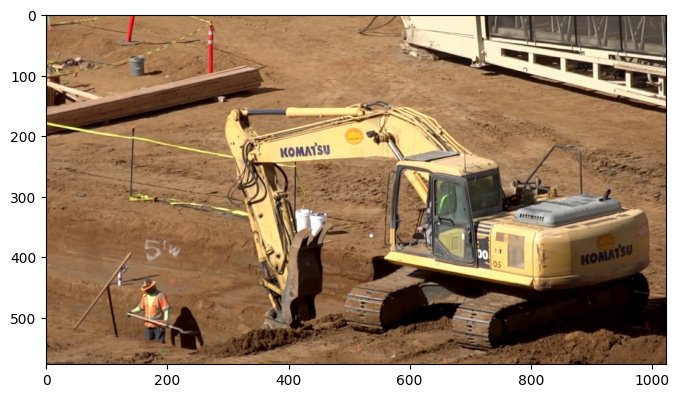

In [11]:
# 定义图片
img_id = 105
img_path = f"./selected images/{img_id}.jpg"

img_pillow = getImage_pillow(img_path = img_path, resized_width = 1024)
img_opencv = getImage_opencv(img_path = img_path, resized_width = 1024, color_space="rgb")

simple_show(img_opencv, size=(8,6))

In [14]:
# 分割图片
# sam: vit_h
# sam2: hiera_l, hiera_b
# fastsam: fastsam_x
with torch.no_grad():
    results = sam2_model(img_opencv=img_opencv, device=device, sam_name = "hiera_l")
run_time = results['run_time']
sorted_masks = results['sorted_masks']
used_img = results['img_opencv']
print(f"Function Running Time: {results['run_time']} s")

Function Running Time: 16.937414407730103 s


In [22]:
# 1. 将数据存储到本地
pkl_root = f"./results/pkl_info/{img_id}.pkl"
with open(pkl_root, "wb") as fp:
    pickle.dump({
        "run_time": results['run_time'],
        "sorted_masks":results['sorted_masks'],
        "img_opencv":results['img_opencv']
    },fp)

# 2. 将mask保存到本地
file_root = f"./results/masked_region_{img_id}/"
if not os.path.exists(file_root):
    os.makedirs(file_root)

for i in range(len(sorted_masks)):
    subregion = getMaskImage(used_img, masks=sorted_masks, sortedMaskID=i, maskTag= True)
    subimage_pillow = opencv_to_pillow(subregion)
    subimage_pillow.save(file_root+f"{i}_t.jpg")

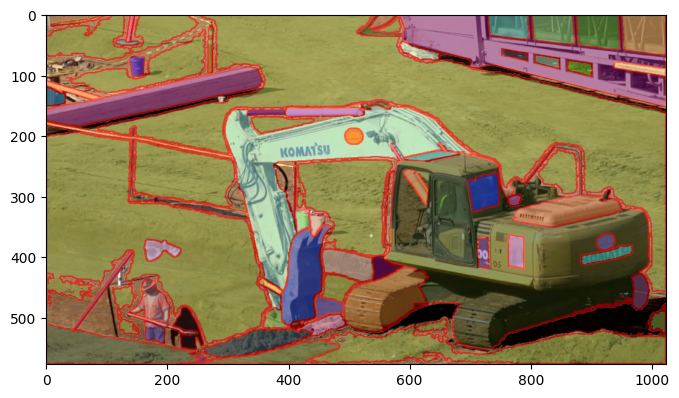

In [15]:
# 展示各个masks
show_masks(used_img=used_img, masks=sorted_masks, show_mask=True)

## c.1 构造includeTree (函数方法)

#### c.1 构造includeTree和过滤函数

In [6]:
def get_includeTree(sorted_masks):
    
    total_len = len(sorted_masks)
    
    includeTree = {
        i:{"direct_parent":None, "indirect_parent":None,"children_seg":[],"children_box":[]} 
        for i in range(total_len)
    }

    starttime = time.time()
    for k_1 in tqdm(range(total_len-1,-1,-1)):
        for k_2 in range(k_1-1,-1,-1): # 从小到大进行mask的判断
    
            # 1. 首先判断masks之间的ratio.
            seg_ratio = get_segMask_ratio(sorted_masks,k_1,k_2) 
    
            # 1.1 如果两个masks之间的重合部分太大，说明小mask(k_1)是大mask(k_2)的一部分。
            # 此时：大mask(k_2) --direct parent--> 小mask(k_1)
            #       小mask(k_1) --child seg[属于大mask]--> 大mask的
            if seg_ratio > 0.45: # 说明 k_1 属于 k_2 mask中的一部分 # 一开始是0.2
                if includeTree[k_1]["direct_parent"] == None:
                    includeTree[k_1]["direct_parent"] = k_2
                    includeTree[k_2]["children_seg"].append(k_1)
                    
                    # if includeTree[k_1]["indirect_parent"] != None:
                    #     # 加入原本小的mask(k_1)的indirect_parent不为空。
                    #     # 即原本与其他mask组合在一起的，但是发现这个mask是其他mask的一部分。则将这部分mask还给别人。
                    #     indirect_parent = includeTree[k_1]["indirect_parent"]
                    #     includeTree[indirect_parent]["children_box"].remove(k_1)
                    
                    # includeTree[k_1]["indirect_parent"] = None
                    # # break
                    
                elif includeTree[k_1]["direct_parent"] != None:
                    direct_parent = includeTree[k_1]["direct_parent"]
                    p_k1_maskR = get_segMask_ratio(sorted_masks, k_1, direct_parent)
                    if seg_ratio > p_k1_maskR:
                        includeTree[direct_parent]["children_seg"].remove(k_1)
                        includeTree[k_1]["direct_parent"] = k_2
                        includeTree[k_2]["children_seg"].append(k_1)
                    
            elif seg_ratio <= 0.45: # 假如 k_1 不属于 k_2 mask中的一部分，判断k_1是否属于k_2的范围内
                # 2. 然后判断bbox之间的ratio。
                box_ratio = get_boxMask_ratio(sorted_masks,k_1,k_2)
    
                # 2.1 如果一个大mask的bbox包含着小mask的bbox，但是mask ratio又很小。
                # 这说明，小mask并不是大mask的一部分；只是小mask恰巧在大mask中。
                # 此时：大mask(k_2) --indirect parent--> 小mask(k_1)
                #       小mask(k_1) --child box[不属于大mask,但在大mask内]--> 大mask的
                if box_ratio > 0.7: # 说明 k_1 在 k_2 的范围内：
                    if includeTree[k_1]["indirect_parent"] == None:
                        includeTree[k_1]["indirect_parent"] = k_2
                        includeTree[k_2]["children_box"].append(k_1)
    
                    # 如果当前小mask的bbox属于另外一个大mask的时候，判断之前的大mask与当前的大mask与小mask之间的重合程度。
                    elif includeTree[k_1]["indirect_parent"] != None:
                        indirect_parent = includeTree[k_1]["indirect_parent"]
                        ip_k1_maskR = get_segMask_ratio(sorted_masks, k_1, indirect_parent)
                        if ip_k1_maskR > box_ratio:
                            continue
                        
                        box_ratio_indirect_parent = get_boxMask_ratio(sorted_masks,k_1,indirect_parent)
                        if box_ratio >= box_ratio_indirect_parent:
                            includeTree[indirect_parent]["children_box"].remove(k_1)
                            includeTree[k_1]["indirect_parent"] = k_2
                            includeTree[k_2]["children_box"].append(k_1)
                    continue
    
        if includeTree[k_1]["direct_parent"] != None and includeTree[k_1]["indirect_parent"] != None:
            indirect_parent = includeTree[k_1]["indirect_parent"]
            includeTree[indirect_parent]["children_box"].remove(k_1)
            includeTree[k_1]["indirect_parent"] = None
        
    endtime = time.time()
    return {"includeTree":includeTree, "run_time":endtime-starttime}

In [25661]:
def get_includeTree_t2(sorted_masks):
    total_len = len(sorted_masks)

    includeTree = {
        i:{"direct_parent":None, "indirect_parent":None,"children_seg":[],"children_box":[]} 
        for i in range(total_len)
    }
    starttime = time.time()
    for k_1 in tqdm(range(total_len-1,-1,-1)):
        for k_2 in range(k_1-1,-1,-1): 
            seg_ratio = get_segMask_ratio(sorted_masks, k_1, k_2)
    
            # direct parent
            if seg_ratio > 0.475: # 两者像素重叠 # 一开始是0.2
                if includeTree[k_1]["direct_parent"] == None and includeTree[k_1]["indirect_parent"] == None:
                    includeTree[k_1]["direct_parent"] = k_2
                    includeTree[k_2]["children_seg"].append(k_1)
                elif includeTree[k_1]["direct_parent"] == None and includeTree[k_1]["indirect_parent"] != None:
                    indir_parent = includeTree[k_1]["indirect_parent"]
                    includeTree[k_1]["direct_parent"] = k_2
                    includeTree[k_1]["indirect_parent"] = None
                    includeTree[k_2]["children_seg"].append(k_1)
                    includeTree[indir_parent]["children_box"].remove(k_1)
                elif includeTree[k_1]["direct_parent"] != None:
                    dir_parent = includeTree[k_1]["direct_parent"]
                    c_seg_ratio = get_segMask_ratio(sorted_masks, k_1, dir_parent)
                    mul_seg_ratio = get_segMask_ratio(sorted_masks, dir_parent, k_2)
    
                    if mul_seg_ratio >0.5:
                        includeTree[k_1]["direct_parent"] = k_2
                        includeTree[k_2]["children_seg"].append(k_1)
                        includeTree[dir_parent]["children_seg"].remove(k_1)
                    elif mul_seg_ratio<=0.5 and seg_ratio > c_seg_ratio:
                        includeTree[k_1]["direct_parent"] = k_2
                        includeTree[k_2]["children_seg"].append(k_1)
                        includeTree[dir_parent]["children_seg"].remove(k_1)
    
            elif seg_ratio <= 0.475: # 两者像素不重叠；因此，判断bbox的重叠情况 # 一开始是0.2
                box_ratio = get_boxMask_ratio(sorted_masks,k_1,k_2)
                
                # indirect parent
                if box_ratio >= 0.5: # 说明k_1在k_2内，只是像素不重叠
                    if includeTree[k_1]["direct_parent"] == None and includeTree[k_1]["indirect_parent"] == None:
                        includeTree[k_1]["indirect_parent"] = k_2
                        includeTree[k_2]["children_box"].append(k_1)
                    elif includeTree[k_1]["direct_parent"] == None and includeTree[k_1]["indirect_parent"] != None:
                        indir_parent = includeTree[k_1]["indirect_parent"]
                        c_box_ratio = get_boxMask_ratio(sorted_masks,k_1,indir_parent)
    
                        mul_seg_ratio = get_segMask_ratio(sorted_masks,indir_parent,k_2)
                        if mul_seg_ratio > 0.5:
                            includeTree[k_1]["indirect_parent"] = k_2
                            includeTree[k_2]["children_box"].append(k_1)
                            includeTree[indir_parent]["children_box"].remove(k_1)
                        
                        elif mul_seg_ratio <= 0.5 and box_ratio > c_box_ratio:
                            includeTree[k_1]["indirect_parent"] = k_2
                            includeTree[k_2]["children_box"].append(k_1)
                            includeTree[indir_parent]["children_box"].remove(k_1)
                            
                    elif includeTree[k_1]["direct_parent"] != None:
                        continue
                    
                elif box_ratio < 0.5: # 说明k_1和k_2是互相分离的，两者不存在关系
                    continue
                    
        if includeTree[k_1]["direct_parent"] != None and includeTree[k_1]["indirect_parent"] != None:
            indirect_parent = includeTree[k_1]["indirect_parent"]
            includeTree[indirect_parent]["children_box"].remove(k_1)
            includeTree[k_1]["indirect_parent"] = None
    
    endtime = time.time()
    return {"includeTree":includeTree, "run_time":endtime-starttime}

In [24707]:
def filter_includeTree(includeTree, feature_area = 2048):
    ancestorNodes = {
        k:v for k,v in includeTree.items() if v["direct_parent"] == None and v["indirect_parent"]==None
    }

    # 1. filter 祖父节点中mask_area比较小的节点
    keep_set = []
    filter_set = []
    
    for k,v in ancestorNodes.items():
        area = sorted_masks[k]["area"]
        w = sorted_masks[k]["bbox"][2]
        h = sorted_masks[k]["bbox"][3]
        if area > feature_area or w*h > feature_area:
            keep_set.append(k)
        else:
            filter_set.append(k)

    # 2. filter 祖父节点中的child_box 和 child_seg 比较小的节点
    updated_tree = {
        i:{
            "children_seg":{"keep":None, "filter":None},
            "children_box":{"keep":None, "filter":None}
        } for i in keep_set
    }

    # 2.1 filter祖父节点中的child_seg
    for pn in keep_set:
        children_seg = includeTree[pn]["children_seg"]
        keep_list = []
        filter_list = []
        for n in children_seg:
            area = sorted_masks[n]["area"]
            w = sorted_masks[n]["bbox"][2]
            h = sorted_masks[n]["bbox"][3]
            if area > feature_area or h*w > feature_area:
                keep_list.append(n)
            else:
                filter_list.append(n)
        updated_tree[pn]["children_seg"]["keep"] = keep_list
        updated_tree[pn]["children_seg"]["filter"] = filter_list

    # 2.2 filter祖父节点中的child_box
    for pn in keep_set:
        children_seg = includeTree[pn]["children_box"]
        keep_list = []
        filter_list = []
        for n in children_seg:
            area = sorted_masks[n]["area"]
            w = sorted_masks[n]["bbox"][2]
            h = sorted_masks[n]["bbox"][3]
            if h*w > feature_area and area > feature_area:
                keep_list.append(n)
            else:
                filter_list.append(n)
        updated_tree[pn]["children_box"]["keep"] = keep_list
        updated_tree[pn]["children_box"]["filter"] = filter_list

    
    children_box = []
    for k,v in updated_tree.items():
        children_box.extend(v["children_box"]["keep"])
    children_box = np.unique(np.array(children_box))
    
    return {
        "updated_tree":updated_tree,
        "keep_set":keep_set,
        "children_box":children_box
    }

In [19792]:
def filter_includeTree_t2(includeTree, feature_area = 2048):
    ancestorNodes = {k:v for k,v in includeTree.items() if v["direct_parent"] == None and v["indirect_parent"]==None}
    
    ancestor_keep_set = []
    ancestor_filter_set = []
    
    starttime = time.time()
    for k,v in ancestorNodes.items():
        area = sorted_masks[k]["area"]
        w = sorted_masks[k]["bbox"][2]
        h = sorted_masks[k]["bbox"][3]
        if area > feature_area and w*h > feature_area:
            ancestor_keep_set.append(k)
        else:
            ancestor_filter_set.append(k)

    # 在ancestor_keep_set中，filter掉很小的object
    updated_tree = {
        i:{
            "children_seg":{"keep":None, "filter":None},
            "children_box":{"keep":None, "filter":None},
            "children_seg_box":[]
        } for i in ancestor_keep_set
    }

    # 对于ancestor_keep_set中的children_seg。在filter掉很小的object之后，需要获取他们的children_box
    for anc in ancestor_keep_set:
        children_seg = includeTree[anc]["children_seg"]
        # 第一步：filter掉children_seg中比较小的部分
        keep_seg = []
        filter_seg = []
        children_seg_box_list = []
        keep_seg_box = []
        
        for n in children_seg:
            area = sorted_masks[n]["area"]
            w = sorted_masks[n]["bbox"][2]
            h = sorted_masks[n]["bbox"][3]
            if area > feature_area or h*w > feature_area:
                keep_seg.append(n)
            else:
                filter_seg.append(n)
            
            # 第二步：将children_seg中的children_box提取出来
            children_seg_box_list.extend(includeTree[n]["children_box"])
            
        children_seg_box_list = list(set(children_seg_box_list))
        for cb in children_seg_box_list:
            area = sorted_masks[cb]["area"]
            w = sorted_masks[cb]["bbox"][2]
            h = sorted_masks[cb]["bbox"][3]
            if area > feature_area or h*w > feature_area:
                keep_seg_box.append(cb)
        
        updated_tree[anc]["children_seg"]["keep"] = keep_seg
        updated_tree[anc]["children_seg"]["filter"] = filter_seg 
        updated_tree[anc]["children_seg_box"].extend(keep_seg_box)

    # for anc in ancestor_keep_set:
    #     children_box = includeTree[anc]["children_box"]
    #     # 第一步：filter掉children_seg中比较小的部分
    #     keep_box = []
    #     filter_box = []
    #     children_box_box_list = []
    #     keep_box_box = []
        
    #     for n in children_box:
    #         area = sorted_masks[n]["area"]
    #         w = sorted_masks[n]["bbox"][2]
    #         h = sorted_masks[n]["bbox"][3]
    #         if h*w > feature_area and area > feature_area:
    #             keep_box.append(n)
    #         else:
    #             filter_box.append(n)


    for anc in ancestor_keep_set:
        pretain_list = []
        oper_list = [anc]
        while len(oper_list) != 0:
            tag_num = oper_list.pop()
            children_box = includeTree[tag_num]["children_box"]
            oper_list.extend(children_box)
            pretain_list.extend(children_box)
    
        keep_box = []
        filter_box = []
        for n in pretain_list:
            area = sorted_masks[n]["area"]
            w = sorted_masks[n]["bbox"][2]
            h = sorted_masks[n]["bbox"][3]
            if h*w > feature_area and area > feature_area:
                keep_box.append(n)
            else:
                filter_box.append(n)
            
        updated_tree[anc]["children_box"]["keep"] = keep_box
        updated_tree[anc]["children_box"]["filter"] = filter_box

    ancestors_node = []
    children_box_node = []
    for k, v in updated_tree.items():
        ancestors_node.append(k)
        childbox = v["children_box"]["keep"]
        childsegbox = v["children_seg_box"]
        children_box_node.extend(childbox)
        children_box_node.extend(childsegbox)
    
    children_box_node = list(set(children_box_node))
    endtime = time.time()
    return {
        "updated_tree":updated_tree,
        "ancestors_node":ancestors_node,
        "children_box_node":children_box_node,
        "run_time":endtime-starttime
    }

In [1279]:
ancestor_keep_set = [0]
feature_area = 1000
for anc in ancestor_keep_set:
    pretain_list = []
    oper_list = [anc]
    while len(oper_list) != 0:
        tag_num = oper_list.pop()
        children_box = includeTree[tag_num]["children_box"]
        oper_list.extend(children_box)
        pretain_list.extend(children_box)

    keep_box = []
    filter_box = []
    for n in pretain_list:
        area = sorted_masks[n]["area"]
        w = sorted_masks[n]["bbox"][2]
        h = sorted_masks[n]["bbox"][3]
        if h*w > feature_area and area > feature_area:
            keep_box.append(n)
        else:
            filter_box.append(n)

#### c.2 构造每个includeTree

In [16668]:
print(filter_includeTree_t2)

<function filter_includeTree_t2 at 0x0000027C07BC5A20>


In [27500]:
sam_folder = {
    "sam":"1. sam_masks",
    "sam2":"2. sam2_masks",
    "fastsam":"3. fastsam_masks"
}

start_point = 18
end_point = 18
for k, v in sam_folder.items():
    for img_id in range(start_point, end_point+1):
        print(f"----> Model:{k}  Image:{img_id}")
        pkl_root = f"./results/{v}/pkl_info/{img_id}.pkl"
        with open(pkl_root, "rb") as fp:
            results = pickle.load(fp)

        sorted_masks = results['sorted_masks']
        used_img = results['img_opencv']

        results = get_includeTree_t2(sorted_masks)

        includeTree_root = f"./results/{v}/includeTree_info/{img_id}.pkl"
        with open(includeTree_root, "wb") as fp:
            pickle.dump(results, fp)
        print("  --> IncludeTree Written Successfully")
        
        includeTree = results["includeTree"]
        includeTree_runtime = results["run_time"]

        results = filter_includeTree_t2(includeTree, feature_area = 1500)
        
        keepNode_root = f"./results/{v}/keep_node_info/{img_id}.pkl"
        with open(keepNode_root, "wb") as fp:
            pickle.dump(results, fp)
        print("  --> KeepNodes Written Successfully")
        
        updated_tree = results["updated_tree"]
        ancestors_node = results["ancestors_node"]
        children_box_node = results["children_box_node"]
        filter_runtime = results["run_time"]
        time.sleep(3)

----> Model:sam  Image:18


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [00:09<00:00, 11.68it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully
----> Model:sam2  Image:18


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:02<00:00, 22.70it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully
----> Model:fastsam  Image:18


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 26.59it/s]


  --> IncludeTree Written Successfully
  --> KeepNodes Written Successfully


## c.2 构造和过滤includeTree的基本方法

In [56]:
pkl_root = f"./results/pkl_info/{img_id}.pkl"
with open(pkl_root, "rb") as fp:
    results = pickle.load(fp)

sorted_masks = results['sorted_masks']
used_img = results['img_opencv']

### c.2.1 输出includeTree

In [236]:
# 原始的includeTree代码
starttime = time.time()

total_len = len(sorted_masks)

includeTree = {
    i:{"direct_parent":None, "indirect_parent":None,"children_seg":[],"children_box":[]} 
    for i in range(total_len)
}

for k_1 in tqdm(range(total_len-1,-1,-1)):
    for k_2 in range(k_1-1,-1,-1): # 从小到大进行mask的判断

        # 1. 首先判断masks之间的ratio.
        seg_ratio = get_segMask_ratio(sorted_masks,k_1,k_2) 

        # 1.1 如果两个masks之间的重合部分太大，说明小mask(k_1)是大mask(k_2)的一部分。
        # 此时：大mask(k_2) --direct parent--> 小mask(k_1)
        #       小mask(k_1) --child seg[属于大mask]--> 大mask的
        if seg_ratio > 0.2: # 说明 k_1 属于 k_2 mask中的一部分
            if includeTree[k_1]["direct_parent"] == None:
                includeTree[k_1]["direct_parent"] = k_2
                includeTree[k_2]["children_seg"].append(k_1)
                
                # if includeTree[k_1]["indirect_parent"] != None:
                #     # 加入原本小的mask(k_1)的indirect_parent不为空。
                #     # 即原本与其他mask组合在一起的，但是发现这个mask是其他mask的一部分。则将这部分mask还给别人。
                #     indirect_parent = includeTree[k_1]["indirect_parent"]
                #     includeTree[indirect_parent]["children_box"].remove(k_1)
                
                # includeTree[k_1]["indirect_parent"] = None
                # # break
                
            elif includeTree[k_1]["direct_parent"] != None:
                direct_parent = includeTree[k_1]["direct_parent"]
                p_k1_maskR = get_segMask_ratio(sorted_masks, k_1, direct_parent)
                if seg_ratio > p_k1_maskR:
                    includeTree[direct_parent]["children_seg"].remove(k_1)
                    includeTree[k_1]["direct_parent"] = k_2
                    includeTree[k_2]["children_seg"].append(k_1)
                
        elif seg_ratio <= 0.2: # 假如 k_1 不属于 k_2 mask中的一部分，判断k_1是否属于k_2的范围内
            # 2. 然后判断bbox之间的ratio。
            box_ratio = get_boxMask_ratio(sorted_masks,k_1,k_2)

            # 2.1 如果一个大mask的bbox包含着小mask的bbox，但是mask ratio又很小。
            # 这说明，小mask并不是大mask的一部分；只是小mask恰巧在大mask中。
            # 此时：大mask(k_2) --indirect parent--> 小mask(k_1)
            #       小mask(k_1) --child box[不属于大mask,但在大mask内]--> 大mask的
            if box_ratio > 0.7: # 说明 k_1 在 k_2 的范围内：
                if includeTree[k_1]["indirect_parent"] == None:
                    includeTree[k_1]["indirect_parent"] = k_2
                    includeTree[k_2]["children_box"].append(k_1)

                # 如果当前小mask的bbox属于另外一个大mask的时候，判断之前的大mask与当前的大mask与小mask之间的重合程度。
                elif includeTree[k_1]["indirect_parent"] != None:
                    indirect_parent = includeTree[k_1]["indirect_parent"]
                    ip_k1_maskR = get_segMask_ratio(sorted_masks, k_1, indirect_parent)
                    if ip_k1_maskR > box_ratio:
                        continue
                    
                    box_ratio_indirect_parent = get_boxMask_ratio(sorted_masks,k_1,indirect_parent)
                    if box_ratio >= box_ratio_indirect_parent:
                        includeTree[indirect_parent]["children_box"].remove(k_1)
                        includeTree[k_1]["indirect_parent"] = k_2
                        includeTree[k_2]["children_box"].append(k_1)
                continue

    if includeTree[k_1]["direct_parent"] != None and includeTree[k_1]["indirect_parent"] != None:
        indirect_parent = includeTree[k_1]["indirect_parent"]
        includeTree[indirect_parent]["children_box"].remove(k_1)
        includeTree[k_1]["indirect_parent"] = None
    
endtime = time.time()
print("Function Running Time: ",endtime - starttime, "s")  

100%|████████████████████████████████████████████████████████████████████████████████| 410/410 [02:41<00:00,  2.54it/s]

Function Running Time:  161.48638796806335 s


In [237]:
includeTree_root = f"./results/includeTree_info/{img_id}.pkl"

with open(includeTree_root, "wb") as fp:
    pickle.dump(includeTree, fp)

### c.2.2 针对includeTree的实验

In [238]:
includeTree_root = f"./results/includeTree_info/{img_id}.pkl"
with open(includeTree_root, "rb") as fp:
    includeTree = pickle.load(fp)

#### (a) 查看祖父区域和它们的children_box的子区域

In [239]:
# v["direct_parent"] == None && v["indirect_parent"] == None： 这是一个重要的区域，且这块区域较大
# v["direct_parent"] == None && v["indirect_parent"] != None： 这块区域是重要区域中的独立区域
# v["direct_parent"] != None && v["indirect_parent"] != None： 这是一个区域中的子区域

# children_seg: 是大区域中，mask重叠的，子区域
# children_box: 是小区域中，mask不重叠的，子区域

test_set = [k for k, v in includeTree.items() if v["direct_parent"]==None]
print(test_set)

[0, 3, 7, 8, 12, 13, 20, 22, 30, 35, 41, 42, 45, 46, 50, 58, 59, 60, 62, 64, 66, 68, 70, 71, 91, 100, 105, 113, 133, 148, 149, 154, 157, 166, 182, 183, 187, 189, 193, 201, 204, 327, 335, 340, 359, 363, 368, 382, 391]


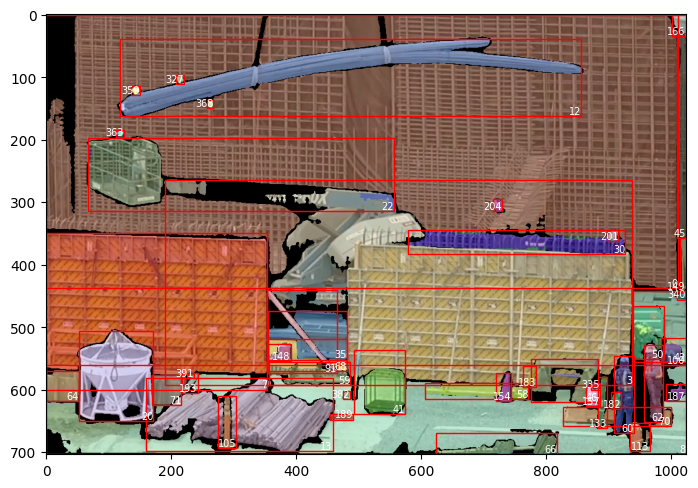

In [240]:
show_def_masks(used_img, sorted_masks, maskIDs=test_set, drawBbox=True)

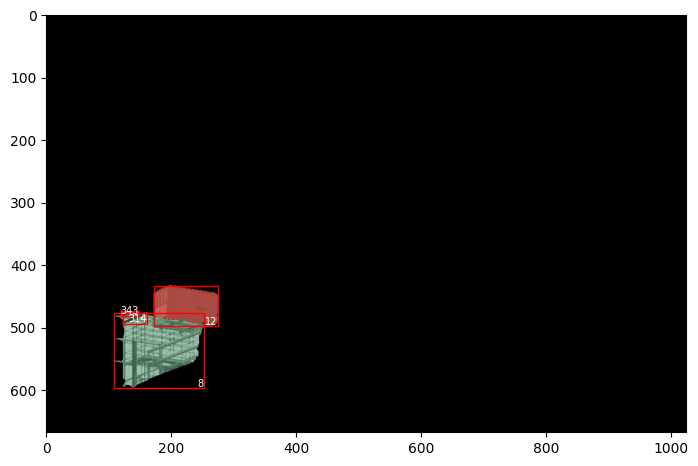

In [912]:
show_def_masks(used_img, sorted_masks, maskIDs=[343, 314, 12, 8], drawBbox=True)

#### (b) 查看某个祖父区域及其child_seg合并的mask

In [391]:
available_set = [k for k,v in includeTree.items() if v["direct_parent"]==None and v["indirect_parent"]==None]
print(available_set)

[0, 1, 2, 5, 6, 7, 8, 11, 13, 17, 20, 22, 30, 31, 32, 33, 52, 57, 60, 65, 69]


In [146]:
id =133
seg_list = [id] + includeTree[id]["children_seg"]
seg_mask = np.zeros_like(sorted_masks[id]["segmentation"],dtype=bool)
for i in seg_list:
    seg_mask = seg_mask | sorted_masks[i]["segmentation"]

In [149]:
includeTree[133]

{'direct_parent': None,
 'indirect_parent': None,
 'children_seg': [276],
 'children_box': []}

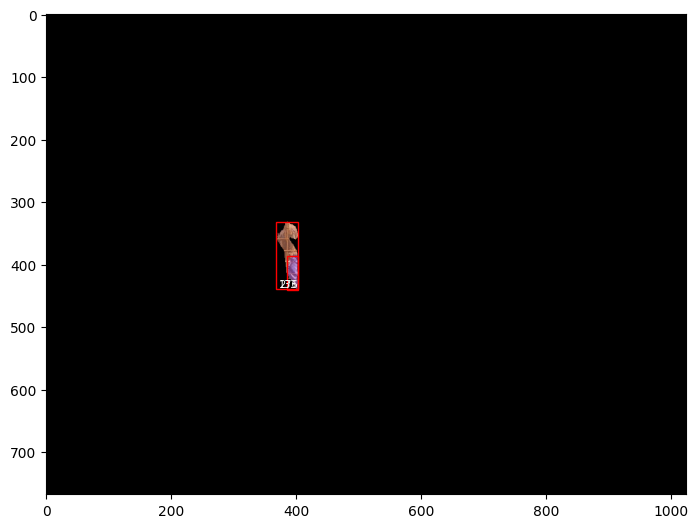

In [150]:
show_def_masks(used_img, sorted_masks, maskIDs=[133,276])

### c.3.1 过滤一些mask regions (初始方法)

In [39]:
pkl_root = f"./results/pkl_info/{img_id}.pkl"
with open(pkl_root, "rb") as fp:
    results = pickle.load(fp)

sorted_masks = results['sorted_masks']
used_img = results['img_opencv']

includeTree_root = f"./results/includeTree_info/{img_id}.pkl"
with open(includeTree_root, "rb") as fp:
    includeTree = pickle.load(fp)

需要过滤的区域有三类:  
(1) 祖父节点区域本身mask_area比较小的  
(2) 祖父节点内"children_seg"列表中，子区域的mask_area比较小的(a.占整幅图的比例小 b.占祖父节点的mask_area比例小)  
(3) 祖父节点内"children_box"列表中，子区域的mask_area比较小的 和 子区域形状比较奇怪的  

#### (1) 祖父节点区域本身mask_area比较小

In [40]:
# 尝试1：使用中值
areas = np.array([k["area"] for k in sorted_masks])
median_area = np.median(areas)
# 尝试2：使用CLIP的图片特征维度1024
feature_area = 2048

In [41]:
ancestorNodes = {k:v for k,v in includeTree.items() if v["direct_parent"] == None and v["indirect_parent"]==None}

In [42]:
keep_set = []
filter_set = []

for k,v in ancestorNodes.items():
    area = sorted_masks[k]["area"]
    w = sorted_masks[k]["bbox"][2]
    h = sorted_masks[k]["bbox"][3]
    if area > feature_area or w*h > feature_area:
        keep_set.append(k)
    else:
        filter_set.append(k)

In [43]:
keep_set

[0, 1, 2, 5, 6, 7, 8, 11, 13, 17, 20, 21, 22, 25, 30, 31, 32, 33, 52]

In [44]:
show_def_masks(used_img, sorted_masks, maskIDs=keep_set, drawBbox=True)

NameError: name 'show_def_masks' is not defined

#### (2) 祖父节点区域内children_seg列表中，子区域的mask_area比较小的
i. 占整幅画比例小的  
ii. 占祖父节点的mask_area比例小

In [45]:
# 尝试1：使用中值
areas = np.array([k["area"] for k in sorted_masks])
median_area = np.median(areas)
# 尝试2：使用CLIP的图片特征维度1024
feature_area = 2048

In [46]:
updated_tree = {
    i:{
        "children_seg":{"keep":None, "filter":None},
        "children_box":{"keep":None, "filter":None}
    } for i in keep_set
}

In [47]:
for pn in keep_set:
    children_seg = includeTree[pn]["children_seg"]
    keep_list = []
    filter_list = []
    for n in children_seg:
        area = sorted_masks[n]["area"]
        w = sorted_masks[n]["bbox"][2]
        h = sorted_masks[n]["bbox"][3]
        if area > feature_area or h*w > feature_area:
            keep_list.append(n)
        else:
            filter_list.append(n)
    updated_tree[pn]["children_seg"]["keep"] = keep_list
    updated_tree[pn]["children_seg"]["filter"] = filter_list

#### (3) 祖父节点区域内children_box列表中，子区域的mask_area比较小的

In [49]:
# 尝试1：使用中值
areas = np.array([k["area"] for k in sorted_masks])
median_area = np.median(areas)
# 尝试2：使用CLIP的图片特征维度1024
feature_area = 2048

In [54]:
for pn in keep_set:
    children_seg = includeTree[pn]["children_box"]
    keep_list = []
    filter_list = []
    for n in children_seg:
        area = sorted_masks[n]["area"]
        w = sorted_masks[n]["bbox"][2]
        h = sorted_masks[n]["bbox"][3]
        if h*w > feature_area and area > feature_area:
            keep_list.append(n)
        else:
            filter_list.append(n)
    updated_tree[pn]["children_box"]["keep"] = keep_list
    updated_tree[pn]["children_box"]["filter"] = filter_list

### c.3.2 过滤修改后的方法

In [45]:
ancestorNodes.keys()

dict_keys([0, 3, 5, 10, 46, 69, 74, 112, 185, 201])

In [49]:
ancestor_keep_set = []
ancestor_filter_set = []

for k,v in ancestorNodes.items():
    area = sorted_masks[k]["area"]
    w = sorted_masks[k]["bbox"][2]
    h = sorted_masks[k]["bbox"][3]
    if area > feature_area or w*h > feature_area:
        ancestor_keep_set.append(k)
    else:
        ancestor_filter_set.append(k)

In [50]:
# 在ancestor_keep_set中，filter掉很小的object
updated_tree = {
    i:{
        "children_seg":{"keep":None, "filter":None},
        "children_box":{"keep":None, "filter":None},
        "children_seg_box":[]
    } for i in ancestor_keep_set
}

In [51]:
# 对于ancestor_keep_set中的children_seg。在filter掉很小的object之后，需要获取他们的children_box
for anc in ancestor_keep_set:
    children_seg = includeTree[anc]["children_seg"]
    # 第一步：filter掉children_seg中比较小的部分
    keep_seg = []
    filter_seg = []
    children_seg_box_list = []
    keep_seg_box = []
    
    for n in children_seg:
        area = sorted_masks[n]["area"]
        w = sorted_masks[n]["bbox"][2]
        h = sorted_masks[n]["bbox"][3]
        if area > feature_area or h*w > feature_area:
            keep_seg.append(n)
        else:
            filter_seg.append(n)
        
        # 第二步：将children_seg中的children_box提取出来
        children_seg_box_list.extend(includeTree[n]["children_box"])
        
    children_seg_box_list = list(set(children_seg_box_list))
    for cb in children_seg_box_list:
        area = sorted_masks[cb]["area"]
        w = sorted_masks[cb]["bbox"][2]
        h = sorted_masks[cb]["bbox"][3]
        if area > feature_area or h*w > feature_area:
            keep_seg_box.append(cb)
    
    updated_tree[anc]["children_seg"]["keep"] = keep_seg
    updated_tree[anc]["children_seg"]["filter"] = filter_seg 
    updated_tree[anc]["children_seg_box"].extend(keep_seg_box)

In [52]:
for anc in ancestor_keep_set:
    children_box = includeTree[anc]["children_box"]
    # 第一步：filter掉children_seg中比较小的部分
    keep_box = []
    filter_box = []
    for n in children_box:
        area = sorted_masks[n]["area"]
        w = sorted_masks[n]["bbox"][2]
        h = sorted_masks[n]["bbox"][3]
        if h*w > feature_area and area > feature_area:
            keep_box.append(n)
        else:
            filter_box.append(n)
    updated_tree[anc]["children_box"]["keep"] = keep_box
    updated_tree[anc]["children_box"]["filter"] = filter_box

In [54]:
ancestors_node = []
children_box_node = []
for k, v in updated_tree.items():
    ancestors_node.append(k)
    childbox = v["children_box"]["keep"]
    childsegbox = v["children_seg_box"]
    children_box_node.extend(childbox)
    children_box_node.extend(childsegbox)

children_box_node = list(set(children_box_node))

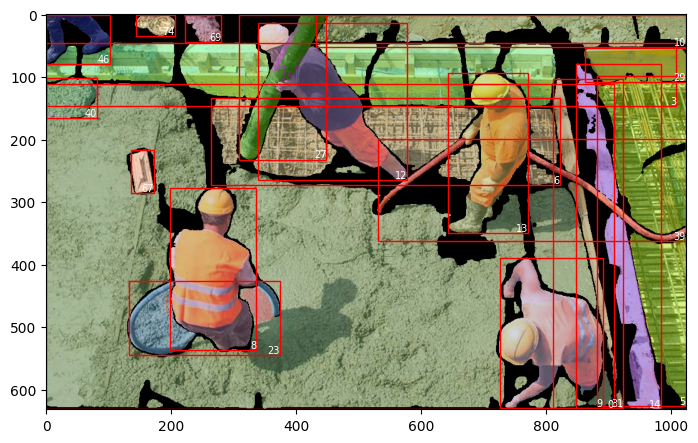

In [60]:
show_def_masks(used_img,sorted_masks,maskIDs=[67, 6, 39, 40, 9, 8, 12, 13, 14, 23, 27, 29, 31, 0, 3, 5, 10, 46, 69, 74],drawBbox=True)

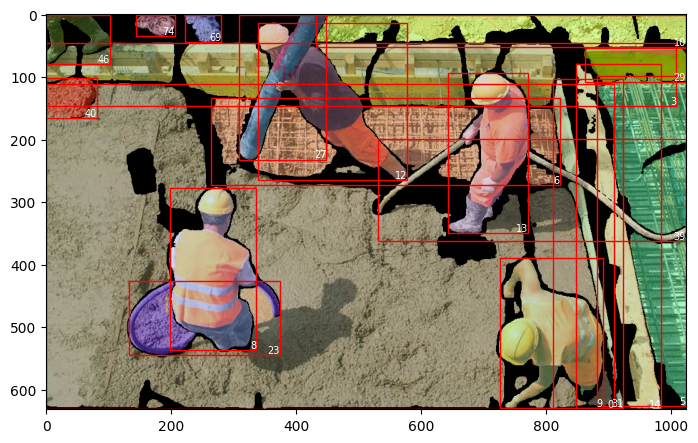

In [39]:
show_def_masks(used_img,sorted_masks,maskIDs=[6, 39, 40, 9, 8, 12, 13, 14, 23, 27, 29, 31, 0, 3, 5, 10, 46, 69, 74],)

### c.4 获取获取可以展示的独立个体
a. keep_set  
b. childern_box

In [56]:
# 显示所有的children_box
children_box = []
for k,v in updated_tree.items():
    children_box.extend(v["children_box"]["keep"])
children_box = np.unique(np.array(children_box))

In [57]:
children_box

array([], dtype=float64)

In [58]:
keep_nodes = {
    "keep_set":keep_set,
    "children_box":children_box
}

In [59]:
uppdate_Tree_root = f"./results/includeTree_info/{img_id}_update.pkl"
keep_nodes_root = f"./results/keep_node_info/{img_id}.pkl"
with open(uppdate_Tree_root, "wb") as fp:
    pickle.dump(updated_tree,fp)
with open(keep_nodes_root, "wb") as fp:
    pickle.dump(keep_nodes, fp)

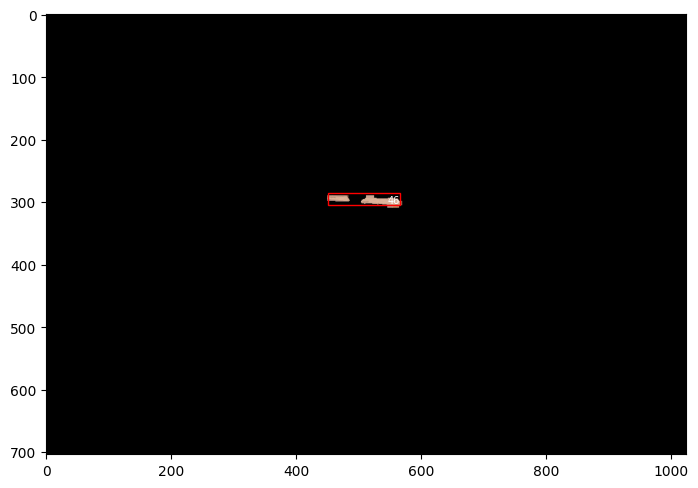

In [492]:
show_def_masks(used_img, sorted_masks, maskIDs=[46 ], drawBbox=True)

## d. CLIP model 定义

### (1) 准备数据

In [60]:
pkl_root = f"./results/pkl_info/{img_id}.pkl"
uppdate_Tree_root = f"./results/includeTree_info/{img_id}_update.pkl"
keep_nodes_root = f"./results/keep_node_info/{img_id}.pkl"

with open(pkl_root, "rb") as fp:
    results = pickle.load(fp)
sorted_masks = results['sorted_masks']
used_img = results['img_opencv']

with open(uppdate_Tree_root, "rb") as fp:
    updated_tree = pickle.load(fp)

with open(keep_nodes_root, "rb") as fp:
    keep_nodes = pickle.load(fp)

### (2) 定义各类匹配的函数

In [6]:
import clip
import open_clip
# from open_clip import tokenizer
from transformers import AutoProcessor, AutoModel, CLIPImageProcessor,CLIPTokenizer

In [62]:
# 模型存放的folder:
# C:\Users\HKU-i5-Oscar\.cache\huggingface\hub

In [11]:
def clip_model(img_pillow, texts, keywords, device, clip_name = "ViT-L-14"):
    # 需要测试 ViT-L-14, RN50x64
    clip_model_list = {
        "RN50x64":"./weights/clip_models/clip/RN50x64.pt",
        "ViT-B-16":"./weights/clip_models/clip/ViT-B-16.pt",
        "ViT-B-32":"./weights/clip_models/clip/ViT-B-32.pt",
        "ViT-L-14":"./weights/clip_models/clip/ViT-L-14.pt"
    }
    model, preprocess = clip.load(name = clip_model_list[clip_name],device=device)
    model.eval()
    
    # 对文本进行预处理
    text_embeddings = clip.tokenize(texts=texts, context_length=77).to(device)
    # 对图片进行预处理
    preprocessed_img = preprocess(img_pillow).unsqueeze(0).to(device)
    
    with torch.no_grad():
        image_feature = model.encode_image(preprocessed_img)
        text_features = model.encode_text(text_embeddings)
        
        text_probs = image_feature.matmul(text_features.T).softmax(dim=-1)
        top_probs, top_labels = text_probs.squeeze(0).cpu().topk(5, dim=-1)

    top_probs = top_probs.numpy()
    top_labels_idx = top_labels.numpy()
    top_labels = [keywords[i] for i in top_labels]

    del model
    torch.cuda.empty_cache()
    gc.collect()

    return {
        "top_probs":top_probs.tolist(),
        "top_labels_idx":top_labels_idx.tolist(),
        "top_labels":top_labels
    }

In [12]:
def openclip_model(img_pillow, texts, keywords, device, clip_name = "ViT-L-14"):
    # OpenCLIP: OpenCLIP gets many models, just pick several models with best performance according to 
    # the released paper.
    if clip_name == "ViT-L-14-o":
        clip_name = "ViT-L-14"

    # 需要测试 ViT-B-16，ViT-H-14，ViT-L-14，convnext_base_w，convnext_large_d，ViT-H-14-quickgelu
    openclip_model_list = {
        "ViT-B-16":"laion2b_s34b_b88k",
        "ViT-H-14":"laion2b_s32b_b79k",
        "ViT-L-14":"laion2b_s32b_b82k",
        # 'ViT-g-14':'laion2b_s12b_b42k', # 超级无敌慢效果差, 预测的结果也差得一塌糊涂
        # "ViT-bigG-14":"laion2b_s39b_b160k", # 超级无敌慢效果差, 预测的结果也差得一塌糊涂
        "ViT-H-14-quickgelu":"dfn5b", # 慢，效果和"ViT-H-14" 差不多
        "convnext_base_w":"laion2b_s13b_b82k_augreg", # 快
        "convnext_large_d":"laion2b_s26b_b102k_augreg", # depends on the text
        "convnext_xxlarge":"laion2b_s34b_b82k_augreg", # 非常慢
    }

    model, _, preprocess = open_clip.create_model_and_transforms(
        clip_name, 
        pretrained=openclip_model_list[clip_name],
        device=device
    )
    
    model.eval()
    tokenizer = open_clip.get_tokenizer(model_name=clip_name)
    
    # 对文本进行预处理
    text_embeddings = tokenizer(texts=texts).to(device)
    # 对图片进行预处理
    preprocessed_img = preprocess(img_pillow).unsqueeze(0).to(device)
    
    with torch.no_grad():
        image_feature = model.encode_image(preprocessed_img)
        text_features = model.encode_text(text_embeddings)
        text_probs = image_feature.matmul(text_features.T).softmax(dim=-1)
        top_probs, top_labels = text_probs.squeeze(0).cpu().topk(5, dim=-1)
    
    top_probs = top_probs.numpy()
    top_labels_idx = top_labels.numpy()
    top_labels = [keywords[i] for i in top_labels]

    del model
    torch.cuda.empty_cache()
    gc.collect()

    return {
        "top_probs":top_probs.tolist(),
        "top_labels_idx":top_labels_idx.tolist(),
        "top_labels":top_labels
    }

In [670]:
evaclip_model_list = {
        "EVA02-B-16":"merged2b_s8b_b131k",
        "EVA01-g-14":"laion400m_s11b_b41k",
        "EVA02-L-14":"merged2b_s4b_b131k", # 11:
        "EVA02-L-14-336":"merged2b_s6b_b61k", # 22: 
        "EVA02-E-14":"laion2b_s4b_b115k", # bigE: 超级大，可能会很慢
    }
    
model, _, preprocess = open_clip.create_model_and_transforms(
    "EVA02-L-14-336", 
    pretrained=evaclip_model_list['EVA02-L-14-336'],
    device=device
)
model

CustomTextCLIP(
  (visual): TimmModel(
    (trunk): Eva(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (rope): RotaryEmbeddingCat()
      (blocks): ModuleList(
        (0-23): 24 x EvaBlock(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): EvaAttention(
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (norm): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path1): Identity()
          (norm2)

In [671]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [13]:
def siglip_model(img_pillow, texts, keywords, device, clip_name = "sig_large"):
    siglip_model_list = {
        "sig_base":"google/siglip-base-patch16-384",
        "sig_large":"google/siglip-large-patch16-384",
        "sig_400m":"google/siglip-so400m-patch14-384",
        "sig_base_224":"google/siglip-base-patch16-224",
        "sig_400m_224":"google/siglip-so400m-patch14-224"
    }
    
    model = AutoModel.from_pretrained(siglip_model_list[clip_name])
    model.eval()
    processor = AutoProcessor.from_pretrained(siglip_model_list[clip_name])
    
    inputs = processor(text=texts, images=img_pillow, padding="max_length", truncation=True, return_tensors="pt")
    
    # 对文本进行预处理
    text_embeddings = inputs["input_ids"]
    # 对图片进行预处理
    preprocessed_img = inputs["pixel_values"]
    
    with torch.no_grad():
        outputs = model(input_ids = text_embeddings, pixel_values = preprocessed_img)
        text_probs = outputs.logits_per_image.softmax(dim=-1)
        top_probs, top_labels = text_probs.squeeze(0).topk(5, dim=-1)
    
    top_probs = top_probs.numpy()
    top_labels_idx = top_labels.numpy()
    top_labels = [keywords[i] for i in top_labels]

    del model
    torch.cuda.empty_cache()
    gc.collect()

    return {
        "top_probs":top_probs.tolist(),
        "top_labels_idx":top_labels_idx.tolist(),
        "top_labels":top_labels
    }

In [27870]:
# nnnname = "google/siglip-so400m-patch14-384"
nnnname = r"C:\Users\HKU-i5-Oscar\.cache\huggingface\hub\models--timm--eva02_large_patch14_clip_224.merged2b_s4b_b131k\snapshots\bf4190eb65dd5204ffb03e980108beb1200e0873"
model = AutoModel.from_pretrained(nnnname)
model.eval()
processor = AutoProcessor.from_pretrained(nnnname)

OSError: Error no file named pytorch_model.bin, model.safetensors, tf_model.h5, model.ckpt.index or flax_model.msgpack found in directory C:\Users\HKU-i5-Oscar\.cache\huggingface\hub\models--timm--eva02_large_patch14_clip_224.merged2b_s4b_b131k\snapshots\bf4190eb65dd5204ffb03e980108beb1200e0873.

In [27871]:
def evaclip_model(img_pillow, texts, keywords, device, clip_name = "EVA02-L-14"):
    # 需要测试 EVA02-B-16，EVA01-g-14，EVA02-L-14，EVA02-L-14-336，EVA02-E-14
    evaclip_model_list = {
        "EVA02-B-16":"merged2b_s8b_b131k",
        "EVA01-g-14":"laion400m_s11b_b41k",
        "EVA02-L-14":"merged2b_s4b_b131k", # 11:
        "EVA02-L-14-336":"merged2b_s6b_b61k", # 22: 
        "EVA02-E-14":"laion2b_s4b_b115k", # bigE: 超级大，可能会很慢
    }
    
    model, _, preprocess = open_clip.create_model_and_transforms(
        clip_name, 
        pretrained=evaclip_model_list[clip_name],
        device=device
    )
    
    model.eval()
    tokenizer = open_clip.get_tokenizer(model_name=clip_name)
    
    # 对文本进行预处理
    text_embeddings = tokenizer(texts=texts).to(device)
    # 对图片进行预处理
    preprocessed_img = preprocess(img_pillow).unsqueeze(0).to(device)
    
    with torch.no_grad():
        image_feature = model.encode_image(preprocessed_img)
        text_features = model.encode_text(text_embeddings)
        text_probs = image_feature.matmul(text_features.T).softmax(dim=-1)
        top_probs, top_labels = text_probs.squeeze(0).cpu().topk(5, dim=-1)
    
    top_probs = top_probs.numpy()
    top_labels_idx = top_labels.numpy()
    top_labels = [keywords[i] for i in top_labels]

    del model
    torch.cuda.empty_cache()
    gc.collect()

    return {
        "top_probs":top_probs.tolist(),
        "top_labels_idx":top_labels_idx.tolist(),
        "top_labels":top_labels
    }

### (3) 图文匹配

In [6]:
def getImageByMasks(img_opencv, masks, mainID, children_segs, maskTag=True):
    img = cv2.cvtColor(img_opencv, cv2.COLOR_RGB2BGR)
    
    m = masks[mainID]
    x = int(masks[mainID]["bbox"][0])
    y = int(masks[mainID]["bbox"][1])
    w = int(masks[mainID]["bbox"][2])
    h = int(masks[mainID]["bbox"][3])

    main_mask = m["segmentation"]
    if len(children_segs) > 0:
        for c in children_segs:
            child_mask = masks[c]["segmentation"]
            main_mask = main_mask | child_mask

    img_m = np.zeros_like(img)
    color_mask = np.array([255,255,255], dtype=np.uint8)

    
    img_m[main_mask] = color_mask # 制作掩码
    masked_image = cv2.bitwise_and(img, img_m) # 通过掩码获取图片彩色的部分

    if maskTag:
        processed_roi = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
        roi_image = processed_roi[y:y+h,x:x+w]
        roi_image[np.where((roi_image == [0, 0, 0]).all(axis=2))] = [255, 255, 255]
        return roi_image
    else:
        roi_image = img[y:y+h,x:x+w] # 如果需要masked之后的图片，可以使用processed_roi[y:y+h,x:x+w]
        roi_image = cv2.cvtColor(roi_image, cv2.COLOR_BGR2RGB)
        roi_image[np.where((roi_image == [0, 0, 0]).all(axis=2))] = [255, 255, 255]
        return roi_image

In [86]:
semantic_data = {}
for k, v in tqdm(keep_nodes.items(), desc="Processing nodes", position=0):
    if k == "keep_set":
        for node in tqdm(v, desc="Processing keep_set", leave=False, position=1):
            keep_children_seg = updated_tree[node]["children_seg"]["keep"]
            
            roi_image_true = getImageByMasks(
                used_img, 
                sorted_masks, 
                mainID=node, 
                children_segs=keep_children_seg, maskTag=True
            ) # without background
            
            roi_image_false = getImageByMasks(
                used_img, 
                sorted_masks, 
                mainID=node, 
                children_segs=keep_children_seg, 
                maskTag=False
            ) # with background

            roi_image_true = Image.fromarray(roi_image_true)
            roi_image_false = Image.fromarray(roi_image_false)

            result = siglip_model(
                img_pillow=roi_image_true, 
                texts=texts, 
                keywords=keywords, 
                device=device, 
                clip_name = "sig_large" # sig_400m_224
            )
            semantic_data[node] = result
            
    if k == "children_box":
        for node in tqdm(v, desc="Processing children_box", leave=False, position=1):
            roi_image_true = getImageByMasks(used_img, sorted_masks, mainID=node, children_segs=[], maskTag=True)
            roi_image_false = getImageByMasks(used_img, sorted_masks, mainID=node, children_segs=[], maskTag=False)
            roi_image_true = Image.fromarray(roi_image_true)
            roi_image_false = Image.fromarray(roi_image_false)
            
            result = siglip_model(
                img_pillow=roi_image_false, 
                texts=texts, 
                keywords=keywords, 
                device=device, 
                clip_name = "sig_large" # sig_400m_224
            )
            semantic_data[node] = result

Processing nodes:  50%|████████████████████████████████▌                                | 1/2 [01:48<01:48, 108.80s/it]
cessing children_box: 0it [00:00, ?it/s]
Processing nodes: 100%|██████████████████████████████████████████████████████████████████| 2/2 [01:48<00:00, 54.40s/it]


In [88]:
sam_name = "fastsam"
clip_name = "sig_large"

final_clip_folder = {
    "RN50x64":"1_clip_rn",
    "ViT-L-14":"2_clip_vit",
    "convnext_large_d":"3_openclip_convnext",
    "ViT-L-14-o":"4_openclip_vit",
    "sig_large":"5_siglip_large",
    "sig_400m":"6_siglip_400m",
    "EVA02-L-14":"7_evaclip_eva02_l_14",
    "EVA02-L-14-336":"8_evaclip_eva02_l_14_336"
}

semantic_data_root = f"./results/final_result/{sam_name}/{final_clip_folder[clip_name]}/{img_id}.json"
with open(semantic_data_root,"w") as fp:
    json.dump(semantic_data, fp)

In [7]:
def getInfoFromFolder(pkl_root,includeTree_root,keepNode_root):
    
    with open(pkl_root, "rb") as fp:
        results = pickle.load(fp)

    sorted_masks = results["sorted_masks"]
    used_img = results["img_opencv"]

    with open(includeTree_root, "rb") as fp:
        results = pickle.load(fp)

    includeTree = results["includeTree"]

    with open(keepNode_root, "rb") as fp:
        results = pickle.load(fp)

    updated_tree = results["updated_tree"]
    ancestors_node = results["ancestors_node"]
    children_box_node = results["children_box_node"]

    return {
        "sorted_masks":sorted_masks,
        "used_img":used_img,
        "includeTree":includeTree,
        "updated_tree":updated_tree,
        "ancestors_node":ancestors_node,
        "children_box_node":children_box_node
    }

In [61]:
# keywords = [
#     "onsite rebar mesh or onsite rebars",
#     # "onsite rebars",
#     "onsite formworks", "surface concrete",
#     # "concrete road",
#     "concrete wall", "cement wall", "surface wood", "materials rebar", "bricks",
#     "wooden plank", "wooden tool: support", "wooden tool", "wooden board", "board",
#     "pump pipe", "plastering trowel",
#     "worker", "construction worker", "feet of worker",
#     # "tool",
#     "white plastic cloth", "electrical equipment", "safety tool", "vehicle:excavator",
#     # facility
#     "roof", # roof cover
#     "unknown region/area",
# ]
# texts = [f"This is a region of '{k}'" for k in keywords]

In [27892]:
sam_folder = {
    # "sam":"1. sam_masks",
    "sam22":"2. sam2_masks",
    "fastsam":"3. fastsam_masks"
}
final_clip_folder = {
    "RN50x64":"1_clip_rn",
    "ViT-L-14":"2_clip_vit",
    "convnext_large_d":"3_openclip_convnext",
    "ViT-L-14-o":"4_openclip_vit",
    "sig_large":"5_siglip_large",
    "sig_400m":"6_siglip_400m",
    "EVA02-L-14":"7_evaclip_eva02_l_14",
    "EVA02-L-14-336":"8_evaclip_eva02_l_14_336"
}
clip_funcs = {
    "RN50x64":clip_model,
    "ViT-L-14":clip_model,
    "convnext_large_d":openclip_model,
    "ViT-L-14-o":openclip_model,
    "sig_large":siglip_model,
    "sig_400m":siglip_model,
    "EVA02-L-14":evaclip_model,
    "EVA02-L-14-336":evaclip_model
}

In [27855]:
# 处理并获取能处理的图片
# result_data = pd.read_excel("./results/results log.xlsx")

# leftImageList = []

# for i, row in result_data.iterrows():
#     idx = row["Image ID"]
#     value = row["Filtered semantic regions"]
#     if pd.isna(value) == False:
#         leftImageList.append(idx)

# with open("./leftImageList.json","w") as fp:
#     fp.write(json.dumps(
#         {"ids":leftImageList}
#     ))

with open("./leftImageList.json","r") as fp:
    leftImageList = json.loads(fp.read())["ids"]
len(leftImageList)

101

In [ ]:
origin_clip_models = ["RN50x64","ViT-L-14","convnext_large_d","ViT-L-14-o","sig_large","sig_400m","EVA02-L-14","EVA02-L-14-336"] # 
clip_model_names = ["EVA02-L-14","EVA02-L-14-336"]
# originList = [1, 3, 4, 6, 9, 11, 14, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 29, 30, 32, 33, 34, 35, 37, 38, 39, 40, 42, 44, 
#                  45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 60, 61, 62, 63, 64, 65, 66, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 
#                  79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103, 104, 105, 106, 108, 
#                  109, 110, 111, 112, 113, 114, 116, 117, 120, 121, 123, 124, 125, 126]
leftImageList = [1, 3, 4, 6, 9, 11, 14, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 29, 30, 32, 33, 34, 35, 37, 38, 39, 40, 42, 44, 
                 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 60, 61, 62, 63, 64, 65, 66, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 
                 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103, 104, 105, 106, 108, 
                 109, 110, 111, 112, 113, 114, 116, 117, 120, 121, 123, 124, 125, 126]

In [27893]:
cmn_sam = {
    "sam22":["EVA02-L-14-336"],
    "fastsam":["RN50x64","ViT-L-14","convnext_large_d","ViT-L-14-o","sig_large","sig_400m","EVA02-L-14","EVA02-L-14-336"]
}

In [27894]:
lil_sam = {
    "sam22":[1, 3, 4, 6, 9, 11, 14, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 29, 30, 32, 33, 34, 35, 37, 38, 39, 40, 42, 44, 
             45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 60, 61, 62, 63, 64, 65, 66, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 
             79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103, 104, 105, 106, 108, 
             109, 110, 111, 112, 113, 114, 116, 117, 120, 121, 123, 124, 125, 126],
    "fastsam":[1, 3, 4, 6, 9, 11, 14, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 29, 30, 32, 33, 34, 35, 37, 38, 39, 40, 42, 44, 
             45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 60, 61, 62, 63, 64, 65, 66, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 
             79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103, 104, 105, 106, 108, 
             109, 110, 111, 112, 113, 114, 116, 117, 120, 121, 123, 124, 125, 126]
}

In [27896]:
keywords_path_base = "./results/final_keywords/"

for k, v in sam_folder.items(): # 处理不同分割工具的分割结果。
    for cm in cmn_sam[k]:
        cm_func = clip_funcs[cm]
        for img_id in lil_sam[k]:
            print(f"Processing----> Sam_Model: {k}   Clip_Model: {cm}   Image_ID: {img_id}")

            keywords_path = keywords_path_base + str(img_id) + ".json"
            print(f"Keywords Path: {keywords_path}")
            with open(keywords_path, "r") as fp:
                results = json.load(fp)
            keywords = results["keywords"]
            texts = results["texts"]
            
            
            pkl_root = f"./results/{v}/pkl_info/{img_id}.pkl"
            includeTree_root = f"./results/{v}/includeTree_info/{img_id}.pkl"
            keepNode_root = f"./results/{v}/keep_node_info/{img_id}.pkl"
    
            results = getInfoFromFolder(pkl_root=pkl_root, includeTree_root=includeTree_root, keepNode_root=keepNode_root)
    
            sorted_masks = results["sorted_masks"]
            used_img = results["used_img"]
            includeTree = results["includeTree"]
            updated_tree = results["updated_tree"]
            ancestors_node = results["ancestors_node"]
            children_box_node = results["children_box_node"]
    
            mask_semantics = { }
            
            for mask_id in tqdm(ancestors_node+children_box_node, desc=f"Masks ID of {img_id} Image"):
                roi_image_true = getImageByMasks(used_img, sorted_masks, mask_id, children_segs=[], maskTag=True) # without background
                roi_image_false = getImageByMasks(used_img, sorted_masks, mask_id, children_segs=[], maskTag=False) # with background
                roi_image_true = Image.fromarray(roi_image_true)
                roi_image_false = Image.fromarray(roi_image_false)
                matching_results = cm_func(roi_image_true, texts, keywords, device = device, clip_name=cm)
                mask_semantics[mask_id] = matching_results
            
            if k == "sam22":
                k = "sam2"
            mask_semantic_root = f"./results/final_result/{k}/{final_clip_folder[cm]}/json/{img_id}.json"
            with open(mask_semantic_root, "w") as fp:
                json.dump(mask_semantics,fp)

            mask_top5_root = f"./results/final_result/{k}/{final_clip_folder[cm]}/excel/{img_id}.xlsx"
            maskpred = pd.DataFrame(columns=["mask_id", "pred_1", "pred_2", "pred_3", "pred_4", "pred_5"])
            for i, (k2, v2) in enumerate(mask_semantics.items()):    
                mask_id = k2
                preds = v2["top_labels"]
                maskpred.loc[i] = [mask_id, *preds]
            
            maskpred = maskpred.sort_values(by='mask_id')
            maskpred.to_excel(mask_top5_root)
            time.sleep(2)

Processing----> Sam_Model: sam22   Clip_Model: EVA02-L-14-336   Image_ID: 1
Keywords Path: ./results/final_keywords/1.json


Masks ID of 1 Image: 100%|█████████████████████████████████████████████████████████████| 18/18 [01:31<00:00,  5.11s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 3
Keywords Path: ./results/final_keywords/3.json


Masks ID of 3 Image: 100%|███████████████████████████████████████████████████████████████| 9/9 [00:44<00:00,  4.99s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 4
Keywords Path: ./results/final_keywords/4.json


Masks ID of 4 Image: 100%|█████████████████████████████████████████████████████████████| 45/45 [03:45<00:00,  5.01s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 6
Keywords Path: ./results/final_keywords/6.json


Masks ID of 6 Image: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:29<00:00,  4.91s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 9
Keywords Path: ./results/final_keywords/9.json


Masks ID of 9 Image: 100%|█████████████████████████████████████████████████████████████| 29/29 [02:22<00:00,  4.92s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 11
Keywords Path: ./results/final_keywords/11.json


Masks ID of 11 Image: 100%|████████████████████████████████████████████████████████████| 31/31 [02:31<00:00,  4.90s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 14
Keywords Path: ./results/final_keywords/14.json


Masks ID of 14 Image: 100%|████████████████████████████████████████████████████████████| 39/39 [03:13<00:00,  4.97s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 16
Keywords Path: ./results/final_keywords/16.json


Masks ID of 16 Image: 100%|████████████████████████████████████████████████████████████| 30/30 [02:26<00:00,  4.89s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 17
Keywords Path: ./results/final_keywords/17.json


Masks ID of 17 Image: 100%|████████████████████████████████████████████████████████████| 37/37 [03:02<00:00,  4.93s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 18
Keywords Path: ./results/final_keywords/18.json


Masks ID of 18 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [01:08<00:00,  4.92s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 19
Keywords Path: ./results/final_keywords/19.json


Masks ID of 19 Image: 100%|████████████████████████████████████████████████████████████| 11/11 [00:55<00:00,  5.04s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 20
Keywords Path: ./results/final_keywords/20.json


Masks ID of 20 Image: 100%|████████████████████████████████████████████████████████████| 30/30 [02:26<00:00,  4.88s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 21
Keywords Path: ./results/final_keywords/21.json


Masks ID of 21 Image: 100%|██████████████████████████████████████████████████████████████| 9/9 [00:43<00:00,  4.84s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 23
Keywords Path: ./results/final_keywords/23.json


Masks ID of 23 Image: 100%|████████████████████████████████████████████████████████████| 50/50 [04:08<00:00,  4.97s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 24
Keywords Path: ./results/final_keywords/24.json


Masks ID of 24 Image: 100%|████████████████████████████████████████████████████████████| 28/28 [02:15<00:00,  4.85s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 25
Keywords Path: ./results/final_keywords/25.json


Masks ID of 25 Image: 100%|████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.00s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 27
Keywords Path: ./results/final_keywords/27.json


Masks ID of 27 Image: 100%|████████████████████████████████████████████████████████████| 55/55 [04:43<00:00,  5.15s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 28
Keywords Path: ./results/final_keywords/28.json


Masks ID of 28 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [01:48<00:00,  4.93s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 29
Keywords Path: ./results/final_keywords/29.json


Masks ID of 29 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [01:47<00:00,  4.87s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 30
Keywords Path: ./results/final_keywords/30.json


Masks ID of 30 Image: 100%|████████████████████████████████████████████████████████████| 52/52 [04:17<00:00,  4.95s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 32
Keywords Path: ./results/final_keywords/32.json


Masks ID of 32 Image: 100%|██████████████████████████████████████████████████████████████| 9/9 [00:44<00:00,  4.94s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 33
Keywords Path: ./results/final_keywords/33.json


Masks ID of 33 Image: 100%|██████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.13s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 34
Keywords Path: ./results/final_keywords/34.json


Masks ID of 34 Image: 100%|████████████████████████████████████████████████████████████| 15/15 [01:15<00:00,  5.00s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 35
Keywords Path: ./results/final_keywords/35.json


Masks ID of 35 Image: 100%|████████████████████████████████████████████████████████████| 25/25 [02:08<00:00,  5.15s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 37
Keywords Path: ./results/final_keywords/37.json


Masks ID of 37 Image: 100%|████████████████████████████████████████████████████████████| 27/27 [02:16<00:00,  5.04s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 38
Keywords Path: ./results/final_keywords/38.json


Masks ID of 38 Image: 100%|██████████████████████████████████████████████████████████████| 9/9 [00:43<00:00,  4.89s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 39
Keywords Path: ./results/final_keywords/39.json


Masks ID of 39 Image: 100%|██████████████████████████████████████████████████████████████| 9/9 [00:44<00:00,  4.96s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 40
Keywords Path: ./results/final_keywords/40.json


Masks ID of 40 Image: 100%|████████████████████████████████████████████████████████████| 27/27 [02:15<00:00,  5.01s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 42
Keywords Path: ./results/final_keywords/42.json


Masks ID of 42 Image: 100%|████████████████████████████████████████████████████████████| 28/28 [02:18<00:00,  4.96s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 44
Keywords Path: ./results/final_keywords/44.json


Masks ID of 44 Image: 100%|████████████████████████████████████████████████████████████| 15/15 [01:15<00:00,  5.03s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 45
Keywords Path: ./results/final_keywords/45.json


Masks ID of 45 Image: 100%|████████████████████████████████████████████████████████████| 25/25 [02:06<00:00,  5.08s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 46
Keywords Path: ./results/final_keywords/46.json


Masks ID of 46 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [01:10<00:00,  5.02s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 47
Keywords Path: ./results/final_keywords/47.json


Masks ID of 47 Image: 100%|████████████████████████████████████████████████████████████| 44/44 [03:42<00:00,  5.06s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 48
Keywords Path: ./results/final_keywords/48.json


Masks ID of 48 Image: 100%|████████████████████████████████████████████████████████████| 36/36 [03:03<00:00,  5.10s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 49
Keywords Path: ./results/final_keywords/49.json


Masks ID of 49 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [01:10<00:00,  5.02s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 50
Keywords Path: ./results/final_keywords/50.json


Masks ID of 50 Image: 100%|████████████████████████████████████████████████████████████| 32/32 [02:36<00:00,  4.90s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 52
Keywords Path: ./results/final_keywords/52.json


Masks ID of 52 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [01:03<00:00,  4.85s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 53
Keywords Path: ./results/final_keywords/53.json


Masks ID of 53 Image: 100%|████████████████████████████████████████████████████████████| 20/20 [01:36<00:00,  4.84s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 54
Keywords Path: ./results/final_keywords/54.json


Masks ID of 54 Image: 100%|████████████████████████████████████████████████████████████| 24/24 [01:56<00:00,  4.85s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 55
Keywords Path: ./results/final_keywords/55.json


Masks ID of 55 Image: 100%|██████████████████████████████████████████████████████████████| 5/5 [00:24<00:00,  4.81s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 56
Keywords Path: ./results/final_keywords/56.json


Masks ID of 56 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [02:04<00:00,  4.80s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 57
Keywords Path: ./results/final_keywords/57.json


Masks ID of 57 Image: 100%|████████████████████████████████████████████████████████████| 31/31 [02:29<00:00,  4.82s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 60
Keywords Path: ./results/final_keywords/60.json


Masks ID of 60 Image: 100%|████████████████████████████████████████████████████████████| 27/27 [02:09<00:00,  4.79s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 61
Keywords Path: ./results/final_keywords/61.json


Masks ID of 61 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [01:07<00:00,  4.81s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 62
Keywords Path: ./results/final_keywords/62.json


Masks ID of 62 Image: 100%|████████████████████████████████████████████████████████████| 19/19 [01:31<00:00,  4.80s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 63
Keywords Path: ./results/final_keywords/63.json


Masks ID of 63 Image: 100%|████████████████████████████████████████████████████████████| 27/27 [02:09<00:00,  4.79s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 64
Keywords Path: ./results/final_keywords/64.json


Masks ID of 64 Image: 100%|████████████████████████████████████████████████████████████| 20/20 [01:35<00:00,  4.79s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 65
Keywords Path: ./results/final_keywords/65.json


Masks ID of 65 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [01:02<00:00,  4.79s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 66
Keywords Path: ./results/final_keywords/66.json


Masks ID of 66 Image: 100%|████████████████████████████████████████████████████████████| 12/12 [00:57<00:00,  4.79s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 68
Keywords Path: ./results/final_keywords/68.json


Masks ID of 68 Image: 100%|████████████████████████████████████████████████████████████| 15/15 [01:11<00:00,  4.76s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 70
Keywords Path: ./results/final_keywords/70.json


Masks ID of 70 Image: 100%|████████████████████████████████████████████████████████████| 31/31 [02:29<00:00,  4.81s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 71
Keywords Path: ./results/final_keywords/71.json


Masks ID of 71 Image: 100%|████████████████████████████████████████████████████████████| 23/23 [01:50<00:00,  4.79s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 72
Keywords Path: ./results/final_keywords/72.json


Masks ID of 72 Image: 100%|████████████████████████████████████████████████████████████| 21/21 [01:44<00:00,  4.97s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 73
Keywords Path: ./results/final_keywords/73.json


Masks ID of 73 Image: 100%|████████████████████████████████████████████████████████████| 11/11 [00:54<00:00,  4.95s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 74
Keywords Path: ./results/final_keywords/74.json


Masks ID of 74 Image: 100%|██████████████████████████████████████████████████████████████| 7/7 [00:33<00:00,  4.77s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 75
Keywords Path: ./results/final_keywords/75.json


Masks ID of 75 Image: 100%|████████████████████████████████████████████████████████████| 19/19 [01:30<00:00,  4.77s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 76
Keywords Path: ./results/final_keywords/76.json


Masks ID of 76 Image: 100%|████████████████████████████████████████████████████████████| 24/24 [01:55<00:00,  4.82s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 77
Keywords Path: ./results/final_keywords/77.json


Masks ID of 77 Image: 100%|████████████████████████████████████████████████████████████| 21/21 [01:40<00:00,  4.80s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 78
Keywords Path: ./results/final_keywords/78.json


Masks ID of 78 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [01:07<00:00,  4.85s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 79
Keywords Path: ./results/final_keywords/79.json


Masks ID of 79 Image: 100%|████████████████████████████████████████████████████████████| 15/15 [01:14<00:00,  4.94s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 80
Keywords Path: ./results/final_keywords/80.json


Masks ID of 80 Image: 100%|████████████████████████████████████████████████████████████| 16/16 [01:18<00:00,  4.91s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 81
Keywords Path: ./results/final_keywords/81.json


Masks ID of 81 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [01:02<00:00,  4.83s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 82
Keywords Path: ./results/final_keywords/82.json


Masks ID of 82 Image: 100%|████████████████████████████████████████████████████████████| 16/16 [01:19<00:00,  4.96s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 83
Keywords Path: ./results/final_keywords/83.json


Masks ID of 83 Image: 100%|██████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.08s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 84
Keywords Path: ./results/final_keywords/84.json


Masks ID of 84 Image: 100%|████████████████████████████████████████████████████████████| 20/20 [01:40<00:00,  5.03s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 85
Keywords Path: ./results/final_keywords/85.json


Masks ID of 85 Image: 100%|██████████████████████████████████████████████████████████████| 6/6 [00:29<00:00,  4.92s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 86
Keywords Path: ./results/final_keywords/86.json


Masks ID of 86 Image: 100%|████████████████████████████████████████████████████████████| 11/11 [00:56<00:00,  5.10s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 87
Keywords Path: ./results/final_keywords/87.json


Masks ID of 87 Image: 100%|████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.05s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 88
Keywords Path: ./results/final_keywords/88.json


Masks ID of 88 Image: 100%|████████████████████████████████████████████████████████████| 23/23 [01:52<00:00,  4.90s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 89
Keywords Path: ./results/final_keywords/89.json


Masks ID of 89 Image: 100%|████████████████████████████████████████████████████████████| 24/24 [01:58<00:00,  4.94s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 90
Keywords Path: ./results/final_keywords/90.json


Masks ID of 90 Image: 100%|██████████████████████████████████████████████████████████████| 7/7 [00:36<00:00,  5.25s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 91
Keywords Path: ./results/final_keywords/91.json


Masks ID of 91 Image: 100%|████████████████████████████████████████████████████████████| 20/20 [01:38<00:00,  4.93s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 92
Keywords Path: ./results/final_keywords/92.json


Masks ID of 92 Image: 100%|████████████████████████████████████████████████████████████| 61/61 [05:05<00:00,  5.01s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 93
Keywords Path: ./results/final_keywords/93.json


Masks ID of 93 Image: 100%|████████████████████████████████████████████████████████████| 43/43 [03:40<00:00,  5.13s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 94
Keywords Path: ./results/final_keywords/94.json


Masks ID of 94 Image: 100%|████████████████████████████████████████████████████████████| 37/37 [03:06<00:00,  5.04s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 95
Keywords Path: ./results/final_keywords/95.json


Masks ID of 95 Image: 100%|████████████████████████████████████████████████████████████| 11/11 [00:55<00:00,  5.06s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 96
Keywords Path: ./results/final_keywords/96.json


Masks ID of 96 Image: 100%|████████████████████████████████████████████████████████████| 24/24 [02:04<00:00,  5.19s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 97
Keywords Path: ./results/final_keywords/97.json


Masks ID of 97 Image: 100%|████████████████████████████████████████████████████████████| 24/24 [02:04<00:00,  5.17s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 98
Keywords Path: ./results/final_keywords/98.json


Masks ID of 98 Image: 100%|██████████████████████████████████████████████████████████████| 9/9 [00:56<00:00,  6.27s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 99
Keywords Path: ./results/final_keywords/99.json


Masks ID of 99 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:39<00:00,  4.94s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 101
Keywords Path: ./results/final_keywords/101.json


Masks ID of 101 Image: 100%|███████████████████████████████████████████████████████████| 13/13 [01:07<00:00,  5.18s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 102
Keywords Path: ./results/final_keywords/102.json


Masks ID of 102 Image: 100%|███████████████████████████████████████████████████████████| 67/67 [05:37<00:00,  5.03s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 103
Keywords Path: ./results/final_keywords/103.json


Masks ID of 103 Image: 100%|███████████████████████████████████████████████████████████| 30/30 [02:28<00:00,  4.94s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 104
Keywords Path: ./results/final_keywords/104.json


Masks ID of 104 Image: 100%|███████████████████████████████████████████████████████████| 10/10 [00:49<00:00,  4.93s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 105
Keywords Path: ./results/final_keywords/105.json


Masks ID of 105 Image: 100%|███████████████████████████████████████████████████████████| 10/10 [00:49<00:00,  4.97s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 106
Keywords Path: ./results/final_keywords/106.json


Masks ID of 106 Image: 100%|███████████████████████████████████████████████████████████| 14/14 [01:08<00:00,  4.92s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 108
Keywords Path: ./results/final_keywords/108.json


Masks ID of 108 Image: 100%|███████████████████████████████████████████████████████████| 22/22 [01:48<00:00,  4.95s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 109
Keywords Path: ./results/final_keywords/109.json


Masks ID of 109 Image: 100%|███████████████████████████████████████████████████████████| 21/21 [01:43<00:00,  4.92s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 110
Keywords Path: ./results/final_keywords/110.json


Masks ID of 110 Image: 100%|███████████████████████████████████████████████████████████| 11/11 [00:55<00:00,  5.00s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 111
Keywords Path: ./results/final_keywords/111.json


Masks ID of 111 Image: 100%|███████████████████████████████████████████████████████████| 48/48 [04:00<00:00,  5.01s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 112
Keywords Path: ./results/final_keywords/112.json


Masks ID of 112 Image: 100%|███████████████████████████████████████████████████████████| 18/18 [01:33<00:00,  5.19s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 113
Keywords Path: ./results/final_keywords/113.json


Masks ID of 113 Image: 100%|███████████████████████████████████████████████████████████| 44/44 [03:36<00:00,  4.92s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 114
Keywords Path: ./results/final_keywords/114.json


Masks ID of 114 Image: 100%|███████████████████████████████████████████████████████████| 47/47 [03:55<00:00,  5.01s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 116
Keywords Path: ./results/final_keywords/116.json


Masks ID of 116 Image: 100%|███████████████████████████████████████████████████████████| 30/30 [02:32<00:00,  5.07s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 117
Keywords Path: ./results/final_keywords/117.json


Masks ID of 117 Image: 100%|███████████████████████████████████████████████████████████| 27/27 [02:18<00:00,  5.13s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 120
Keywords Path: ./results/final_keywords/120.json


Masks ID of 120 Image: 100%|███████████████████████████████████████████████████████████| 40/40 [03:26<00:00,  5.16s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 121
Keywords Path: ./results/final_keywords/121.json


Masks ID of 121 Image: 100%|███████████████████████████████████████████████████████████| 36/36 [03:02<00:00,  5.07s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 123
Keywords Path: ./results/final_keywords/123.json


Masks ID of 123 Image: 100%|███████████████████████████████████████████████████████████| 21/21 [01:43<00:00,  4.92s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 124
Keywords Path: ./results/final_keywords/124.json


Masks ID of 124 Image: 100%|███████████████████████████████████████████████████████████| 24/24 [01:58<00:00,  4.95s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 125
Keywords Path: ./results/final_keywords/125.json


Masks ID of 125 Image: 100%|███████████████████████████████████████████████████████████| 36/36 [03:00<00:00,  5.03s/it]


Processing----> Sam_Model: sam2   Clip_Model: EVA02-L-14-336   Image_ID: 126
Keywords Path: ./results/final_keywords/126.json


Masks ID of 126 Image: 100%|███████████████████████████████████████████████████████████| 31/31 [02:35<00:00,  5.00s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 1
Keywords Path: ./results/final_keywords/1.json


Masks ID of 1 Image: 100%|█████████████████████████████████████████████████████████████| 15/15 [01:48<00:00,  7.22s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 3
Keywords Path: ./results/final_keywords/3.json


Masks ID of 3 Image: 100%|█████████████████████████████████████████████████████████████| 15/15 [01:44<00:00,  6.96s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 4
Keywords Path: ./results/final_keywords/4.json


Masks ID of 4 Image: 100%|███████████████████████████████████████████████████████████████| 3/3 [00:20<00:00,  6.97s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 6
Keywords Path: ./results/final_keywords/6.json


Masks ID of 6 Image: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:41<00:00,  6.97s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 9
Keywords Path: ./results/final_keywords/9.json


Masks ID of 9 Image: 100%|█████████████████████████████████████████████████████████████| 11/11 [01:15<00:00,  6.91s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 11
Keywords Path: ./results/final_keywords/11.json


Masks ID of 11 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [03:00<00:00,  6.93s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 14
Keywords Path: ./results/final_keywords/14.json


Masks ID of 14 Image: 100%|████████████████████████████████████████████████████████████| 49/49 [05:30<00:00,  6.74s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 16
Keywords Path: ./results/final_keywords/16.json


Masks ID of 16 Image: 100%|████████████████████████████████████████████████████████████| 15/15 [01:36<00:00,  6.45s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 17
Keywords Path: ./results/final_keywords/17.json


Masks ID of 17 Image: 100%|████████████████████████████████████████████████████████████| 25/25 [02:42<00:00,  6.49s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 18
Keywords Path: ./results/final_keywords/18.json


Masks ID of 18 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [01:32<00:00,  6.59s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 19
Keywords Path: ./results/final_keywords/19.json


Masks ID of 19 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:52<00:00,  6.59s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 20
Keywords Path: ./results/final_keywords/20.json


Masks ID of 20 Image: 100%|██████████████████████████████████████████████████████████████| 9/9 [00:59<00:00,  6.66s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 21
Keywords Path: ./results/final_keywords/21.json


Masks ID of 21 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:52<00:00,  6.55s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 23
Keywords Path: ./results/final_keywords/23.json


Masks ID of 23 Image: 100%|████████████████████████████████████████████████████████████| 42/42 [04:36<00:00,  6.58s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 24
Keywords Path: ./results/final_keywords/24.json


Masks ID of 24 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [02:48<00:00,  6.49s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 25
Keywords Path: ./results/final_keywords/25.json


Masks ID of 25 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [01:23<00:00,  6.45s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 27
Keywords Path: ./results/final_keywords/27.json


Masks ID of 27 Image: 100%|████████████████████████████████████████████████████████████| 57/57 [06:03<00:00,  6.37s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 28
Keywords Path: ./results/final_keywords/28.json


Masks ID of 28 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [01:27<00:00,  6.25s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 29
Keywords Path: ./results/final_keywords/29.json


Masks ID of 29 Image: 100%|████████████████████████████████████████████████████████████| 30/30 [03:07<00:00,  6.27s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 30
Keywords Path: ./results/final_keywords/30.json


Masks ID of 30 Image: 100%|████████████████████████████████████████████████████████████| 44/44 [04:34<00:00,  6.23s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 32
Keywords Path: ./results/final_keywords/32.json


Masks ID of 32 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:50<00:00,  6.31s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 33
Keywords Path: ./results/final_keywords/33.json


Masks ID of 33 Image: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:25<00:00,  6.37s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 34
Keywords Path: ./results/final_keywords/34.json


Masks ID of 34 Image: 100%|████████████████████████████████████████████████████████████| 10/10 [01:02<00:00,  6.28s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 35
Keywords Path: ./results/final_keywords/35.json


Masks ID of 35 Image: 100%|████████████████████████████████████████████████████████████| 29/29 [02:59<00:00,  6.20s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 37
Keywords Path: ./results/final_keywords/37.json


Masks ID of 37 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [02:16<00:00,  6.19s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 38
Keywords Path: ./results/final_keywords/38.json


Masks ID of 38 Image: 100%|████████████████████████████████████████████████████████████| 12/12 [01:14<00:00,  6.22s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 39
Keywords Path: ./results/final_keywords/39.json


Masks ID of 39 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [01:24<00:00,  6.49s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 40
Keywords Path: ./results/final_keywords/40.json


Masks ID of 40 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [02:51<00:00,  6.59s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 42
Keywords Path: ./results/final_keywords/42.json


Masks ID of 42 Image: 100%|████████████████████████████████████████████████████████████| 32/32 [03:33<00:00,  6.68s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 44
Keywords Path: ./results/final_keywords/44.json


Masks ID of 44 Image: 100%|████████████████████████████████████████████████████████████| 11/11 [01:13<00:00,  6.72s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 45
Keywords Path: ./results/final_keywords/45.json


Masks ID of 45 Image: 100%|████████████████████████████████████████████████████████████| 10/10 [01:05<00:00,  6.53s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 46
Keywords Path: ./results/final_keywords/46.json


Masks ID of 46 Image: 100%|██████████████████████████████████████████████████████████████| 7/7 [00:45<00:00,  6.47s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 47
Keywords Path: ./results/final_keywords/47.json


Masks ID of 47 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [02:22<00:00,  6.46s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 48
Keywords Path: ./results/final_keywords/48.json


Masks ID of 48 Image: 100%|████████████████████████████████████████████████████████████| 36/36 [03:53<00:00,  6.50s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 49
Keywords Path: ./results/final_keywords/49.json


Masks ID of 49 Image: 100%|████████████████████████████████████████████████████████████| 17/17 [01:52<00:00,  6.63s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 50
Keywords Path: ./results/final_keywords/50.json


Masks ID of 50 Image: 100%|████████████████████████████████████████████████████████████| 29/29 [03:09<00:00,  6.53s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 52
Keywords Path: ./results/final_keywords/52.json


Masks ID of 52 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [01:26<00:00,  6.64s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 53
Keywords Path: ./results/final_keywords/53.json


Masks ID of 53 Image: 100%|████████████████████████████████████████████████████████████| 20/20 [02:10<00:00,  6.55s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 54
Keywords Path: ./results/final_keywords/54.json


Masks ID of 54 Image: 100%|████████████████████████████████████████████████████████████| 12/12 [01:19<00:00,  6.60s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 55
Keywords Path: ./results/final_keywords/55.json


Masks ID of 55 Image: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.46s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 56
Keywords Path: ./results/final_keywords/56.json


Masks ID of 56 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [02:21<00:00,  6.42s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 57
Keywords Path: ./results/final_keywords/57.json


Masks ID of 57 Image: 100%|████████████████████████████████████████████████████████████| 23/23 [02:31<00:00,  6.57s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 60
Keywords Path: ./results/final_keywords/60.json


Masks ID of 60 Image: 100%|████████████████████████████████████████████████████████████| 15/15 [01:37<00:00,  6.52s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 61
Keywords Path: ./results/final_keywords/61.json


Masks ID of 61 Image: 100%|████████████████████████████████████████████████████████████| 15/15 [01:38<00:00,  6.54s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 62
Keywords Path: ./results/final_keywords/62.json


Masks ID of 62 Image: 100%|████████████████████████████████████████████████████████████| 25/25 [02:42<00:00,  6.48s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 63
Keywords Path: ./results/final_keywords/63.json


Masks ID of 63 Image: 100%|████████████████████████████████████████████████████████████| 23/23 [02:27<00:00,  6.43s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 64
Keywords Path: ./results/final_keywords/64.json


Masks ID of 64 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [02:22<00:00,  6.46s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 65
Keywords Path: ./results/final_keywords/65.json


Masks ID of 65 Image: 100%|████████████████████████████████████████████████████████████| 11/11 [01:10<00:00,  6.43s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 66
Keywords Path: ./results/final_keywords/66.json


Masks ID of 66 Image: 100%|██████████████████████████████████████████████████████████████| 6/6 [00:39<00:00,  6.56s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 68
Keywords Path: ./results/final_keywords/68.json


Masks ID of 68 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [01:23<00:00,  6.40s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 70
Keywords Path: ./results/final_keywords/70.json


Masks ID of 70 Image: 100%|████████████████████████████████████████████████████████████| 25/25 [02:39<00:00,  6.36s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 71
Keywords Path: ./results/final_keywords/71.json


Masks ID of 71 Image: 100%|████████████████████████████████████████████████████████████| 10/10 [01:02<00:00,  6.26s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 72
Keywords Path: ./results/final_keywords/72.json


Masks ID of 72 Image: 100%|████████████████████████████████████████████████████████████| 21/21 [02:10<00:00,  6.23s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 73
Keywords Path: ./results/final_keywords/73.json


Masks ID of 73 Image: 100%|██████████████████████████████████████████████████████████████| 7/7 [00:43<00:00,  6.21s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 74
Keywords Path: ./results/final_keywords/74.json


Masks ID of 74 Image: 100%|██████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.26s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 75
Keywords Path: ./results/final_keywords/75.json


Masks ID of 75 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [01:21<00:00,  6.28s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 76
Keywords Path: ./results/final_keywords/76.json


Masks ID of 76 Image: 100%|████████████████████████████████████████████████████████████| 28/28 [02:54<00:00,  6.21s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 77
Keywords Path: ./results/final_keywords/77.json


Masks ID of 77 Image: 100%|████████████████████████████████████████████████████████████| 16/16 [01:40<00:00,  6.25s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 78
Keywords Path: ./results/final_keywords/78.json


Masks ID of 78 Image: 100%|██████████████████████████████████████████████████████████████| 3/3 [00:18<00:00,  6.29s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 79
Keywords Path: ./results/final_keywords/79.json


Masks ID of 79 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [01:27<00:00,  6.28s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 80
Keywords Path: ./results/final_keywords/80.json


Masks ID of 80 Image: 100%|████████████████████████████████████████████████████████████| 21/21 [02:11<00:00,  6.27s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 81
Keywords Path: ./results/final_keywords/81.json


Masks ID of 81 Image: 100%|████████████████████████████████████████████████████████████| 16/16 [01:40<00:00,  6.25s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 82
Keywords Path: ./results/final_keywords/82.json


Masks ID of 82 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [01:27<00:00,  6.27s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 83
Keywords Path: ./results/final_keywords/83.json


Masks ID of 83 Image: 100%|████████████████████████████████████████████████████████████| 11/11 [01:08<00:00,  6.21s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 84
Keywords Path: ./results/final_keywords/84.json


Masks ID of 84 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [02:44<00:00,  6.33s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 85
Keywords Path: ./results/final_keywords/85.json


Masks ID of 85 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:50<00:00,  6.36s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 86
Keywords Path: ./results/final_keywords/86.json


Masks ID of 86 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [01:22<00:00,  6.33s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 87
Keywords Path: ./results/final_keywords/87.json


Masks ID of 87 Image: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:25<00:00,  6.36s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 88
Keywords Path: ./results/final_keywords/88.json


Masks ID of 88 Image: 100%|████████████████████████████████████████████████████████████| 17/17 [01:47<00:00,  6.31s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 89
Keywords Path: ./results/final_keywords/89.json


Masks ID of 89 Image: 100%|████████████████████████████████████████████████████████████| 19/19 [02:00<00:00,  6.33s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 90
Keywords Path: ./results/final_keywords/90.json


Masks ID of 90 Image: 100%|██████████████████████████████████████████████████████████████| 5/5 [00:32<00:00,  6.47s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 91
Keywords Path: ./results/final_keywords/91.json


Masks ID of 91 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:51<00:00,  6.44s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 92
Keywords Path: ./results/final_keywords/92.json


Masks ID of 92 Image: 100%|████████████████████████████████████████████████████████████| 52/52 [05:29<00:00,  6.34s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 93
Keywords Path: ./results/final_keywords/93.json


Masks ID of 93 Image: 100%|████████████████████████████████████████████████████████████| 24/24 [02:31<00:00,  6.29s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 94
Keywords Path: ./results/final_keywords/94.json


Masks ID of 94 Image: 100%|████████████████████████████████████████████████████████████| 31/31 [03:15<00:00,  6.30s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 95
Keywords Path: ./results/final_keywords/95.json


Masks ID of 95 Image: 100%|██████████████████████████████████████████████████████████████| 6/6 [00:37<00:00,  6.30s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 96
Keywords Path: ./results/final_keywords/96.json


Masks ID of 96 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [02:21<00:00,  6.44s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 97
Keywords Path: ./results/final_keywords/97.json


Masks ID of 97 Image: 100%|████████████████████████████████████████████████████████████| 27/27 [02:51<00:00,  6.37s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 98
Keywords Path: ./results/final_keywords/98.json


Masks ID of 98 Image: 100%|██████████████████████████████████████████████████████████████| 9/9 [00:58<00:00,  6.48s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 99
Keywords Path: ./results/final_keywords/99.json


Masks ID of 99 Image: 100%|██████████████████████████████████████████████████████████████| 3/3 [00:18<00:00,  6.30s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 101
Keywords Path: ./results/final_keywords/101.json


Masks ID of 101 Image: 100%|███████████████████████████████████████████████████████████| 11/11 [01:08<00:00,  6.26s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 102
Keywords Path: ./results/final_keywords/102.json


Masks ID of 102 Image: 100%|███████████████████████████████████████████████████████████| 19/19 [01:58<00:00,  6.22s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 103
Keywords Path: ./results/final_keywords/103.json


Masks ID of 103 Image: 100%|█████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.27s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 104
Keywords Path: ./results/final_keywords/104.json


Masks ID of 104 Image: 100%|█████████████████████████████████████████████████████████████| 7/7 [00:43<00:00,  6.27s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 105
Keywords Path: ./results/final_keywords/105.json


Masks ID of 105 Image: 100%|███████████████████████████████████████████████████████████| 10/10 [01:02<00:00,  6.23s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 106
Keywords Path: ./results/final_keywords/106.json


Masks ID of 106 Image: 100%|███████████████████████████████████████████████████████████| 13/13 [01:21<00:00,  6.30s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 108
Keywords Path: ./results/final_keywords/108.json


Masks ID of 108 Image: 100%|███████████████████████████████████████████████████████████| 18/18 [01:52<00:00,  6.25s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 109
Keywords Path: ./results/final_keywords/109.json


Masks ID of 109 Image: 100%|███████████████████████████████████████████████████████████| 11/11 [01:08<00:00,  6.27s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 110
Keywords Path: ./results/final_keywords/110.json


Masks ID of 110 Image: 100%|█████████████████████████████████████████████████████████████| 8/8 [00:49<00:00,  6.21s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 111
Keywords Path: ./results/final_keywords/111.json


Masks ID of 111 Image: 100%|███████████████████████████████████████████████████████████| 41/41 [04:19<00:00,  6.33s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 112
Keywords Path: ./results/final_keywords/112.json


Masks ID of 112 Image: 100%|███████████████████████████████████████████████████████████| 10/10 [01:02<00:00,  6.30s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 113
Keywords Path: ./results/final_keywords/113.json


Masks ID of 113 Image: 100%|███████████████████████████████████████████████████████████| 27/27 [02:49<00:00,  6.28s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 114
Keywords Path: ./results/final_keywords/114.json


Masks ID of 114 Image: 100%|███████████████████████████████████████████████████████████| 27/27 [02:49<00:00,  6.29s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 116
Keywords Path: ./results/final_keywords/116.json


Masks ID of 116 Image: 100%|███████████████████████████████████████████████████████████| 24/24 [02:31<00:00,  6.29s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 117
Keywords Path: ./results/final_keywords/117.json


Masks ID of 117 Image: 100%|███████████████████████████████████████████████████████████| 26/26 [02:43<00:00,  6.28s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 120
Keywords Path: ./results/final_keywords/120.json


Masks ID of 120 Image: 100%|███████████████████████████████████████████████████████████| 43/43 [04:30<00:00,  6.28s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 121
Keywords Path: ./results/final_keywords/121.json


Masks ID of 121 Image: 100%|███████████████████████████████████████████████████████████| 29/29 [03:02<00:00,  6.30s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 123
Keywords Path: ./results/final_keywords/123.json


Masks ID of 123 Image: 100%|███████████████████████████████████████████████████████████| 26/26 [02:44<00:00,  6.31s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 124
Keywords Path: ./results/final_keywords/124.json


Masks ID of 124 Image: 100%|███████████████████████████████████████████████████████████| 17/17 [01:47<00:00,  6.31s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 125
Keywords Path: ./results/final_keywords/125.json


Masks ID of 125 Image: 100%|███████████████████████████████████████████████████████████| 30/30 [03:08<00:00,  6.30s/it]


Processing----> Sam_Model: fastsam   Clip_Model: RN50x64   Image_ID: 126
Keywords Path: ./results/final_keywords/126.json


Masks ID of 126 Image: 100%|███████████████████████████████████████████████████████████| 24/24 [02:30<00:00,  6.27s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 1
Keywords Path: ./results/final_keywords/1.json


Masks ID of 1 Image: 100%|█████████████████████████████████████████████████████████████| 15/15 [00:59<00:00,  3.98s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 3
Keywords Path: ./results/final_keywords/3.json


Masks ID of 3 Image: 100%|█████████████████████████████████████████████████████████████| 15/15 [00:58<00:00,  3.88s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 4
Keywords Path: ./results/final_keywords/4.json


Masks ID of 4 Image: 100%|███████████████████████████████████████████████████████████████| 3/3 [00:11<00:00,  3.94s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 6
Keywords Path: ./results/final_keywords/6.json


Masks ID of 6 Image: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:23<00:00,  3.89s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 9
Keywords Path: ./results/final_keywords/9.json


Masks ID of 9 Image: 100%|█████████████████████████████████████████████████████████████| 11/11 [00:43<00:00,  3.93s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 11
Keywords Path: ./results/final_keywords/11.json


Masks ID of 11 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [01:39<00:00,  3.83s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 14
Keywords Path: ./results/final_keywords/14.json


Masks ID of 14 Image: 100%|████████████████████████████████████████████████████████████| 49/49 [03:17<00:00,  4.04s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 16
Keywords Path: ./results/final_keywords/16.json


Masks ID of 16 Image: 100%|████████████████████████████████████████████████████████████| 15/15 [01:02<00:00,  4.15s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 17
Keywords Path: ./results/final_keywords/17.json


Masks ID of 17 Image: 100%|████████████████████████████████████████████████████████████| 25/25 [01:40<00:00,  4.02s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 18
Keywords Path: ./results/final_keywords/18.json


Masks ID of 18 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [00:56<00:00,  4.07s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 19
Keywords Path: ./results/final_keywords/19.json


Masks ID of 19 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:32<00:00,  4.06s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 20
Keywords Path: ./results/final_keywords/20.json


Masks ID of 20 Image: 100%|██████████████████████████████████████████████████████████████| 9/9 [00:36<00:00,  4.07s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 21
Keywords Path: ./results/final_keywords/21.json


Masks ID of 21 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:32<00:00,  4.02s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 23
Keywords Path: ./results/final_keywords/23.json


Masks ID of 23 Image: 100%|████████████████████████████████████████████████████████████| 42/42 [02:47<00:00,  3.98s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 24
Keywords Path: ./results/final_keywords/24.json


Masks ID of 24 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [01:44<00:00,  4.01s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 25
Keywords Path: ./results/final_keywords/25.json


Masks ID of 25 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [00:51<00:00,  3.97s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 27
Keywords Path: ./results/final_keywords/27.json


Masks ID of 27 Image: 100%|████████████████████████████████████████████████████████████| 57/57 [03:46<00:00,  3.98s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 28
Keywords Path: ./results/final_keywords/28.json


Masks ID of 28 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [00:54<00:00,  3.93s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 29
Keywords Path: ./results/final_keywords/29.json


Masks ID of 29 Image: 100%|████████████████████████████████████████████████████████████| 30/30 [01:58<00:00,  3.94s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 30
Keywords Path: ./results/final_keywords/30.json


Masks ID of 30 Image: 100%|████████████████████████████████████████████████████████████| 44/44 [02:55<00:00,  3.98s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 32
Keywords Path: ./results/final_keywords/32.json


Masks ID of 32 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:33<00:00,  4.24s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 33
Keywords Path: ./results/final_keywords/33.json


Masks ID of 33 Image: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:16<00:00,  4.18s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 34
Keywords Path: ./results/final_keywords/34.json


Masks ID of 34 Image: 100%|████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.14s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 35
Keywords Path: ./results/final_keywords/35.json


Masks ID of 35 Image: 100%|████████████████████████████████████████████████████████████| 29/29 [01:52<00:00,  3.88s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 37
Keywords Path: ./results/final_keywords/37.json


Masks ID of 37 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [01:27<00:00,  3.97s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 38
Keywords Path: ./results/final_keywords/38.json


Masks ID of 38 Image: 100%|████████████████████████████████████████████████████████████| 12/12 [00:46<00:00,  3.89s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 39
Keywords Path: ./results/final_keywords/39.json


Masks ID of 39 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [00:51<00:00,  3.95s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 40
Keywords Path: ./results/final_keywords/40.json


Masks ID of 40 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [01:40<00:00,  3.88s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 42
Keywords Path: ./results/final_keywords/42.json


Masks ID of 42 Image: 100%|████████████████████████████████████████████████████████████| 32/32 [02:04<00:00,  3.90s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 44
Keywords Path: ./results/final_keywords/44.json


Masks ID of 44 Image: 100%|████████████████████████████████████████████████████████████| 11/11 [00:43<00:00,  3.96s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 45
Keywords Path: ./results/final_keywords/45.json


Masks ID of 45 Image: 100%|████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.92s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 46
Keywords Path: ./results/final_keywords/46.json


Masks ID of 46 Image: 100%|██████████████████████████████████████████████████████████████| 7/7 [00:27<00:00,  3.93s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 47
Keywords Path: ./results/final_keywords/47.json


Masks ID of 47 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [01:24<00:00,  3.84s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 48
Keywords Path: ./results/final_keywords/48.json


Masks ID of 48 Image: 100%|████████████████████████████████████████████████████████████| 36/36 [02:18<00:00,  3.84s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 49
Keywords Path: ./results/final_keywords/49.json


Masks ID of 49 Image: 100%|████████████████████████████████████████████████████████████| 17/17 [01:05<00:00,  3.87s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 50
Keywords Path: ./results/final_keywords/50.json


Masks ID of 50 Image: 100%|████████████████████████████████████████████████████████████| 29/29 [01:53<00:00,  3.90s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 52
Keywords Path: ./results/final_keywords/52.json


Masks ID of 52 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [00:50<00:00,  3.87s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 53
Keywords Path: ./results/final_keywords/53.json


Masks ID of 53 Image: 100%|████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.87s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 54
Keywords Path: ./results/final_keywords/54.json


Masks ID of 54 Image: 100%|████████████████████████████████████████████████████████████| 12/12 [00:46<00:00,  3.88s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 55
Keywords Path: ./results/final_keywords/55.json


Masks ID of 55 Image: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.10s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 56
Keywords Path: ./results/final_keywords/56.json


Masks ID of 56 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [01:24<00:00,  3.85s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 57
Keywords Path: ./results/final_keywords/57.json


Masks ID of 57 Image: 100%|████████████████████████████████████████████████████████████| 23/23 [01:28<00:00,  3.85s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 60
Keywords Path: ./results/final_keywords/60.json


Masks ID of 60 Image: 100%|████████████████████████████████████████████████████████████| 15/15 [00:58<00:00,  3.87s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 61
Keywords Path: ./results/final_keywords/61.json


Masks ID of 61 Image: 100%|████████████████████████████████████████████████████████████| 15/15 [00:58<00:00,  3.92s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 62
Keywords Path: ./results/final_keywords/62.json


Masks ID of 62 Image: 100%|████████████████████████████████████████████████████████████| 25/25 [01:36<00:00,  3.87s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 63
Keywords Path: ./results/final_keywords/63.json


Masks ID of 63 Image: 100%|████████████████████████████████████████████████████████████| 23/23 [01:30<00:00,  3.95s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 64
Keywords Path: ./results/final_keywords/64.json


Masks ID of 64 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [01:24<00:00,  3.84s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 65
Keywords Path: ./results/final_keywords/65.json


Masks ID of 65 Image: 100%|████████████████████████████████████████████████████████████| 11/11 [00:43<00:00,  3.95s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 66
Keywords Path: ./results/final_keywords/66.json


Masks ID of 66 Image: 100%|██████████████████████████████████████████████████████████████| 6/6 [00:23<00:00,  3.93s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 68
Keywords Path: ./results/final_keywords/68.json


Masks ID of 68 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [00:50<00:00,  3.87s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 70
Keywords Path: ./results/final_keywords/70.json


Masks ID of 70 Image: 100%|████████████████████████████████████████████████████████████| 25/25 [01:37<00:00,  3.88s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 71
Keywords Path: ./results/final_keywords/71.json


Masks ID of 71 Image: 100%|████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.95s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 72
Keywords Path: ./results/final_keywords/72.json


Masks ID of 72 Image: 100%|████████████████████████████████████████████████████████████| 21/21 [01:22<00:00,  3.92s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 73
Keywords Path: ./results/final_keywords/73.json


Masks ID of 73 Image: 100%|██████████████████████████████████████████████████████████████| 7/7 [00:27<00:00,  3.92s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 74
Keywords Path: ./results/final_keywords/74.json


Masks ID of 74 Image: 100%|██████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.90s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 75
Keywords Path: ./results/final_keywords/75.json


Masks ID of 75 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [00:51<00:00,  3.95s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 76
Keywords Path: ./results/final_keywords/76.json


Masks ID of 76 Image: 100%|████████████████████████████████████████████████████████████| 28/28 [01:48<00:00,  3.88s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 77
Keywords Path: ./results/final_keywords/77.json


Masks ID of 77 Image: 100%|████████████████████████████████████████████████████████████| 16/16 [01:02<00:00,  3.92s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 78
Keywords Path: ./results/final_keywords/78.json


Masks ID of 78 Image: 100%|██████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.13s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 79
Keywords Path: ./results/final_keywords/79.json


Masks ID of 79 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [00:55<00:00,  3.94s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 80
Keywords Path: ./results/final_keywords/80.json


Masks ID of 80 Image: 100%|████████████████████████████████████████████████████████████| 21/21 [01:21<00:00,  3.90s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 81
Keywords Path: ./results/final_keywords/81.json


Masks ID of 81 Image: 100%|████████████████████████████████████████████████████████████| 16/16 [01:02<00:00,  3.88s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 82
Keywords Path: ./results/final_keywords/82.json


Masks ID of 82 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [00:54<00:00,  3.92s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 83
Keywords Path: ./results/final_keywords/83.json


Masks ID of 83 Image: 100%|████████████████████████████████████████████████████████████| 11/11 [00:42<00:00,  3.89s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 84
Keywords Path: ./results/final_keywords/84.json


Masks ID of 84 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [01:44<00:00,  4.03s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 85
Keywords Path: ./results/final_keywords/85.json


Masks ID of 85 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:31<00:00,  3.97s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 86
Keywords Path: ./results/final_keywords/86.json


Masks ID of 86 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [00:53<00:00,  4.11s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 87
Keywords Path: ./results/final_keywords/87.json


Masks ID of 87 Image: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:16<00:00,  4.07s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 88
Keywords Path: ./results/final_keywords/88.json


Masks ID of 88 Image: 100%|████████████████████████████████████████████████████████████| 17/17 [01:09<00:00,  4.06s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 89
Keywords Path: ./results/final_keywords/89.json


Masks ID of 89 Image: 100%|████████████████████████████████████████████████████████████| 19/19 [01:15<00:00,  3.96s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 90
Keywords Path: ./results/final_keywords/90.json


Masks ID of 90 Image: 100%|██████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.92s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 91
Keywords Path: ./results/final_keywords/91.json


Masks ID of 91 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:31<00:00,  3.99s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 92
Keywords Path: ./results/final_keywords/92.json


Masks ID of 92 Image: 100%|████████████████████████████████████████████████████████████| 52/52 [03:28<00:00,  4.02s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 93
Keywords Path: ./results/final_keywords/93.json


Masks ID of 93 Image: 100%|████████████████████████████████████████████████████████████| 24/24 [01:36<00:00,  4.04s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 94
Keywords Path: ./results/final_keywords/94.json


Masks ID of 94 Image: 100%|████████████████████████████████████████████████████████████| 31/31 [02:04<00:00,  4.03s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 95
Keywords Path: ./results/final_keywords/95.json


Masks ID of 95 Image: 100%|██████████████████████████████████████████████████████████████| 6/6 [00:23<00:00,  3.98s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 96
Keywords Path: ./results/final_keywords/96.json


Masks ID of 96 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [01:28<00:00,  4.01s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 97
Keywords Path: ./results/final_keywords/97.json


Masks ID of 97 Image: 100%|████████████████████████████████████████████████████████████| 27/27 [01:48<00:00,  4.02s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 98
Keywords Path: ./results/final_keywords/98.json


Masks ID of 98 Image: 100%|██████████████████████████████████████████████████████████████| 9/9 [00:37<00:00,  4.13s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 99
Keywords Path: ./results/final_keywords/99.json


Masks ID of 99 Image: 100%|██████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.31s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 101
Keywords Path: ./results/final_keywords/101.json


Masks ID of 101 Image: 100%|███████████████████████████████████████████████████████████| 11/11 [00:45<00:00,  4.10s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 102
Keywords Path: ./results/final_keywords/102.json


Masks ID of 102 Image: 100%|███████████████████████████████████████████████████████████| 19/19 [01:15<00:00,  3.95s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 103
Keywords Path: ./results/final_keywords/103.json


Masks ID of 103 Image: 100%|█████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.02s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 104
Keywords Path: ./results/final_keywords/104.json


Masks ID of 104 Image: 100%|█████████████████████████████████████████████████████████████| 7/7 [00:28<00:00,  4.09s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 105
Keywords Path: ./results/final_keywords/105.json


Masks ID of 105 Image: 100%|███████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.96s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 106
Keywords Path: ./results/final_keywords/106.json


Masks ID of 106 Image: 100%|███████████████████████████████████████████████████████████| 13/13 [00:52<00:00,  4.07s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 108
Keywords Path: ./results/final_keywords/108.json


Masks ID of 108 Image: 100%|███████████████████████████████████████████████████████████| 18/18 [01:11<00:00,  3.96s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 109
Keywords Path: ./results/final_keywords/109.json


Masks ID of 109 Image: 100%|███████████████████████████████████████████████████████████| 11/11 [00:43<00:00,  3.98s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 110
Keywords Path: ./results/final_keywords/110.json


Masks ID of 110 Image: 100%|█████████████████████████████████████████████████████████████| 8/8 [00:31<00:00,  3.97s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 111
Keywords Path: ./results/final_keywords/111.json


Masks ID of 111 Image: 100%|███████████████████████████████████████████████████████████| 41/41 [02:49<00:00,  4.13s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 112
Keywords Path: ./results/final_keywords/112.json


Masks ID of 112 Image: 100%|███████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.01s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 113
Keywords Path: ./results/final_keywords/113.json


Masks ID of 113 Image: 100%|███████████████████████████████████████████████████████████| 27/27 [01:48<00:00,  4.03s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 114
Keywords Path: ./results/final_keywords/114.json


Masks ID of 114 Image: 100%|███████████████████████████████████████████████████████████| 27/27 [01:48<00:00,  4.03s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 116
Keywords Path: ./results/final_keywords/116.json


Masks ID of 116 Image: 100%|███████████████████████████████████████████████████████████| 24/24 [01:36<00:00,  4.02s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 117
Keywords Path: ./results/final_keywords/117.json


Masks ID of 117 Image: 100%|███████████████████████████████████████████████████████████| 26/26 [01:45<00:00,  4.06s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 120
Keywords Path: ./results/final_keywords/120.json


Masks ID of 120 Image: 100%|███████████████████████████████████████████████████████████| 43/43 [02:54<00:00,  4.06s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 121
Keywords Path: ./results/final_keywords/121.json


Masks ID of 121 Image: 100%|███████████████████████████████████████████████████████████| 29/29 [01:58<00:00,  4.08s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 123
Keywords Path: ./results/final_keywords/123.json


Masks ID of 123 Image: 100%|███████████████████████████████████████████████████████████| 26/26 [01:46<00:00,  4.10s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 124
Keywords Path: ./results/final_keywords/124.json


Masks ID of 124 Image: 100%|███████████████████████████████████████████████████████████| 17/17 [01:08<00:00,  4.03s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 125
Keywords Path: ./results/final_keywords/125.json


Masks ID of 125 Image: 100%|███████████████████████████████████████████████████████████| 30/30 [02:01<00:00,  4.04s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14   Image_ID: 126
Keywords Path: ./results/final_keywords/126.json


Masks ID of 126 Image: 100%|███████████████████████████████████████████████████████████| 24/24 [01:36<00:00,  4.04s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 1
Keywords Path: ./results/final_keywords/1.json


Masks ID of 1 Image: 100%|█████████████████████████████████████████████████████████████| 15/15 [01:04<00:00,  4.28s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 3
Keywords Path: ./results/final_keywords/3.json


Masks ID of 3 Image: 100%|█████████████████████████████████████████████████████████████| 15/15 [01:05<00:00,  4.38s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 4
Keywords Path: ./results/final_keywords/4.json


Masks ID of 4 Image: 100%|███████████████████████████████████████████████████████████████| 3/3 [00:13<00:00,  4.38s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 6
Keywords Path: ./results/final_keywords/6.json


Masks ID of 6 Image: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:25<00:00,  4.25s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 9
Keywords Path: ./results/final_keywords/9.json


Masks ID of 9 Image: 100%|█████████████████████████████████████████████████████████████| 11/11 [00:46<00:00,  4.24s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 11
Keywords Path: ./results/final_keywords/11.json


Masks ID of 11 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.26s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 14
Keywords Path: ./results/final_keywords/14.json


Masks ID of 14 Image: 100%|████████████████████████████████████████████████████████████| 49/49 [03:32<00:00,  4.34s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 16
Keywords Path: ./results/final_keywords/16.json


Masks ID of 16 Image: 100%|████████████████████████████████████████████████████████████| 15/15 [01:05<00:00,  4.38s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 17
Keywords Path: ./results/final_keywords/17.json


Masks ID of 17 Image: 100%|████████████████████████████████████████████████████████████| 25/25 [01:45<00:00,  4.22s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 18
Keywords Path: ./results/final_keywords/18.json


Masks ID of 18 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [01:00<00:00,  4.29s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 19
Keywords Path: ./results/final_keywords/19.json


Masks ID of 19 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:34<00:00,  4.26s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 20
Keywords Path: ./results/final_keywords/20.json


Masks ID of 20 Image: 100%|██████████████████████████████████████████████████████████████| 9/9 [00:39<00:00,  4.35s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 21
Keywords Path: ./results/final_keywords/21.json


Masks ID of 21 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:34<00:00,  4.30s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 23
Keywords Path: ./results/final_keywords/23.json


Masks ID of 23 Image: 100%|████████████████████████████████████████████████████████████| 42/42 [02:58<00:00,  4.26s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 24
Keywords Path: ./results/final_keywords/24.json


Masks ID of 24 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [01:49<00:00,  4.22s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 25
Keywords Path: ./results/final_keywords/25.json


Masks ID of 25 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [00:55<00:00,  4.24s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 27
Keywords Path: ./results/final_keywords/27.json


Masks ID of 27 Image: 100%|████████████████████████████████████████████████████████████| 57/57 [04:02<00:00,  4.25s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 28
Keywords Path: ./results/final_keywords/28.json


Masks ID of 28 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [01:00<00:00,  4.32s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 29
Keywords Path: ./results/final_keywords/29.json


Masks ID of 29 Image: 100%|████████████████████████████████████████████████████████████| 30/30 [02:08<00:00,  4.29s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 30
Keywords Path: ./results/final_keywords/30.json


Masks ID of 30 Image: 100%|████████████████████████████████████████████████████████████| 44/44 [03:07<00:00,  4.27s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 32
Keywords Path: ./results/final_keywords/32.json


Masks ID of 32 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:34<00:00,  4.33s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 33
Keywords Path: ./results/final_keywords/33.json


Masks ID of 33 Image: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:17<00:00,  4.32s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 34
Keywords Path: ./results/final_keywords/34.json


Masks ID of 34 Image: 100%|████████████████████████████████████████████████████████████| 10/10 [00:43<00:00,  4.30s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 35
Keywords Path: ./results/final_keywords/35.json


Masks ID of 35 Image: 100%|████████████████████████████████████████████████████████████| 29/29 [02:04<00:00,  4.31s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 37
Keywords Path: ./results/final_keywords/37.json


Masks ID of 37 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [01:36<00:00,  4.40s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 38
Keywords Path: ./results/final_keywords/38.json


Masks ID of 38 Image: 100%|████████████████████████████████████████████████████████████| 12/12 [00:52<00:00,  4.36s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 39
Keywords Path: ./results/final_keywords/39.json


Masks ID of 39 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [00:56<00:00,  4.34s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 40
Keywords Path: ./results/final_keywords/40.json


Masks ID of 40 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [01:54<00:00,  4.39s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 42
Keywords Path: ./results/final_keywords/42.json


Masks ID of 42 Image: 100%|████████████████████████████████████████████████████████████| 32/32 [02:15<00:00,  4.24s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 44
Keywords Path: ./results/final_keywords/44.json


Masks ID of 44 Image: 100%|████████████████████████████████████████████████████████████| 11/11 [00:47<00:00,  4.34s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 45
Keywords Path: ./results/final_keywords/45.json


Masks ID of 45 Image: 100%|████████████████████████████████████████████████████████████| 10/10 [00:42<00:00,  4.24s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 46
Keywords Path: ./results/final_keywords/46.json


Masks ID of 46 Image: 100%|██████████████████████████████████████████████████████████████| 7/7 [00:29<00:00,  4.25s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 47
Keywords Path: ./results/final_keywords/47.json


Masks ID of 47 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [01:32<00:00,  4.22s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 48
Keywords Path: ./results/final_keywords/48.json


Masks ID of 48 Image: 100%|████████████████████████████████████████████████████████████| 36/36 [02:32<00:00,  4.23s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 49
Keywords Path: ./results/final_keywords/49.json


Masks ID of 49 Image: 100%|████████████████████████████████████████████████████████████| 17/17 [01:11<00:00,  4.23s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 50
Keywords Path: ./results/final_keywords/50.json


Masks ID of 50 Image: 100%|████████████████████████████████████████████████████████████| 29/29 [02:04<00:00,  4.29s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 52
Keywords Path: ./results/final_keywords/52.json


Masks ID of 52 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [00:56<00:00,  4.37s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 53
Keywords Path: ./results/final_keywords/53.json


Masks ID of 53 Image: 100%|████████████████████████████████████████████████████████████| 20/20 [01:26<00:00,  4.32s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 54
Keywords Path: ./results/final_keywords/54.json


Masks ID of 54 Image: 100%|████████████████████████████████████████████████████████████| 12/12 [00:53<00:00,  4.48s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 55
Keywords Path: ./results/final_keywords/55.json


Masks ID of 55 Image: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 56
Keywords Path: ./results/final_keywords/56.json


Masks ID of 56 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [01:34<00:00,  4.30s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 57
Keywords Path: ./results/final_keywords/57.json


Masks ID of 57 Image: 100%|████████████████████████████████████████████████████████████| 23/23 [01:40<00:00,  4.35s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 60
Keywords Path: ./results/final_keywords/60.json


Masks ID of 60 Image: 100%|████████████████████████████████████████████████████████████| 15/15 [01:05<00:00,  4.35s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 61
Keywords Path: ./results/final_keywords/61.json


Masks ID of 61 Image: 100%|████████████████████████████████████████████████████████████| 15/15 [01:07<00:00,  4.49s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 62
Keywords Path: ./results/final_keywords/62.json


Masks ID of 62 Image: 100%|████████████████████████████████████████████████████████████| 25/25 [01:49<00:00,  4.37s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 63
Keywords Path: ./results/final_keywords/63.json


Masks ID of 63 Image: 100%|████████████████████████████████████████████████████████████| 23/23 [01:38<00:00,  4.28s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 64
Keywords Path: ./results/final_keywords/64.json


Masks ID of 64 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [01:35<00:00,  4.32s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 65
Keywords Path: ./results/final_keywords/65.json


Masks ID of 65 Image: 100%|████████████████████████████████████████████████████████████| 11/11 [00:48<00:00,  4.38s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 66
Keywords Path: ./results/final_keywords/66.json


Masks ID of 66 Image: 100%|██████████████████████████████████████████████████████████████| 6/6 [00:26<00:00,  4.37s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 68
Keywords Path: ./results/final_keywords/68.json


Masks ID of 68 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [00:57<00:00,  4.40s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 70
Keywords Path: ./results/final_keywords/70.json


Masks ID of 70 Image: 100%|████████████████████████████████████████████████████████████| 25/25 [01:49<00:00,  4.39s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 71
Keywords Path: ./results/final_keywords/71.json


Masks ID of 71 Image: 100%|████████████████████████████████████████████████████████████| 10/10 [00:44<00:00,  4.42s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 72
Keywords Path: ./results/final_keywords/72.json


Masks ID of 72 Image: 100%|████████████████████████████████████████████████████████████| 21/21 [01:35<00:00,  4.54s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 73
Keywords Path: ./results/final_keywords/73.json


Masks ID of 73 Image: 100%|██████████████████████████████████████████████████████████████| 7/7 [00:31<00:00,  4.48s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 74
Keywords Path: ./results/final_keywords/74.json


Masks ID of 74 Image: 100%|██████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.55s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 75
Keywords Path: ./results/final_keywords/75.json


Masks ID of 75 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [00:58<00:00,  4.48s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 76
Keywords Path: ./results/final_keywords/76.json


Masks ID of 76 Image: 100%|████████████████████████████████████████████████████████████| 28/28 [02:02<00:00,  4.39s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 77
Keywords Path: ./results/final_keywords/77.json


Masks ID of 77 Image: 100%|████████████████████████████████████████████████████████████| 16/16 [01:10<00:00,  4.42s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 78
Keywords Path: ./results/final_keywords/78.json


Masks ID of 78 Image: 100%|██████████████████████████████████████████████████████████████| 3/3 [00:13<00:00,  4.42s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 79
Keywords Path: ./results/final_keywords/79.json


Masks ID of 79 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [01:03<00:00,  4.50s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 80
Keywords Path: ./results/final_keywords/80.json


Masks ID of 80 Image: 100%|████████████████████████████████████████████████████████████| 21/21 [01:28<00:00,  4.23s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 81
Keywords Path: ./results/final_keywords/81.json


Masks ID of 81 Image: 100%|████████████████████████████████████████████████████████████| 16/16 [01:09<00:00,  4.37s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 82
Keywords Path: ./results/final_keywords/82.json


Masks ID of 82 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [01:00<00:00,  4.33s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 83
Keywords Path: ./results/final_keywords/83.json


Masks ID of 83 Image: 100%|████████████████████████████████████████████████████████████| 11/11 [00:49<00:00,  4.47s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 84
Keywords Path: ./results/final_keywords/84.json


Masks ID of 84 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.27s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 85
Keywords Path: ./results/final_keywords/85.json


Masks ID of 85 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:33<00:00,  4.23s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 86
Keywords Path: ./results/final_keywords/86.json


Masks ID of 86 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [00:55<00:00,  4.23s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 87
Keywords Path: ./results/final_keywords/87.json


Masks ID of 87 Image: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:17<00:00,  4.32s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 88
Keywords Path: ./results/final_keywords/88.json


Masks ID of 88 Image: 100%|████████████████████████████████████████████████████████████| 17/17 [01:12<00:00,  4.25s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 89
Keywords Path: ./results/final_keywords/89.json


Masks ID of 89 Image: 100%|████████████████████████████████████████████████████████████| 19/19 [01:23<00:00,  4.40s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 90
Keywords Path: ./results/final_keywords/90.json


Masks ID of 90 Image: 100%|██████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.30s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 91
Keywords Path: ./results/final_keywords/91.json


Masks ID of 91 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:34<00:00,  4.28s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 92
Keywords Path: ./results/final_keywords/92.json


Masks ID of 92 Image: 100%|████████████████████████████████████████████████████████████| 52/52 [03:49<00:00,  4.42s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 93
Keywords Path: ./results/final_keywords/93.json


Masks ID of 93 Image: 100%|████████████████████████████████████████████████████████████| 24/24 [01:42<00:00,  4.26s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 94
Keywords Path: ./results/final_keywords/94.json


Masks ID of 94 Image: 100%|████████████████████████████████████████████████████████████| 31/31 [02:12<00:00,  4.29s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 95
Keywords Path: ./results/final_keywords/95.json


Masks ID of 95 Image: 100%|██████████████████████████████████████████████████████████████| 6/6 [00:26<00:00,  4.37s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 96
Keywords Path: ./results/final_keywords/96.json


Masks ID of 96 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [01:36<00:00,  4.40s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 97
Keywords Path: ./results/final_keywords/97.json


Masks ID of 97 Image: 100%|████████████████████████████████████████████████████████████| 27/27 [01:56<00:00,  4.33s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 98
Keywords Path: ./results/final_keywords/98.json


Masks ID of 98 Image: 100%|██████████████████████████████████████████████████████████████| 9/9 [00:38<00:00,  4.33s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 99
Keywords Path: ./results/final_keywords/99.json


Masks ID of 99 Image: 100%|██████████████████████████████████████████████████████████████| 3/3 [00:13<00:00,  4.39s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 101
Keywords Path: ./results/final_keywords/101.json


Masks ID of 101 Image: 100%|███████████████████████████████████████████████████████████| 11/11 [00:47<00:00,  4.35s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 102
Keywords Path: ./results/final_keywords/102.json


Masks ID of 102 Image: 100%|███████████████████████████████████████████████████████████| 19/19 [01:25<00:00,  4.48s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 103
Keywords Path: ./results/final_keywords/103.json


Masks ID of 103 Image: 100%|█████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.73s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 104
Keywords Path: ./results/final_keywords/104.json


Masks ID of 104 Image: 100%|█████████████████████████████████████████████████████████████| 7/7 [00:31<00:00,  4.48s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 105
Keywords Path: ./results/final_keywords/105.json


Masks ID of 105 Image: 100%|███████████████████████████████████████████████████████████| 10/10 [00:45<00:00,  4.51s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 106
Keywords Path: ./results/final_keywords/106.json


Masks ID of 106 Image: 100%|███████████████████████████████████████████████████████████| 13/13 [00:58<00:00,  4.47s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 108
Keywords Path: ./results/final_keywords/108.json


Masks ID of 108 Image: 100%|███████████████████████████████████████████████████████████| 18/18 [01:19<00:00,  4.41s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 109
Keywords Path: ./results/final_keywords/109.json


Masks ID of 109 Image: 100%|███████████████████████████████████████████████████████████| 11/11 [00:49<00:00,  4.46s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 110
Keywords Path: ./results/final_keywords/110.json


Masks ID of 110 Image: 100%|█████████████████████████████████████████████████████████████| 8/8 [00:36<00:00,  4.60s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 111
Keywords Path: ./results/final_keywords/111.json


Masks ID of 111 Image: 100%|███████████████████████████████████████████████████████████| 41/41 [03:03<00:00,  4.48s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 112
Keywords Path: ./results/final_keywords/112.json


Masks ID of 112 Image: 100%|███████████████████████████████████████████████████████████| 10/10 [00:44<00:00,  4.44s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 113
Keywords Path: ./results/final_keywords/113.json


Masks ID of 113 Image: 100%|███████████████████████████████████████████████████████████| 27/27 [01:59<00:00,  4.42s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 114
Keywords Path: ./results/final_keywords/114.json


Masks ID of 114 Image: 100%|███████████████████████████████████████████████████████████| 27/27 [01:59<00:00,  4.43s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 116
Keywords Path: ./results/final_keywords/116.json


Masks ID of 116 Image: 100%|███████████████████████████████████████████████████████████| 24/24 [01:45<00:00,  4.41s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 117
Keywords Path: ./results/final_keywords/117.json


Masks ID of 117 Image: 100%|███████████████████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 120
Keywords Path: ./results/final_keywords/120.json


Masks ID of 120 Image: 100%|███████████████████████████████████████████████████████████| 43/43 [03:08<00:00,  4.39s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 121
Keywords Path: ./results/final_keywords/121.json


Masks ID of 121 Image: 100%|███████████████████████████████████████████████████████████| 29/29 [02:08<00:00,  4.42s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 123
Keywords Path: ./results/final_keywords/123.json


Masks ID of 123 Image: 100%|███████████████████████████████████████████████████████████| 26/26 [01:55<00:00,  4.45s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 124
Keywords Path: ./results/final_keywords/124.json


Masks ID of 124 Image: 100%|███████████████████████████████████████████████████████████| 17/17 [01:16<00:00,  4.49s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 125
Keywords Path: ./results/final_keywords/125.json


Masks ID of 125 Image: 100%|███████████████████████████████████████████████████████████| 30/30 [02:13<00:00,  4.46s/it]


Processing----> Sam_Model: fastsam   Clip_Model: convnext_large_d   Image_ID: 126
Keywords Path: ./results/final_keywords/126.json


Masks ID of 126 Image: 100%|███████████████████████████████████████████████████████████| 24/24 [01:42<00:00,  4.27s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 1
Keywords Path: ./results/final_keywords/1.json


Masks ID of 1 Image: 100%|█████████████████████████████████████████████████████████████| 15/15 [01:00<00:00,  4.05s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 3
Keywords Path: ./results/final_keywords/3.json


Masks ID of 3 Image: 100%|█████████████████████████████████████████████████████████████| 15/15 [01:00<00:00,  4.06s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 4
Keywords Path: ./results/final_keywords/4.json


Masks ID of 4 Image: 100%|███████████████████████████████████████████████████████████████| 3/3 [00:13<00:00,  4.39s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 6
Keywords Path: ./results/final_keywords/6.json


Masks ID of 6 Image: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:25<00:00,  4.17s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 9
Keywords Path: ./results/final_keywords/9.json


Masks ID of 9 Image: 100%|█████████████████████████████████████████████████████████████| 11/11 [00:46<00:00,  4.23s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 11
Keywords Path: ./results/final_keywords/11.json


Masks ID of 11 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [01:43<00:00,  3.97s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 14
Keywords Path: ./results/final_keywords/14.json


Masks ID of 14 Image: 100%|████████████████████████████████████████████████████████████| 49/49 [03:15<00:00,  4.00s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 16
Keywords Path: ./results/final_keywords/16.json


Masks ID of 16 Image: 100%|████████████████████████████████████████████████████████████| 15/15 [00:59<00:00,  3.95s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 17
Keywords Path: ./results/final_keywords/17.json


Masks ID of 17 Image: 100%|████████████████████████████████████████████████████████████| 25/25 [01:38<00:00,  3.95s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 18
Keywords Path: ./results/final_keywords/18.json


Masks ID of 18 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [00:55<00:00,  3.95s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 19
Keywords Path: ./results/final_keywords/19.json


Masks ID of 19 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:31<00:00,  3.94s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 20
Keywords Path: ./results/final_keywords/20.json


Masks ID of 20 Image: 100%|██████████████████████████████████████████████████████████████| 9/9 [00:36<00:00,  4.02s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 21
Keywords Path: ./results/final_keywords/21.json


Masks ID of 21 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:31<00:00,  3.97s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 23
Keywords Path: ./results/final_keywords/23.json


Masks ID of 23 Image: 100%|████████████████████████████████████████████████████████████| 42/42 [02:45<00:00,  3.93s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 24
Keywords Path: ./results/final_keywords/24.json


Masks ID of 24 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [01:43<00:00,  3.98s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 25
Keywords Path: ./results/final_keywords/25.json


Masks ID of 25 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [00:50<00:00,  3.92s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 27
Keywords Path: ./results/final_keywords/27.json


Masks ID of 27 Image: 100%|████████████████████████████████████████████████████████████| 57/57 [03:45<00:00,  3.96s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 28
Keywords Path: ./results/final_keywords/28.json


Masks ID of 28 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [00:56<00:00,  4.02s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 29
Keywords Path: ./results/final_keywords/29.json


Masks ID of 29 Image: 100%|████████████████████████████████████████████████████████████| 30/30 [01:58<00:00,  3.96s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 30
Keywords Path: ./results/final_keywords/30.json


Masks ID of 30 Image: 100%|████████████████████████████████████████████████████████████| 44/44 [02:57<00:00,  4.04s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 32
Keywords Path: ./results/final_keywords/32.json


Masks ID of 32 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:32<00:00,  4.06s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 33
Keywords Path: ./results/final_keywords/33.json


Masks ID of 33 Image: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:16<00:00,  4.09s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 34
Keywords Path: ./results/final_keywords/34.json


Masks ID of 34 Image: 100%|████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.12s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 35
Keywords Path: ./results/final_keywords/35.json


Masks ID of 35 Image: 100%|████████████████████████████████████████████████████████████| 29/29 [01:55<00:00,  3.99s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 37
Keywords Path: ./results/final_keywords/37.json


Masks ID of 37 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [01:28<00:00,  4.04s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 38
Keywords Path: ./results/final_keywords/38.json


Masks ID of 38 Image: 100%|████████████████████████████████████████████████████████████| 12/12 [00:47<00:00,  4.00s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 39
Keywords Path: ./results/final_keywords/39.json


Masks ID of 39 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [00:52<00:00,  4.06s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 40
Keywords Path: ./results/final_keywords/40.json


Masks ID of 40 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [01:47<00:00,  4.12s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 42
Keywords Path: ./results/final_keywords/42.json


Masks ID of 42 Image: 100%|████████████████████████████████████████████████████████████| 32/32 [02:10<00:00,  4.08s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 44
Keywords Path: ./results/final_keywords/44.json


Masks ID of 44 Image: 100%|████████████████████████████████████████████████████████████| 11/11 [00:45<00:00,  4.15s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 45
Keywords Path: ./results/final_keywords/45.json


Masks ID of 45 Image: 100%|████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.14s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 46
Keywords Path: ./results/final_keywords/46.json


Masks ID of 46 Image: 100%|██████████████████████████████████████████████████████████████| 7/7 [00:28<00:00,  4.11s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 47
Keywords Path: ./results/final_keywords/47.json


Masks ID of 47 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [01:30<00:00,  4.10s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 48
Keywords Path: ./results/final_keywords/48.json


Masks ID of 48 Image: 100%|████████████████████████████████████████████████████████████| 36/36 [02:26<00:00,  4.08s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 49
Keywords Path: ./results/final_keywords/49.json


Masks ID of 49 Image: 100%|████████████████████████████████████████████████████████████| 17/17 [01:07<00:00,  4.00s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 50
Keywords Path: ./results/final_keywords/50.json


Masks ID of 50 Image: 100%|████████████████████████████████████████████████████████████| 29/29 [01:52<00:00,  3.87s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 52
Keywords Path: ./results/final_keywords/52.json


Masks ID of 52 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [00:50<00:00,  3.87s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 53
Keywords Path: ./results/final_keywords/53.json


Masks ID of 53 Image: 100%|████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.88s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 54
Keywords Path: ./results/final_keywords/54.json


Masks ID of 54 Image: 100%|████████████████████████████████████████████████████████████| 12/12 [00:47<00:00,  3.93s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 55
Keywords Path: ./results/final_keywords/55.json


Masks ID of 55 Image: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.28s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 56
Keywords Path: ./results/final_keywords/56.json


Masks ID of 56 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [01:25<00:00,  3.87s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 57
Keywords Path: ./results/final_keywords/57.json


Masks ID of 57 Image: 100%|████████████████████████████████████████████████████████████| 23/23 [01:28<00:00,  3.85s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 60
Keywords Path: ./results/final_keywords/60.json


Masks ID of 60 Image: 100%|████████████████████████████████████████████████████████████| 15/15 [00:57<00:00,  3.86s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 61
Keywords Path: ./results/final_keywords/61.json


Masks ID of 61 Image: 100%|████████████████████████████████████████████████████████████| 15/15 [00:58<00:00,  3.88s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 62
Keywords Path: ./results/final_keywords/62.json


Masks ID of 62 Image: 100%|████████████████████████████████████████████████████████████| 25/25 [01:37<00:00,  3.91s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 63
Keywords Path: ./results/final_keywords/63.json


Masks ID of 63 Image: 100%|████████████████████████████████████████████████████████████| 23/23 [01:32<00:00,  4.00s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 64
Keywords Path: ./results/final_keywords/64.json


Masks ID of 64 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [01:25<00:00,  3.89s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 65
Keywords Path: ./results/final_keywords/65.json


Masks ID of 65 Image: 100%|████████████████████████████████████████████████████████████| 11/11 [00:42<00:00,  3.87s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 66
Keywords Path: ./results/final_keywords/66.json


Masks ID of 66 Image: 100%|██████████████████████████████████████████████████████████████| 6/6 [00:23<00:00,  3.99s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 68
Keywords Path: ./results/final_keywords/68.json


Masks ID of 68 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [00:50<00:00,  3.86s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 70
Keywords Path: ./results/final_keywords/70.json


Masks ID of 70 Image: 100%|████████████████████████████████████████████████████████████| 25/25 [01:36<00:00,  3.87s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 71
Keywords Path: ./results/final_keywords/71.json


Masks ID of 71 Image: 100%|████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.96s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 72
Keywords Path: ./results/final_keywords/72.json


Masks ID of 72 Image: 100%|████████████████████████████████████████████████████████████| 21/21 [01:22<00:00,  3.92s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 73
Keywords Path: ./results/final_keywords/73.json


Masks ID of 73 Image: 100%|██████████████████████████████████████████████████████████████| 7/7 [00:27<00:00,  3.91s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 74
Keywords Path: ./results/final_keywords/74.json


Masks ID of 74 Image: 100%|██████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.89s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 75
Keywords Path: ./results/final_keywords/75.json


Masks ID of 75 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [00:50<00:00,  3.88s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 76
Keywords Path: ./results/final_keywords/76.json


Masks ID of 76 Image: 100%|████████████████████████████████████████████████████████████| 28/28 [01:47<00:00,  3.84s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 77
Keywords Path: ./results/final_keywords/77.json


Masks ID of 77 Image: 100%|████████████████████████████████████████████████████████████| 16/16 [01:02<00:00,  3.93s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 78
Keywords Path: ./results/final_keywords/78.json


Masks ID of 78 Image: 100%|██████████████████████████████████████████████████████████████| 3/3 [00:11<00:00,  3.98s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 79
Keywords Path: ./results/final_keywords/79.json


Masks ID of 79 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [00:54<00:00,  3.89s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 80
Keywords Path: ./results/final_keywords/80.json


Masks ID of 80 Image: 100%|████████████████████████████████████████████████████████████| 21/21 [01:21<00:00,  3.87s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 81
Keywords Path: ./results/final_keywords/81.json


Masks ID of 81 Image: 100%|████████████████████████████████████████████████████████████| 16/16 [01:05<00:00,  4.08s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 82
Keywords Path: ./results/final_keywords/82.json


Masks ID of 82 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [00:57<00:00,  4.12s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 83
Keywords Path: ./results/final_keywords/83.json


Masks ID of 83 Image: 100%|████████████████████████████████████████████████████████████| 11/11 [00:45<00:00,  4.13s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 84
Keywords Path: ./results/final_keywords/84.json


Masks ID of 84 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.23s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 85
Keywords Path: ./results/final_keywords/85.json


Masks ID of 85 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:32<00:00,  4.11s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 86
Keywords Path: ./results/final_keywords/86.json


Masks ID of 86 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [00:54<00:00,  4.19s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 87
Keywords Path: ./results/final_keywords/87.json


Masks ID of 87 Image: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:16<00:00,  4.21s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 88
Keywords Path: ./results/final_keywords/88.json


Masks ID of 88 Image: 100%|████████████████████████████████████████████████████████████| 17/17 [01:10<00:00,  4.13s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 89
Keywords Path: ./results/final_keywords/89.json


Masks ID of 89 Image: 100%|████████████████████████████████████████████████████████████| 19/19 [01:16<00:00,  4.00s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 90
Keywords Path: ./results/final_keywords/90.json


Masks ID of 90 Image: 100%|██████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.99s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 91
Keywords Path: ./results/final_keywords/91.json


Masks ID of 91 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:31<00:00,  3.92s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 92
Keywords Path: ./results/final_keywords/92.json


Masks ID of 92 Image: 100%|████████████████████████████████████████████████████████████| 52/52 [03:24<00:00,  3.93s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 93
Keywords Path: ./results/final_keywords/93.json


Masks ID of 93 Image: 100%|████████████████████████████████████████████████████████████| 24/24 [01:35<00:00,  3.98s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 94
Keywords Path: ./results/final_keywords/94.json


Masks ID of 94 Image: 100%|████████████████████████████████████████████████████████████| 31/31 [02:04<00:00,  4.02s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 95
Keywords Path: ./results/final_keywords/95.json


Masks ID of 95 Image: 100%|██████████████████████████████████████████████████████████████| 6/6 [00:24<00:00,  4.05s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 96
Keywords Path: ./results/final_keywords/96.json


Masks ID of 96 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [01:28<00:00,  4.02s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 97
Keywords Path: ./results/final_keywords/97.json


Masks ID of 97 Image: 100%|████████████████████████████████████████████████████████████| 27/27 [01:48<00:00,  4.01s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 98
Keywords Path: ./results/final_keywords/98.json


Masks ID of 98 Image: 100%|██████████████████████████████████████████████████████████████| 9/9 [00:36<00:00,  4.04s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 99
Keywords Path: ./results/final_keywords/99.json


Masks ID of 99 Image: 100%|██████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.18s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 101
Keywords Path: ./results/final_keywords/101.json


Masks ID of 101 Image: 100%|███████████████████████████████████████████████████████████| 11/11 [00:44<00:00,  4.01s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 102
Keywords Path: ./results/final_keywords/102.json


Masks ID of 102 Image: 100%|███████████████████████████████████████████████████████████| 19/19 [01:14<00:00,  3.93s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 103
Keywords Path: ./results/final_keywords/103.json


Masks ID of 103 Image: 100%|█████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.06s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 104
Keywords Path: ./results/final_keywords/104.json


Masks ID of 104 Image: 100%|█████████████████████████████████████████████████████████████| 7/7 [00:27<00:00,  3.92s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 105
Keywords Path: ./results/final_keywords/105.json


Masks ID of 105 Image: 100%|███████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.94s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 106
Keywords Path: ./results/final_keywords/106.json


Masks ID of 106 Image: 100%|███████████████████████████████████████████████████████████| 13/13 [00:51<00:00,  3.94s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 108
Keywords Path: ./results/final_keywords/108.json


Masks ID of 108 Image: 100%|███████████████████████████████████████████████████████████| 18/18 [01:11<00:00,  3.95s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 109
Keywords Path: ./results/final_keywords/109.json


Masks ID of 109 Image: 100%|███████████████████████████████████████████████████████████| 11/11 [00:43<00:00,  3.94s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 110
Keywords Path: ./results/final_keywords/110.json


Masks ID of 110 Image: 100%|█████████████████████████████████████████████████████████████| 8/8 [00:31<00:00,  3.94s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 111
Keywords Path: ./results/final_keywords/111.json


Masks ID of 111 Image: 100%|███████████████████████████████████████████████████████████| 41/41 [02:42<00:00,  3.96s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 112
Keywords Path: ./results/final_keywords/112.json


Masks ID of 112 Image: 100%|███████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.98s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 113
Keywords Path: ./results/final_keywords/113.json


Masks ID of 113 Image: 100%|███████████████████████████████████████████████████████████| 27/27 [01:45<00:00,  3.92s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 114
Keywords Path: ./results/final_keywords/114.json


Masks ID of 114 Image: 100%|███████████████████████████████████████████████████████████| 27/27 [01:46<00:00,  3.94s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 116
Keywords Path: ./results/final_keywords/116.json


Masks ID of 116 Image: 100%|███████████████████████████████████████████████████████████| 24/24 [01:34<00:00,  3.95s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 117
Keywords Path: ./results/final_keywords/117.json


Masks ID of 117 Image: 100%|███████████████████████████████████████████████████████████| 26/26 [01:42<00:00,  3.94s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 120
Keywords Path: ./results/final_keywords/120.json


Masks ID of 120 Image: 100%|███████████████████████████████████████████████████████████| 43/43 [02:50<00:00,  3.97s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 121
Keywords Path: ./results/final_keywords/121.json


Masks ID of 121 Image: 100%|███████████████████████████████████████████████████████████| 29/29 [01:54<00:00,  3.94s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 123
Keywords Path: ./results/final_keywords/123.json


Masks ID of 123 Image: 100%|███████████████████████████████████████████████████████████| 26/26 [01:41<00:00,  3.91s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 124
Keywords Path: ./results/final_keywords/124.json


Masks ID of 124 Image: 100%|███████████████████████████████████████████████████████████| 17/17 [01:06<00:00,  3.90s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 125
Keywords Path: ./results/final_keywords/125.json


Masks ID of 125 Image: 100%|███████████████████████████████████████████████████████████| 30/30 [01:56<00:00,  3.87s/it]


Processing----> Sam_Model: fastsam   Clip_Model: ViT-L-14-o   Image_ID: 126
Keywords Path: ./results/final_keywords/126.json


Masks ID of 126 Image: 100%|███████████████████████████████████████████████████████████| 24/24 [01:33<00:00,  3.92s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 1
Keywords Path: ./results/final_keywords/1.json


Masks ID of 1 Image: 100%|█████████████████████████████████████████████████████████████| 15/15 [01:50<00:00,  7.34s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 3
Keywords Path: ./results/final_keywords/3.json


Masks ID of 3 Image: 100%|█████████████████████████████████████████████████████████████| 15/15 [01:58<00:00,  7.88s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 4
Keywords Path: ./results/final_keywords/4.json


Masks ID of 4 Image: 100%|███████████████████████████████████████████████████████████████| 3/3 [00:23<00:00,  7.92s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 6
Keywords Path: ./results/final_keywords/6.json


Masks ID of 6 Image: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:48<00:00,  8.07s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 9
Keywords Path: ./results/final_keywords/9.json


Masks ID of 9 Image: 100%|█████████████████████████████████████████████████████████████| 11/11 [01:36<00:00,  8.77s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 11
Keywords Path: ./results/final_keywords/11.json


Masks ID of 11 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [03:52<00:00,  8.93s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 14
Keywords Path: ./results/final_keywords/14.json


Masks ID of 14 Image: 100%|████████████████████████████████████████████████████████████| 49/49 [07:03<00:00,  8.64s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 16
Keywords Path: ./results/final_keywords/16.json


Masks ID of 16 Image: 100%|████████████████████████████████████████████████████████████| 15/15 [02:04<00:00,  8.30s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 17
Keywords Path: ./results/final_keywords/17.json


Masks ID of 17 Image: 100%|████████████████████████████████████████████████████████████| 25/25 [03:09<00:00,  7.60s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 18
Keywords Path: ./results/final_keywords/18.json


Masks ID of 18 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [01:54<00:00,  8.21s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 19
Keywords Path: ./results/final_keywords/19.json


Masks ID of 19 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [01:01<00:00,  7.63s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 20
Keywords Path: ./results/final_keywords/20.json


Masks ID of 20 Image: 100%|██████████████████████████████████████████████████████████████| 9/9 [01:11<00:00,  7.89s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 21
Keywords Path: ./results/final_keywords/21.json


Masks ID of 21 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [01:01<00:00,  7.63s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 23
Keywords Path: ./results/final_keywords/23.json


Masks ID of 23 Image: 100%|████████████████████████████████████████████████████████████| 42/42 [05:11<00:00,  7.41s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 24
Keywords Path: ./results/final_keywords/24.json


Masks ID of 24 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [03:07<00:00,  7.22s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 25
Keywords Path: ./results/final_keywords/25.json


Masks ID of 25 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [01:37<00:00,  7.46s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 27
Keywords Path: ./results/final_keywords/27.json


Masks ID of 27 Image: 100%|████████████████████████████████████████████████████████████| 57/57 [08:06<00:00,  8.54s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 28
Keywords Path: ./results/final_keywords/28.json


Masks ID of 28 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [02:01<00:00,  8.65s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 29
Keywords Path: ./results/final_keywords/29.json


Masks ID of 29 Image: 100%|████████████████████████████████████████████████████████████| 30/30 [04:27<00:00,  8.93s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 30
Keywords Path: ./results/final_keywords/30.json


Masks ID of 30 Image: 100%|████████████████████████████████████████████████████████████| 44/44 [06:45<00:00,  9.22s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 32
Keywords Path: ./results/final_keywords/32.json


Masks ID of 32 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [01:16<00:00,  9.53s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 33
Keywords Path: ./results/final_keywords/33.json


Masks ID of 33 Image: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:37<00:00,  9.43s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 34
Keywords Path: ./results/final_keywords/34.json


Masks ID of 34 Image: 100%|████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.57s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 35
Keywords Path: ./results/final_keywords/35.json


Masks ID of 35 Image: 100%|████████████████████████████████████████████████████████████| 29/29 [04:50<00:00, 10.03s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 37
Keywords Path: ./results/final_keywords/37.json


Masks ID of 37 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [03:21<00:00,  9.18s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 38
Keywords Path: ./results/final_keywords/38.json


Masks ID of 38 Image: 100%|████████████████████████████████████████████████████████████| 12/12 [01:43<00:00,  8.59s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 39
Keywords Path: ./results/final_keywords/39.json


Masks ID of 39 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [01:53<00:00,  8.71s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 40
Keywords Path: ./results/final_keywords/40.json


Masks ID of 40 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [04:05<00:00,  9.45s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 42
Keywords Path: ./results/final_keywords/42.json


Masks ID of 42 Image: 100%|████████████████████████████████████████████████████████████| 32/32 [05:01<00:00,  9.43s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 44
Keywords Path: ./results/final_keywords/44.json


Masks ID of 44 Image: 100%|████████████████████████████████████████████████████████████| 11/11 [01:44<00:00,  9.46s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 45
Keywords Path: ./results/final_keywords/45.json


Masks ID of 45 Image: 100%|████████████████████████████████████████████████████████████| 10/10 [01:31<00:00,  9.12s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 46
Keywords Path: ./results/final_keywords/46.json


Masks ID of 46 Image: 100%|██████████████████████████████████████████████████████████████| 7/7 [00:57<00:00,  8.24s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 47
Keywords Path: ./results/final_keywords/47.json


Masks ID of 47 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [03:03<00:00,  8.33s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 48
Keywords Path: ./results/final_keywords/48.json


Masks ID of 48 Image: 100%|████████████████████████████████████████████████████████████| 36/36 [04:58<00:00,  8.30s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 49
Keywords Path: ./results/final_keywords/49.json


Masks ID of 49 Image: 100%|████████████████████████████████████████████████████████████| 17/17 [02:17<00:00,  8.10s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 50
Keywords Path: ./results/final_keywords/50.json


Masks ID of 50 Image: 100%|████████████████████████████████████████████████████████████| 29/29 [04:00<00:00,  8.31s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 52
Keywords Path: ./results/final_keywords/52.json


Masks ID of 52 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [01:45<00:00,  8.09s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 53
Keywords Path: ./results/final_keywords/53.json


Masks ID of 53 Image: 100%|████████████████████████████████████████████████████████████| 20/20 [02:40<00:00,  8.00s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 54
Keywords Path: ./results/final_keywords/54.json


Masks ID of 54 Image: 100%|████████████████████████████████████████████████████████████| 12/12 [01:39<00:00,  8.30s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 55
Keywords Path: ./results/final_keywords/55.json


Masks ID of 55 Image: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.20s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 56
Keywords Path: ./results/final_keywords/56.json


Masks ID of 56 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [03:05<00:00,  8.43s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 57
Keywords Path: ./results/final_keywords/57.json


Masks ID of 57 Image: 100%|████████████████████████████████████████████████████████████| 23/23 [03:07<00:00,  8.16s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 60
Keywords Path: ./results/final_keywords/60.json


Masks ID of 60 Image: 100%|████████████████████████████████████████████████████████████| 15/15 [02:10<00:00,  8.71s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 61
Keywords Path: ./results/final_keywords/61.json


Masks ID of 61 Image: 100%|████████████████████████████████████████████████████████████| 15/15 [02:12<00:00,  8.84s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 62
Keywords Path: ./results/final_keywords/62.json


Masks ID of 62 Image: 100%|████████████████████████████████████████████████████████████| 25/25 [03:31<00:00,  8.47s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 63
Keywords Path: ./results/final_keywords/63.json


Masks ID of 63 Image: 100%|████████████████████████████████████████████████████████████| 23/23 [03:09<00:00,  8.24s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 64
Keywords Path: ./results/final_keywords/64.json


Masks ID of 64 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [02:50<00:00,  7.75s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 65
Keywords Path: ./results/final_keywords/65.json


Masks ID of 65 Image: 100%|████████████████████████████████████████████████████████████| 11/11 [01:26<00:00,  7.90s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 66
Keywords Path: ./results/final_keywords/66.json


Masks ID of 66 Image: 100%|██████████████████████████████████████████████████████████████| 6/6 [00:46<00:00,  7.78s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 68
Keywords Path: ./results/final_keywords/68.json


Masks ID of 68 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [01:40<00:00,  7.71s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 70
Keywords Path: ./results/final_keywords/70.json


Masks ID of 70 Image: 100%|████████████████████████████████████████████████████████████| 25/25 [03:28<00:00,  8.32s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 71
Keywords Path: ./results/final_keywords/71.json


Masks ID of 71 Image: 100%|████████████████████████████████████████████████████████████| 10/10 [01:21<00:00,  8.13s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 72
Keywords Path: ./results/final_keywords/72.json


Masks ID of 72 Image: 100%|████████████████████████████████████████████████████████████| 21/21 [03:04<00:00,  8.77s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 73
Keywords Path: ./results/final_keywords/73.json


Masks ID of 73 Image: 100%|██████████████████████████████████████████████████████████████| 7/7 [00:58<00:00,  8.38s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 74
Keywords Path: ./results/final_keywords/74.json


Masks ID of 74 Image: 100%|██████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.38s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 75
Keywords Path: ./results/final_keywords/75.json


Masks ID of 75 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [01:40<00:00,  7.75s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 76
Keywords Path: ./results/final_keywords/76.json


Masks ID of 76 Image: 100%|████████████████████████████████████████████████████████████| 28/28 [03:46<00:00,  8.11s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 77
Keywords Path: ./results/final_keywords/77.json


Masks ID of 77 Image: 100%|████████████████████████████████████████████████████████████| 16/16 [02:23<00:00,  8.94s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 78
Keywords Path: ./results/final_keywords/78.json


Masks ID of 78 Image: 100%|██████████████████████████████████████████████████████████████| 3/3 [00:26<00:00,  8.82s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 79
Keywords Path: ./results/final_keywords/79.json


Masks ID of 79 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [02:03<00:00,  8.85s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 80
Keywords Path: ./results/final_keywords/80.json


Masks ID of 80 Image: 100%|████████████████████████████████████████████████████████████| 21/21 [03:13<00:00,  9.22s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 81
Keywords Path: ./results/final_keywords/81.json


Masks ID of 81 Image: 100%|████████████████████████████████████████████████████████████| 16/16 [02:23<00:00,  8.94s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 82
Keywords Path: ./results/final_keywords/82.json


Masks ID of 82 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [02:08<00:00,  9.15s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 83
Keywords Path: ./results/final_keywords/83.json


Masks ID of 83 Image: 100%|████████████████████████████████████████████████████████████| 11/11 [01:44<00:00,  9.50s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 84
Keywords Path: ./results/final_keywords/84.json


Masks ID of 84 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [04:07<00:00,  9.52s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 85
Keywords Path: ./results/final_keywords/85.json


Masks ID of 85 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [01:16<00:00,  9.54s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 86
Keywords Path: ./results/final_keywords/86.json


Masks ID of 86 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [02:02<00:00,  9.42s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 87
Keywords Path: ./results/final_keywords/87.json


Masks ID of 87 Image: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:37<00:00,  9.44s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 88
Keywords Path: ./results/final_keywords/88.json


Masks ID of 88 Image: 100%|████████████████████████████████████████████████████████████| 17/17 [02:40<00:00,  9.44s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 89
Keywords Path: ./results/final_keywords/89.json


Masks ID of 89 Image: 100%|████████████████████████████████████████████████████████████| 19/19 [03:04<00:00,  9.69s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 90
Keywords Path: ./results/final_keywords/90.json


Masks ID of 90 Image: 100%|██████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.70s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 91
Keywords Path: ./results/final_keywords/91.json


Masks ID of 91 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [01:14<00:00,  9.30s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 92
Keywords Path: ./results/final_keywords/92.json


Masks ID of 92 Image: 100%|████████████████████████████████████████████████████████████| 52/52 [08:34<00:00,  9.89s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 93
Keywords Path: ./results/final_keywords/93.json


Masks ID of 93 Image: 100%|████████████████████████████████████████████████████████████| 24/24 [03:44<00:00,  9.36s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 94
Keywords Path: ./results/final_keywords/94.json


Masks ID of 94 Image: 100%|████████████████████████████████████████████████████████████| 31/31 [05:08<00:00,  9.95s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 95
Keywords Path: ./results/final_keywords/95.json


Masks ID of 95 Image: 100%|██████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.50s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 96
Keywords Path: ./results/final_keywords/96.json


Masks ID of 96 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [03:36<00:00,  9.84s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 97
Keywords Path: ./results/final_keywords/97.json


Masks ID of 97 Image: 100%|████████████████████████████████████████████████████████████| 27/27 [04:31<00:00, 10.04s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 98
Keywords Path: ./results/final_keywords/98.json


Masks ID of 98 Image: 100%|██████████████████████████████████████████████████████████████| 9/9 [01:20<00:00,  8.91s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 99
Keywords Path: ./results/final_keywords/99.json


Masks ID of 99 Image: 100%|██████████████████████████████████████████████████████████████| 3/3 [00:26<00:00,  8.73s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 101
Keywords Path: ./results/final_keywords/101.json


Masks ID of 101 Image: 100%|███████████████████████████████████████████████████████████| 11/11 [01:36<00:00,  8.74s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 102
Keywords Path: ./results/final_keywords/102.json


Masks ID of 102 Image: 100%|███████████████████████████████████████████████████████████| 19/19 [02:42<00:00,  8.53s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 103
Keywords Path: ./results/final_keywords/103.json


Masks ID of 103 Image: 100%|█████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  9.00s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 104
Keywords Path: ./results/final_keywords/104.json


Masks ID of 104 Image: 100%|█████████████████████████████████████████████████████████████| 7/7 [00:58<00:00,  8.33s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 105
Keywords Path: ./results/final_keywords/105.json


Masks ID of 105 Image: 100%|███████████████████████████████████████████████████████████| 10/10 [01:22<00:00,  8.25s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 106
Keywords Path: ./results/final_keywords/106.json


Masks ID of 106 Image: 100%|███████████████████████████████████████████████████████████| 13/13 [01:52<00:00,  8.69s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 108
Keywords Path: ./results/final_keywords/108.json


Masks ID of 108 Image: 100%|███████████████████████████████████████████████████████████| 18/18 [02:43<00:00,  9.08s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 109
Keywords Path: ./results/final_keywords/109.json


Masks ID of 109 Image: 100%|███████████████████████████████████████████████████████████| 11/11 [01:41<00:00,  9.26s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 110
Keywords Path: ./results/final_keywords/110.json


Masks ID of 110 Image: 100%|█████████████████████████████████████████████████████████████| 8/8 [01:12<00:00,  9.04s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 111
Keywords Path: ./results/final_keywords/111.json


Masks ID of 111 Image: 100%|███████████████████████████████████████████████████████████| 41/41 [07:00<00:00, 10.27s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 112
Keywords Path: ./results/final_keywords/112.json


Masks ID of 112 Image: 100%|███████████████████████████████████████████████████████████| 10/10 [01:37<00:00,  9.77s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 113
Keywords Path: ./results/final_keywords/113.json


Masks ID of 113 Image: 100%|███████████████████████████████████████████████████████████| 27/27 [04:18<00:00,  9.57s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 114
Keywords Path: ./results/final_keywords/114.json


Masks ID of 114 Image: 100%|███████████████████████████████████████████████████████████| 27/27 [04:24<00:00,  9.81s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 116
Keywords Path: ./results/final_keywords/116.json


Masks ID of 116 Image: 100%|███████████████████████████████████████████████████████████| 24/24 [03:46<00:00,  9.45s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 117
Keywords Path: ./results/final_keywords/117.json


Masks ID of 117 Image: 100%|███████████████████████████████████████████████████████████| 26/26 [04:09<00:00,  9.60s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 120
Keywords Path: ./results/final_keywords/120.json


Masks ID of 120 Image: 100%|███████████████████████████████████████████████████████████| 43/43 [07:48<00:00, 10.89s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 121
Keywords Path: ./results/final_keywords/121.json


Masks ID of 121 Image: 100%|███████████████████████████████████████████████████████████| 29/29 [04:57<00:00, 10.27s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 123
Keywords Path: ./results/final_keywords/123.json


Masks ID of 123 Image: 100%|███████████████████████████████████████████████████████████| 26/26 [04:19<00:00,  9.97s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 124
Keywords Path: ./results/final_keywords/124.json


Masks ID of 124 Image: 100%|███████████████████████████████████████████████████████████| 17/17 [02:48<00:00,  9.90s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 125
Keywords Path: ./results/final_keywords/125.json


Masks ID of 125 Image: 100%|███████████████████████████████████████████████████████████| 30/30 [04:54<00:00,  9.80s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_large   Image_ID: 126
Keywords Path: ./results/final_keywords/126.json


Masks ID of 126 Image: 100%|███████████████████████████████████████████████████████████| 24/24 [03:38<00:00,  9.10s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 1
Keywords Path: ./results/final_keywords/1.json


Masks ID of 1 Image: 100%|█████████████████████████████████████████████████████████████| 15/15 [02:18<00:00,  9.20s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 3
Keywords Path: ./results/final_keywords/3.json


Masks ID of 3 Image: 100%|█████████████████████████████████████████████████████████████| 15/15 [02:26<00:00,  9.77s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 4
Keywords Path: ./results/final_keywords/4.json


Masks ID of 4 Image: 100%|███████████████████████████████████████████████████████████████| 3/3 [00:30<00:00, 10.14s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 6
Keywords Path: ./results/final_keywords/6.json


Masks ID of 6 Image: 100%|███████████████████████████████████████████████████████████████| 6/6 [01:01<00:00, 10.23s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 9
Keywords Path: ./results/final_keywords/9.json


Masks ID of 9 Image: 100%|█████████████████████████████████████████████████████████████| 11/11 [02:03<00:00, 11.25s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 11
Keywords Path: ./results/final_keywords/11.json


Masks ID of 11 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [04:51<00:00, 11.23s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 14
Keywords Path: ./results/final_keywords/14.json


Masks ID of 14 Image: 100%|████████████████████████████████████████████████████████████| 49/49 [08:49<00:00, 10.81s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 16
Keywords Path: ./results/final_keywords/16.json


Masks ID of 16 Image: 100%|████████████████████████████████████████████████████████████| 15/15 [02:36<00:00, 10.42s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 17
Keywords Path: ./results/final_keywords/17.json


Masks ID of 17 Image: 100%|████████████████████████████████████████████████████████████| 25/25 [03:56<00:00,  9.47s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 18
Keywords Path: ./results/final_keywords/18.json


Masks ID of 18 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [02:21<00:00, 10.10s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 19
Keywords Path: ./results/final_keywords/19.json


Masks ID of 19 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [01:16<00:00,  9.57s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 20
Keywords Path: ./results/final_keywords/20.json


Masks ID of 20 Image: 100%|██████████████████████████████████████████████████████████████| 9/9 [01:31<00:00, 10.21s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 21
Keywords Path: ./results/final_keywords/21.json


Masks ID of 21 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [01:17<00:00,  9.66s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 23
Keywords Path: ./results/final_keywords/23.json


Masks ID of 23 Image: 100%|████████████████████████████████████████████████████████████| 42/42 [06:29<00:00,  9.27s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 24
Keywords Path: ./results/final_keywords/24.json


Masks ID of 24 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [03:51<00:00,  8.91s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 25
Keywords Path: ./results/final_keywords/25.json


Masks ID of 25 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [01:59<00:00,  9.22s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 27
Keywords Path: ./results/final_keywords/27.json


Masks ID of 27 Image: 100%|████████████████████████████████████████████████████████████| 57/57 [10:09<00:00, 10.70s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 28
Keywords Path: ./results/final_keywords/28.json


Masks ID of 28 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [02:34<00:00, 11.05s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 29
Keywords Path: ./results/final_keywords/29.json


Masks ID of 29 Image: 100%|████████████████████████████████████████████████████████████| 30/30 [05:32<00:00, 11.10s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 30
Keywords Path: ./results/final_keywords/30.json


Masks ID of 30 Image: 100%|████████████████████████████████████████████████████████████| 44/44 [08:30<00:00, 11.60s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 32
Keywords Path: ./results/final_keywords/32.json


Masks ID of 32 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [01:35<00:00, 11.96s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 33
Keywords Path: ./results/final_keywords/33.json


Masks ID of 33 Image: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:47<00:00, 11.90s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 34
Keywords Path: ./results/final_keywords/34.json


Masks ID of 34 Image: 100%|████████████████████████████████████████████████████████████| 10/10 [02:01<00:00, 12.13s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 35
Keywords Path: ./results/final_keywords/35.json


Masks ID of 35 Image: 100%|████████████████████████████████████████████████████████████| 29/29 [05:32<00:00, 11.48s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 37
Keywords Path: ./results/final_keywords/37.json


Masks ID of 37 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [04:14<00:00, 11.55s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 38
Keywords Path: ./results/final_keywords/38.json


Masks ID of 38 Image: 100%|████████████████████████████████████████████████████████████| 12/12 [02:10<00:00, 10.88s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 39
Keywords Path: ./results/final_keywords/39.json


Masks ID of 39 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [02:21<00:00, 10.86s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 40
Keywords Path: ./results/final_keywords/40.json


Masks ID of 40 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [05:11<00:00, 11.98s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 42
Keywords Path: ./results/final_keywords/42.json


Masks ID of 42 Image: 100%|████████████████████████████████████████████████████████████| 32/32 [06:19<00:00, 11.87s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 44
Keywords Path: ./results/final_keywords/44.json


Masks ID of 44 Image: 100%|████████████████████████████████████████████████████████████| 11/11 [02:09<00:00, 11.74s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 45
Keywords Path: ./results/final_keywords/45.json


Masks ID of 45 Image: 100%|████████████████████████████████████████████████████████████| 10/10 [01:53<00:00, 11.33s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 46
Keywords Path: ./results/final_keywords/46.json


Masks ID of 46 Image: 100%|██████████████████████████████████████████████████████████████| 7/7 [01:13<00:00, 10.51s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 47
Keywords Path: ./results/final_keywords/47.json


Masks ID of 47 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [03:50<00:00, 10.46s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 48
Keywords Path: ./results/final_keywords/48.json


Masks ID of 48 Image: 100%|████████████████████████████████████████████████████████████| 36/36 [06:13<00:00, 10.38s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 49
Keywords Path: ./results/final_keywords/49.json


Masks ID of 49 Image: 100%|████████████████████████████████████████████████████████████| 17/17 [02:51<00:00, 10.07s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 50
Keywords Path: ./results/final_keywords/50.json


Masks ID of 50 Image: 100%|████████████████████████████████████████████████████████████| 29/29 [05:04<00:00, 10.51s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 52
Keywords Path: ./results/final_keywords/52.json


Masks ID of 52 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [02:09<00:00, 10.00s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 53
Keywords Path: ./results/final_keywords/53.json


Masks ID of 53 Image: 100%|████████████████████████████████████████████████████████████| 20/20 [03:24<00:00, 10.23s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 54
Keywords Path: ./results/final_keywords/54.json


Masks ID of 54 Image: 100%|████████████████████████████████████████████████████████████| 12/12 [02:07<00:00, 10.59s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 55
Keywords Path: ./results/final_keywords/55.json


Masks ID of 55 Image: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.15s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 56
Keywords Path: ./results/final_keywords/56.json


Masks ID of 56 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [03:52<00:00, 10.59s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 57
Keywords Path: ./results/final_keywords/57.json


Masks ID of 57 Image: 100%|████████████████████████████████████████████████████████████| 23/23 [03:57<00:00, 10.32s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 60
Keywords Path: ./results/final_keywords/60.json


Masks ID of 60 Image: 100%|████████████████████████████████████████████████████████████| 15/15 [02:39<00:00, 10.60s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 61
Keywords Path: ./results/final_keywords/61.json


Masks ID of 61 Image: 100%|████████████████████████████████████████████████████████████| 15/15 [02:46<00:00, 11.10s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 62
Keywords Path: ./results/final_keywords/62.json


Masks ID of 62 Image: 100%|████████████████████████████████████████████████████████████| 25/25 [04:29<00:00, 10.80s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 63
Keywords Path: ./results/final_keywords/63.json


Masks ID of 63 Image: 100%|████████████████████████████████████████████████████████████| 23/23 [03:57<00:00, 10.32s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 64
Keywords Path: ./results/final_keywords/64.json


Masks ID of 64 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [03:35<00:00,  9.80s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 65
Keywords Path: ./results/final_keywords/65.json


Masks ID of 65 Image: 100%|████████████████████████████████████████████████████████████| 11/11 [01:47<00:00,  9.75s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 66
Keywords Path: ./results/final_keywords/66.json


Masks ID of 66 Image: 100%|██████████████████████████████████████████████████████████████| 6/6 [00:59<00:00,  9.86s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 68
Keywords Path: ./results/final_keywords/68.json


Masks ID of 68 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [02:05<00:00,  9.66s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 70
Keywords Path: ./results/final_keywords/70.json


Masks ID of 70 Image: 100%|████████████████████████████████████████████████████████████| 25/25 [04:13<00:00, 10.13s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 71
Keywords Path: ./results/final_keywords/71.json


Masks ID of 71 Image: 100%|████████████████████████████████████████████████████████████| 10/10 [01:41<00:00, 10.16s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 72
Keywords Path: ./results/final_keywords/72.json


Masks ID of 72 Image: 100%|████████████████████████████████████████████████████████████| 21/21 [03:48<00:00, 10.86s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 73
Keywords Path: ./results/final_keywords/73.json


Masks ID of 73 Image: 100%|██████████████████████████████████████████████████████████████| 7/7 [01:13<00:00, 10.50s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 74
Keywords Path: ./results/final_keywords/74.json


Masks ID of 74 Image: 100%|██████████████████████████████████████████████████████████████| 5/5 [00:52<00:00, 10.51s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 75
Keywords Path: ./results/final_keywords/75.json


Masks ID of 75 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [02:05<00:00,  9.67s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 76
Keywords Path: ./results/final_keywords/76.json


Masks ID of 76 Image: 100%|████████████████████████████████████████████████████████████| 28/28 [04:43<00:00, 10.11s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 77
Keywords Path: ./results/final_keywords/77.json


Masks ID of 77 Image: 100%|████████████████████████████████████████████████████████████| 16/16 [03:00<00:00, 11.25s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 78
Keywords Path: ./results/final_keywords/78.json


Masks ID of 78 Image: 100%|██████████████████████████████████████████████████████████████| 3/3 [00:33<00:00, 11.06s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 79
Keywords Path: ./results/final_keywords/79.json


Masks ID of 79 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [02:35<00:00, 11.11s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 80
Keywords Path: ./results/final_keywords/80.json


Masks ID of 80 Image: 100%|████████████████████████████████████████████████████████████| 21/21 [04:02<00:00, 11.54s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 81
Keywords Path: ./results/final_keywords/81.json


Masks ID of 81 Image: 100%|████████████████████████████████████████████████████████████| 16/16 [02:59<00:00, 11.20s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 82
Keywords Path: ./results/final_keywords/82.json


Masks ID of 82 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [02:39<00:00, 11.43s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 83
Keywords Path: ./results/final_keywords/83.json


Masks ID of 83 Image: 100%|████████████████████████████████████████████████████████████| 11/11 [02:08<00:00, 11.64s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 84
Keywords Path: ./results/final_keywords/84.json


Masks ID of 84 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [05:13<00:00, 12.07s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 85
Keywords Path: ./results/final_keywords/85.json


Masks ID of 85 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [01:32<00:00, 11.61s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 86
Keywords Path: ./results/final_keywords/86.json


Masks ID of 86 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [02:32<00:00, 11.76s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 87
Keywords Path: ./results/final_keywords/87.json


Masks ID of 87 Image: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:47<00:00, 11.93s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 88
Keywords Path: ./results/final_keywords/88.json


Masks ID of 88 Image: 100%|████████████████████████████████████████████████████████████| 17/17 [03:21<00:00, 11.84s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 89
Keywords Path: ./results/final_keywords/89.json


Masks ID of 89 Image: 100%|████████████████████████████████████████████████████████████| 19/19 [03:51<00:00, 12.21s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 90
Keywords Path: ./results/final_keywords/90.json


Masks ID of 90 Image: 100%|██████████████████████████████████████████████████████████████| 5/5 [01:01<00:00, 12.32s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 91
Keywords Path: ./results/final_keywords/91.json


Masks ID of 91 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [01:36<00:00, 12.05s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 92
Keywords Path: ./results/final_keywords/92.json


Masks ID of 92 Image: 100%|████████████████████████████████████████████████████████████| 52/52 [10:51<00:00, 12.53s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 93
Keywords Path: ./results/final_keywords/93.json


Masks ID of 93 Image: 100%|████████████████████████████████████████████████████████████| 24/24 [04:43<00:00, 11.82s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 94
Keywords Path: ./results/final_keywords/94.json


Masks ID of 94 Image: 100%|████████████████████████████████████████████████████████████| 31/31 [06:28<00:00, 12.53s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 95
Keywords Path: ./results/final_keywords/95.json


Masks ID of 95 Image: 100%|██████████████████████████████████████████████████████████████| 6/6 [01:12<00:00, 12.08s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 96
Keywords Path: ./results/final_keywords/96.json


Masks ID of 96 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [04:32<00:00, 12.40s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 97
Keywords Path: ./results/final_keywords/97.json


Masks ID of 97 Image: 100%|████████████████████████████████████████████████████████████| 27/27 [05:42<00:00, 12.69s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 98
Keywords Path: ./results/final_keywords/98.json


Masks ID of 98 Image: 100%|██████████████████████████████████████████████████████████████| 9/9 [01:39<00:00, 11.07s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 99
Keywords Path: ./results/final_keywords/99.json


Masks ID of 99 Image: 100%|██████████████████████████████████████████████████████████████| 3/3 [00:33<00:00, 11.02s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 101
Keywords Path: ./results/final_keywords/101.json


Masks ID of 101 Image: 100%|███████████████████████████████████████████████████████████| 11/11 [02:02<00:00, 11.13s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 102
Keywords Path: ./results/final_keywords/102.json


Masks ID of 102 Image: 100%|███████████████████████████████████████████████████████████| 19/19 [03:20<00:00, 10.57s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 103
Keywords Path: ./results/final_keywords/103.json


Masks ID of 103 Image: 100%|█████████████████████████████████████████████████████████████| 5/5 [00:56<00:00, 11.24s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 104
Keywords Path: ./results/final_keywords/104.json


Masks ID of 104 Image: 100%|█████████████████████████████████████████████████████████████| 7/7 [01:12<00:00, 10.35s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 105
Keywords Path: ./results/final_keywords/105.json


Masks ID of 105 Image: 100%|███████████████████████████████████████████████████████████| 10/10 [01:43<00:00, 10.38s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 106
Keywords Path: ./results/final_keywords/106.json


Masks ID of 106 Image: 100%|███████████████████████████████████████████████████████████| 13/13 [02:22<00:00, 10.93s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 108
Keywords Path: ./results/final_keywords/108.json


Masks ID of 108 Image: 100%|███████████████████████████████████████████████████████████| 18/18 [03:26<00:00, 11.46s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 109
Keywords Path: ./results/final_keywords/109.json


Masks ID of 109 Image: 100%|███████████████████████████████████████████████████████████| 11/11 [02:06<00:00, 11.54s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 110
Keywords Path: ./results/final_keywords/110.json


Masks ID of 110 Image: 100%|█████████████████████████████████████████████████████████████| 8/8 [01:30<00:00, 11.37s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 111
Keywords Path: ./results/final_keywords/111.json


Masks ID of 111 Image: 100%|███████████████████████████████████████████████████████████| 41/41 [08:51<00:00, 12.97s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 112
Keywords Path: ./results/final_keywords/112.json


Masks ID of 112 Image: 100%|███████████████████████████████████████████████████████████| 10/10 [02:03<00:00, 12.30s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 113
Keywords Path: ./results/final_keywords/113.json


Masks ID of 113 Image: 100%|███████████████████████████████████████████████████████████| 27/27 [05:24<00:00, 12.04s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 114
Keywords Path: ./results/final_keywords/114.json


Masks ID of 114 Image: 100%|███████████████████████████████████████████████████████████| 27/27 [05:32<00:00, 12.33s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 116
Keywords Path: ./results/final_keywords/116.json


Masks ID of 116 Image: 100%|███████████████████████████████████████████████████████████| 24/24 [04:44<00:00, 11.86s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 117
Keywords Path: ./results/final_keywords/117.json


Masks ID of 117 Image: 100%|███████████████████████████████████████████████████████████| 26/26 [05:17<00:00, 12.19s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 120
Keywords Path: ./results/final_keywords/120.json


Masks ID of 120 Image: 100%|███████████████████████████████████████████████████████████| 43/43 [09:51<00:00, 13.75s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 121
Keywords Path: ./results/final_keywords/121.json


Masks ID of 121 Image: 100%|███████████████████████████████████████████████████████████| 29/29 [06:15<00:00, 12.96s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 123
Keywords Path: ./results/final_keywords/123.json


Masks ID of 123 Image: 100%|███████████████████████████████████████████████████████████| 26/26 [05:27<00:00, 12.59s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 124
Keywords Path: ./results/final_keywords/124.json


Masks ID of 124 Image: 100%|███████████████████████████████████████████████████████████| 17/17 [03:33<00:00, 12.55s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 125
Keywords Path: ./results/final_keywords/125.json


Masks ID of 125 Image: 100%|███████████████████████████████████████████████████████████| 30/30 [06:15<00:00, 12.50s/it]


Processing----> Sam_Model: fastsam   Clip_Model: sig_400m   Image_ID: 126
Keywords Path: ./results/final_keywords/126.json


Masks ID of 126 Image: 100%|███████████████████████████████████████████████████████████| 24/24 [04:40<00:00, 11.68s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 1
Keywords Path: ./results/final_keywords/1.json


Masks ID of 1 Image: 100%|█████████████████████████████████████████████████████████████| 15/15 [01:12<00:00,  4.80s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 3
Keywords Path: ./results/final_keywords/3.json


Masks ID of 3 Image: 100%|█████████████████████████████████████████████████████████████| 15/15 [01:11<00:00,  4.78s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 4
Keywords Path: ./results/final_keywords/4.json


Masks ID of 4 Image: 100%|███████████████████████████████████████████████████████████████| 3/3 [00:14<00:00,  4.83s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 6
Keywords Path: ./results/final_keywords/6.json


Masks ID of 6 Image: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:28<00:00,  4.75s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 9
Keywords Path: ./results/final_keywords/9.json


Masks ID of 9 Image: 100%|█████████████████████████████████████████████████████████████| 11/11 [00:52<00:00,  4.75s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 11
Keywords Path: ./results/final_keywords/11.json


Masks ID of 11 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [02:01<00:00,  4.69s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 14
Keywords Path: ./results/final_keywords/14.json


Masks ID of 14 Image: 100%|████████████████████████████████████████████████████████████| 49/49 [03:44<00:00,  4.58s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 16
Keywords Path: ./results/final_keywords/16.json


Masks ID of 16 Image: 100%|████████████████████████████████████████████████████████████| 15/15 [01:10<00:00,  4.73s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 17
Keywords Path: ./results/final_keywords/17.json


Masks ID of 17 Image: 100%|████████████████████████████████████████████████████████████| 25/25 [01:58<00:00,  4.75s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 18
Keywords Path: ./results/final_keywords/18.json


Masks ID of 18 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [01:06<00:00,  4.77s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 19
Keywords Path: ./results/final_keywords/19.json


Masks ID of 19 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:38<00:00,  4.76s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 20
Keywords Path: ./results/final_keywords/20.json


Masks ID of 20 Image: 100%|██████████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.77s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 21
Keywords Path: ./results/final_keywords/21.json


Masks ID of 21 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:37<00:00,  4.67s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 23
Keywords Path: ./results/final_keywords/23.json


Masks ID of 23 Image: 100%|████████████████████████████████████████████████████████████| 42/42 [03:19<00:00,  4.74s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 24
Keywords Path: ./results/final_keywords/24.json


Masks ID of 24 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [02:01<00:00,  4.67s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 25
Keywords Path: ./results/final_keywords/25.json


Masks ID of 25 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [01:02<00:00,  4.80s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 27
Keywords Path: ./results/final_keywords/27.json


Masks ID of 27 Image: 100%|████████████████████████████████████████████████████████████| 57/57 [04:31<00:00,  4.76s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 28
Keywords Path: ./results/final_keywords/28.json


Masks ID of 28 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [01:07<00:00,  4.85s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 29
Keywords Path: ./results/final_keywords/29.json


Masks ID of 29 Image: 100%|████████████████████████████████████████████████████████████| 30/30 [02:24<00:00,  4.82s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 30
Keywords Path: ./results/final_keywords/30.json


Masks ID of 30 Image: 100%|████████████████████████████████████████████████████████████| 44/44 [03:23<00:00,  4.62s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 32
Keywords Path: ./results/final_keywords/32.json


Masks ID of 32 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:36<00:00,  4.62s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 33
Keywords Path: ./results/final_keywords/33.json


Masks ID of 33 Image: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:19<00:00,  4.78s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 34
Keywords Path: ./results/final_keywords/34.json


Masks ID of 34 Image: 100%|████████████████████████████████████████████████████████████| 10/10 [00:48<00:00,  4.81s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 35
Keywords Path: ./results/final_keywords/35.json


Masks ID of 35 Image: 100%|████████████████████████████████████████████████████████████| 29/29 [02:18<00:00,  4.79s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 37
Keywords Path: ./results/final_keywords/37.json


Masks ID of 37 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [01:49<00:00,  4.96s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 38
Keywords Path: ./results/final_keywords/38.json


Masks ID of 38 Image: 100%|████████████████████████████████████████████████████████████| 12/12 [00:59<00:00,  4.93s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 39
Keywords Path: ./results/final_keywords/39.json


Masks ID of 39 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [01:05<00:00,  5.05s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 40
Keywords Path: ./results/final_keywords/40.json


Masks ID of 40 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [02:09<00:00,  4.99s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 42
Keywords Path: ./results/final_keywords/42.json


Masks ID of 42 Image: 100%|████████████████████████████████████████████████████████████| 32/32 [02:41<00:00,  5.04s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 44
Keywords Path: ./results/final_keywords/44.json


Masks ID of 44 Image: 100%|████████████████████████████████████████████████████████████| 11/11 [00:53<00:00,  4.85s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 45
Keywords Path: ./results/final_keywords/45.json


Masks ID of 45 Image: 100%|████████████████████████████████████████████████████████████| 10/10 [00:46<00:00,  4.64s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 46
Keywords Path: ./results/final_keywords/46.json


Masks ID of 46 Image: 100%|██████████████████████████████████████████████████████████████| 7/7 [00:33<00:00,  4.75s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 47
Keywords Path: ./results/final_keywords/47.json


Masks ID of 47 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [01:45<00:00,  4.78s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 48
Keywords Path: ./results/final_keywords/48.json


Masks ID of 48 Image: 100%|████████████████████████████████████████████████████████████| 36/36 [02:52<00:00,  4.80s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 49
Keywords Path: ./results/final_keywords/49.json


Masks ID of 49 Image: 100%|████████████████████████████████████████████████████████████| 17/17 [01:21<00:00,  4.77s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 50
Keywords Path: ./results/final_keywords/50.json


Masks ID of 50 Image: 100%|████████████████████████████████████████████████████████████| 29/29 [02:17<00:00,  4.75s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 52
Keywords Path: ./results/final_keywords/52.json


Masks ID of 52 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [01:01<00:00,  4.75s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 53
Keywords Path: ./results/final_keywords/53.json


Masks ID of 53 Image: 100%|████████████████████████████████████████████████████████████| 20/20 [01:35<00:00,  4.76s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 54
Keywords Path: ./results/final_keywords/54.json


Masks ID of 54 Image: 100%|████████████████████████████████████████████████████████████| 12/12 [00:56<00:00,  4.71s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 55
Keywords Path: ./results/final_keywords/55.json


Masks ID of 55 Image: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.87s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 56
Keywords Path: ./results/final_keywords/56.json


Masks ID of 56 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [01:45<00:00,  4.79s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 57
Keywords Path: ./results/final_keywords/57.json


Masks ID of 57 Image: 100%|████████████████████████████████████████████████████████████| 23/23 [01:49<00:00,  4.75s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 60
Keywords Path: ./results/final_keywords/60.json


Masks ID of 60 Image: 100%|████████████████████████████████████████████████████████████| 15/15 [01:13<00:00,  4.91s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 61
Keywords Path: ./results/final_keywords/61.json


Masks ID of 61 Image: 100%|████████████████████████████████████████████████████████████| 15/15 [01:11<00:00,  4.76s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 62
Keywords Path: ./results/final_keywords/62.json


Masks ID of 62 Image: 100%|████████████████████████████████████████████████████████████| 25/25 [01:58<00:00,  4.76s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 63
Keywords Path: ./results/final_keywords/63.json


Masks ID of 63 Image: 100%|████████████████████████████████████████████████████████████| 23/23 [01:49<00:00,  4.74s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 64
Keywords Path: ./results/final_keywords/64.json


Masks ID of 64 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [01:44<00:00,  4.74s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 65
Keywords Path: ./results/final_keywords/65.json


Masks ID of 65 Image: 100%|████████████████████████████████████████████████████████████| 11/11 [00:52<00:00,  4.76s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 66
Keywords Path: ./results/final_keywords/66.json


Masks ID of 66 Image: 100%|██████████████████████████████████████████████████████████████| 6/6 [00:28<00:00,  4.76s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 68
Keywords Path: ./results/final_keywords/68.json


Masks ID of 68 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [01:01<00:00,  4.74s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 70
Keywords Path: ./results/final_keywords/70.json


Masks ID of 70 Image: 100%|████████████████████████████████████████████████████████████| 25/25 [01:57<00:00,  4.72s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 71
Keywords Path: ./results/final_keywords/71.json


Masks ID of 71 Image: 100%|████████████████████████████████████████████████████████████| 10/10 [00:47<00:00,  4.77s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 72
Keywords Path: ./results/final_keywords/72.json


Masks ID of 72 Image: 100%|████████████████████████████████████████████████████████████| 21/21 [01:37<00:00,  4.65s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 73
Keywords Path: ./results/final_keywords/73.json


Masks ID of 73 Image: 100%|██████████████████████████████████████████████████████████████| 7/7 [00:33<00:00,  4.80s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 74
Keywords Path: ./results/final_keywords/74.json


Masks ID of 74 Image: 100%|██████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.76s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 75
Keywords Path: ./results/final_keywords/75.json


Masks ID of 75 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [01:01<00:00,  4.73s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 76
Keywords Path: ./results/final_keywords/76.json


Masks ID of 76 Image: 100%|████████████████████████████████████████████████████████████| 28/28 [02:12<00:00,  4.74s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 77
Keywords Path: ./results/final_keywords/77.json


Masks ID of 77 Image: 100%|████████████████████████████████████████████████████████████| 16/16 [01:15<00:00,  4.72s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 78
Keywords Path: ./results/final_keywords/78.json


Masks ID of 78 Image: 100%|██████████████████████████████████████████████████████████████| 3/3 [00:14<00:00,  4.71s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 79
Keywords Path: ./results/final_keywords/79.json


Masks ID of 79 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [01:04<00:00,  4.63s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 80
Keywords Path: ./results/final_keywords/80.json


Masks ID of 80 Image: 100%|████████████████████████████████████████████████████████████| 21/21 [01:38<00:00,  4.69s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 81
Keywords Path: ./results/final_keywords/81.json


Masks ID of 81 Image: 100%|████████████████████████████████████████████████████████████| 16/16 [01:13<00:00,  4.60s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 82
Keywords Path: ./results/final_keywords/82.json


Masks ID of 82 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [01:06<00:00,  4.76s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 83
Keywords Path: ./results/final_keywords/83.json


Masks ID of 83 Image: 100%|████████████████████████████████████████████████████████████| 11/11 [00:56<00:00,  5.10s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 84
Keywords Path: ./results/final_keywords/84.json


Masks ID of 84 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [02:11<00:00,  5.05s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 85
Keywords Path: ./results/final_keywords/85.json


Masks ID of 85 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:43<00:00,  5.47s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 86
Keywords Path: ./results/final_keywords/86.json


Masks ID of 86 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [01:04<00:00,  4.98s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 87
Keywords Path: ./results/final_keywords/87.json


Masks ID of 87 Image: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:19<00:00,  4.89s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 88
Keywords Path: ./results/final_keywords/88.json


Masks ID of 88 Image: 100%|████████████████████████████████████████████████████████████| 17/17 [01:24<00:00,  4.96s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 89
Keywords Path: ./results/final_keywords/89.json


Masks ID of 89 Image: 100%|████████████████████████████████████████████████████████████| 19/19 [01:34<00:00,  4.95s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 90
Keywords Path: ./results/final_keywords/90.json


Masks ID of 90 Image: 100%|██████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.79s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 91
Keywords Path: ./results/final_keywords/91.json


Masks ID of 91 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:39<00:00,  4.97s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 92
Keywords Path: ./results/final_keywords/92.json


Masks ID of 92 Image: 100%|████████████████████████████████████████████████████████████| 52/52 [04:26<00:00,  5.12s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 93
Keywords Path: ./results/final_keywords/93.json


Masks ID of 93 Image: 100%|████████████████████████████████████████████████████████████| 24/24 [01:56<00:00,  4.86s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 94
Keywords Path: ./results/final_keywords/94.json


Masks ID of 94 Image: 100%|████████████████████████████████████████████████████████████| 31/31 [02:22<00:00,  4.60s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 95
Keywords Path: ./results/final_keywords/95.json


Masks ID of 95 Image: 100%|██████████████████████████████████████████████████████████████| 6/6 [00:27<00:00,  4.65s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 96
Keywords Path: ./results/final_keywords/96.json


Masks ID of 96 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [01:42<00:00,  4.68s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 97
Keywords Path: ./results/final_keywords/97.json


Masks ID of 97 Image: 100%|████████████████████████████████████████████████████████████| 27/27 [02:03<00:00,  4.59s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 98
Keywords Path: ./results/final_keywords/98.json


Masks ID of 98 Image: 100%|██████████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.71s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 99
Keywords Path: ./results/final_keywords/99.json


Masks ID of 99 Image: 100%|██████████████████████████████████████████████████████████████| 3/3 [00:14<00:00,  4.88s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 101
Keywords Path: ./results/final_keywords/101.json


Masks ID of 101 Image: 100%|███████████████████████████████████████████████████████████| 11/11 [00:52<00:00,  4.74s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 102
Keywords Path: ./results/final_keywords/102.json


Masks ID of 102 Image: 100%|███████████████████████████████████████████████████████████| 19/19 [01:29<00:00,  4.73s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 103
Keywords Path: ./results/final_keywords/103.json


Masks ID of 103 Image: 100%|█████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.75s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 104
Keywords Path: ./results/final_keywords/104.json


Masks ID of 104 Image: 100%|█████████████████████████████████████████████████████████████| 7/7 [00:32<00:00,  4.70s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 105
Keywords Path: ./results/final_keywords/105.json


Masks ID of 105 Image: 100%|███████████████████████████████████████████████████████████| 10/10 [00:48<00:00,  4.80s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 106
Keywords Path: ./results/final_keywords/106.json


Masks ID of 106 Image: 100%|███████████████████████████████████████████████████████████| 13/13 [01:02<00:00,  4.80s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 108
Keywords Path: ./results/final_keywords/108.json


Masks ID of 108 Image: 100%|███████████████████████████████████████████████████████████| 18/18 [01:24<00:00,  4.71s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 109
Keywords Path: ./results/final_keywords/109.json


Masks ID of 109 Image: 100%|███████████████████████████████████████████████████████████| 11/11 [00:51<00:00,  4.64s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 110
Keywords Path: ./results/final_keywords/110.json


Masks ID of 110 Image: 100%|█████████████████████████████████████████████████████████████| 8/8 [00:37<00:00,  4.65s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 111
Keywords Path: ./results/final_keywords/111.json


Masks ID of 111 Image: 100%|███████████████████████████████████████████████████████████| 41/41 [03:08<00:00,  4.59s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 112
Keywords Path: ./results/final_keywords/112.json


Masks ID of 112 Image: 100%|███████████████████████████████████████████████████████████| 10/10 [00:45<00:00,  4.58s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 113
Keywords Path: ./results/final_keywords/113.json


Masks ID of 113 Image: 100%|███████████████████████████████████████████████████████████| 27/27 [02:03<00:00,  4.58s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 114
Keywords Path: ./results/final_keywords/114.json


Masks ID of 114 Image: 100%|███████████████████████████████████████████████████████████| 27/27 [02:05<00:00,  4.65s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 116
Keywords Path: ./results/final_keywords/116.json


Masks ID of 116 Image: 100%|███████████████████████████████████████████████████████████| 24/24 [01:50<00:00,  4.62s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 117
Keywords Path: ./results/final_keywords/117.json


Masks ID of 117 Image: 100%|███████████████████████████████████████████████████████████| 26/26 [01:58<00:00,  4.57s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 120
Keywords Path: ./results/final_keywords/120.json


Masks ID of 120 Image: 100%|███████████████████████████████████████████████████████████| 43/43 [03:28<00:00,  4.85s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 121
Keywords Path: ./results/final_keywords/121.json


Masks ID of 121 Image: 100%|███████████████████████████████████████████████████████████| 29/29 [02:24<00:00,  5.00s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 123
Keywords Path: ./results/final_keywords/123.json


Masks ID of 123 Image: 100%|███████████████████████████████████████████████████████████| 26/26 [02:09<00:00,  4.97s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 124
Keywords Path: ./results/final_keywords/124.json


Masks ID of 124 Image: 100%|███████████████████████████████████████████████████████████| 17/17 [01:26<00:00,  5.08s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 125
Keywords Path: ./results/final_keywords/125.json


Masks ID of 125 Image: 100%|███████████████████████████████████████████████████████████| 30/30 [02:28<00:00,  4.94s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14   Image_ID: 126
Keywords Path: ./results/final_keywords/126.json


Masks ID of 126 Image: 100%|███████████████████████████████████████████████████████████| 24/24 [01:58<00:00,  4.93s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 1
Keywords Path: ./results/final_keywords/1.json


Masks ID of 1 Image: 100%|█████████████████████████████████████████████████████████████| 15/15 [01:14<00:00,  4.98s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 3
Keywords Path: ./results/final_keywords/3.json


Masks ID of 3 Image: 100%|█████████████████████████████████████████████████████████████| 15/15 [01:15<00:00,  5.03s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 4
Keywords Path: ./results/final_keywords/4.json


Masks ID of 4 Image: 100%|███████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.05s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 6
Keywords Path: ./results/final_keywords/6.json


Masks ID of 6 Image: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:29<00:00,  4.98s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 9
Keywords Path: ./results/final_keywords/9.json


Masks ID of 9 Image: 100%|█████████████████████████████████████████████████████████████| 11/11 [00:55<00:00,  5.03s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 11
Keywords Path: ./results/final_keywords/11.json


Masks ID of 11 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [02:12<00:00,  5.09s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 14
Keywords Path: ./results/final_keywords/14.json


Masks ID of 14 Image: 100%|████████████████████████████████████████████████████████████| 49/49 [04:02<00:00,  4.96s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 16
Keywords Path: ./results/final_keywords/16.json


Masks ID of 16 Image: 100%|████████████████████████████████████████████████████████████| 15/15 [01:14<00:00,  4.98s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 17
Keywords Path: ./results/final_keywords/17.json


Masks ID of 17 Image: 100%|████████████████████████████████████████████████████████████| 25/25 [02:05<00:00,  5.03s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 18
Keywords Path: ./results/final_keywords/18.json


Masks ID of 18 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [01:09<00:00,  4.98s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 19
Keywords Path: ./results/final_keywords/19.json


Masks ID of 19 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:39<00:00,  4.98s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 20
Keywords Path: ./results/final_keywords/20.json


Masks ID of 20 Image: 100%|██████████████████████████████████████████████████████████████| 9/9 [00:43<00:00,  4.83s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 21
Keywords Path: ./results/final_keywords/21.json


Masks ID of 21 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:39<00:00,  4.89s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 23
Keywords Path: ./results/final_keywords/23.json


Masks ID of 23 Image: 100%|████████████████████████████████████████████████████████████| 42/42 [03:26<00:00,  4.91s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 24
Keywords Path: ./results/final_keywords/24.json


Masks ID of 24 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [02:05<00:00,  4.83s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 25
Keywords Path: ./results/final_keywords/25.json


Masks ID of 25 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [01:03<00:00,  4.86s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 27
Keywords Path: ./results/final_keywords/27.json


Masks ID of 27 Image: 100%|████████████████████████████████████████████████████████████| 57/57 [04:38<00:00,  4.88s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 28
Keywords Path: ./results/final_keywords/28.json


Masks ID of 28 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [01:08<00:00,  4.90s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 29
Keywords Path: ./results/final_keywords/29.json


Masks ID of 29 Image: 100%|████████████████████████████████████████████████████████████| 30/30 [02:26<00:00,  4.88s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 30
Keywords Path: ./results/final_keywords/30.json


Masks ID of 30 Image: 100%|████████████████████████████████████████████████████████████| 44/44 [03:34<00:00,  4.88s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 32
Keywords Path: ./results/final_keywords/32.json


Masks ID of 32 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:39<00:00,  4.88s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 33
Keywords Path: ./results/final_keywords/33.json


Masks ID of 33 Image: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:19<00:00,  4.84s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 34
Keywords Path: ./results/final_keywords/34.json


Masks ID of 34 Image: 100%|████████████████████████████████████████████████████████████| 10/10 [00:48<00:00,  4.85s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 35
Keywords Path: ./results/final_keywords/35.json


Masks ID of 35 Image: 100%|████████████████████████████████████████████████████████████| 29/29 [02:21<00:00,  4.88s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 37
Keywords Path: ./results/final_keywords/37.json


Masks ID of 37 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [01:47<00:00,  4.88s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 38
Keywords Path: ./results/final_keywords/38.json


Masks ID of 38 Image: 100%|████████████████████████████████████████████████████████████| 12/12 [00:58<00:00,  4.89s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 39
Keywords Path: ./results/final_keywords/39.json


Masks ID of 39 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [01:03<00:00,  4.87s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 40
Keywords Path: ./results/final_keywords/40.json


Masks ID of 40 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [02:07<00:00,  4.89s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 42
Keywords Path: ./results/final_keywords/42.json


Masks ID of 42 Image: 100%|████████████████████████████████████████████████████████████| 32/32 [02:35<00:00,  4.85s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 44
Keywords Path: ./results/final_keywords/44.json


Masks ID of 44 Image: 100%|████████████████████████████████████████████████████████████| 11/11 [00:54<00:00,  4.91s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 45
Keywords Path: ./results/final_keywords/45.json


Masks ID of 45 Image: 100%|████████████████████████████████████████████████████████████| 10/10 [00:48<00:00,  4.86s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 46
Keywords Path: ./results/final_keywords/46.json


Masks ID of 46 Image: 100%|██████████████████████████████████████████████████████████████| 7/7 [00:33<00:00,  4.82s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 47
Keywords Path: ./results/final_keywords/47.json


Masks ID of 47 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [01:47<00:00,  4.87s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 48
Keywords Path: ./results/final_keywords/48.json


Masks ID of 48 Image: 100%|████████████████████████████████████████████████████████████| 36/36 [02:56<00:00,  4.90s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 49
Keywords Path: ./results/final_keywords/49.json


Masks ID of 49 Image: 100%|████████████████████████████████████████████████████████████| 17/17 [01:22<00:00,  4.87s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 50
Keywords Path: ./results/final_keywords/50.json


Masks ID of 50 Image: 100%|████████████████████████████████████████████████████████████| 29/29 [02:20<00:00,  4.86s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 52
Keywords Path: ./results/final_keywords/52.json


Masks ID of 52 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [01:03<00:00,  4.87s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 53
Keywords Path: ./results/final_keywords/53.json


Masks ID of 53 Image: 100%|████████████████████████████████████████████████████████████| 20/20 [01:37<00:00,  4.86s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 54
Keywords Path: ./results/final_keywords/54.json


Masks ID of 54 Image: 100%|████████████████████████████████████████████████████████████| 12/12 [00:58<00:00,  4.86s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 55
Keywords Path: ./results/final_keywords/55.json


Masks ID of 55 Image: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.00s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 56
Keywords Path: ./results/final_keywords/56.json


Masks ID of 56 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [01:47<00:00,  4.89s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 57
Keywords Path: ./results/final_keywords/57.json


Masks ID of 57 Image: 100%|████████████████████████████████████████████████████████████| 23/23 [01:51<00:00,  4.85s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 60
Keywords Path: ./results/final_keywords/60.json


Masks ID of 60 Image: 100%|████████████████████████████████████████████████████████████| 15/15 [01:15<00:00,  5.00s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 61
Keywords Path: ./results/final_keywords/61.json


Masks ID of 61 Image: 100%|████████████████████████████████████████████████████████████| 15/15 [01:14<00:00,  4.98s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 62
Keywords Path: ./results/final_keywords/62.json


Masks ID of 62 Image: 100%|████████████████████████████████████████████████████████████| 25/25 [02:05<00:00,  5.03s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 63
Keywords Path: ./results/final_keywords/63.json


Masks ID of 63 Image: 100%|████████████████████████████████████████████████████████████| 23/23 [01:55<00:00,  5.03s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 64
Keywords Path: ./results/final_keywords/64.json


Masks ID of 64 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [01:50<00:00,  5.02s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 65
Keywords Path: ./results/final_keywords/65.json


Masks ID of 65 Image: 100%|████████████████████████████████████████████████████████████| 11/11 [00:55<00:00,  5.03s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 66
Keywords Path: ./results/final_keywords/66.json


Masks ID of 66 Image: 100%|██████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.10s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 68
Keywords Path: ./results/final_keywords/68.json


Masks ID of 68 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [01:04<00:00,  4.96s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 70
Keywords Path: ./results/final_keywords/70.json


Masks ID of 70 Image: 100%|████████████████████████████████████████████████████████████| 25/25 [02:03<00:00,  4.95s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 71
Keywords Path: ./results/final_keywords/71.json


Masks ID of 71 Image: 100%|████████████████████████████████████████████████████████████| 10/10 [00:49<00:00,  4.94s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 72
Keywords Path: ./results/final_keywords/72.json


Masks ID of 72 Image: 100%|████████████████████████████████████████████████████████████| 21/21 [01:43<00:00,  4.95s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 73
Keywords Path: ./results/final_keywords/73.json


Masks ID of 73 Image: 100%|██████████████████████████████████████████████████████████████| 7/7 [00:34<00:00,  4.89s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 74
Keywords Path: ./results/final_keywords/74.json


Masks ID of 74 Image: 100%|██████████████████████████████████████████████████████████████| 5/5 [00:24<00:00,  4.92s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 75
Keywords Path: ./results/final_keywords/75.json


Masks ID of 75 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [01:03<00:00,  4.85s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 76
Keywords Path: ./results/final_keywords/76.json


Masks ID of 76 Image: 100%|████████████████████████████████████████████████████████████| 28/28 [02:16<00:00,  4.88s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 77
Keywords Path: ./results/final_keywords/77.json


Masks ID of 77 Image: 100%|████████████████████████████████████████████████████████████| 16/16 [01:18<00:00,  4.90s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 78
Keywords Path: ./results/final_keywords/78.json


Masks ID of 78 Image: 100%|██████████████████████████████████████████████████████████████| 3/3 [00:14<00:00,  4.90s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 79
Keywords Path: ./results/final_keywords/79.json


Masks ID of 79 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [01:08<00:00,  4.89s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 80
Keywords Path: ./results/final_keywords/80.json


Masks ID of 80 Image: 100%|████████████████████████████████████████████████████████████| 21/21 [01:42<00:00,  4.86s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 81
Keywords Path: ./results/final_keywords/81.json


Masks ID of 81 Image: 100%|████████████████████████████████████████████████████████████| 16/16 [01:18<00:00,  4.90s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 82
Keywords Path: ./results/final_keywords/82.json


Masks ID of 82 Image: 100%|████████████████████████████████████████████████████████████| 14/14 [01:09<00:00,  4.93s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 83
Keywords Path: ./results/final_keywords/83.json


Masks ID of 83 Image: 100%|████████████████████████████████████████████████████████████| 11/11 [00:54<00:00,  4.91s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 84
Keywords Path: ./results/final_keywords/84.json


Masks ID of 84 Image: 100%|████████████████████████████████████████████████████████████| 26/26 [02:07<00:00,  4.91s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 85
Keywords Path: ./results/final_keywords/85.json


Masks ID of 85 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:40<00:00,  5.06s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 86
Keywords Path: ./results/final_keywords/86.json


Masks ID of 86 Image: 100%|████████████████████████████████████████████████████████████| 13/13 [01:04<00:00,  4.98s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 87
Keywords Path: ./results/final_keywords/87.json


Masks ID of 87 Image: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.44s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 88
Keywords Path: ./results/final_keywords/88.json


Masks ID of 88 Image: 100%|████████████████████████████████████████████████████████████| 17/17 [01:26<00:00,  5.08s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 89
Keywords Path: ./results/final_keywords/89.json


Masks ID of 89 Image: 100%|████████████████████████████████████████████████████████████| 19/19 [01:34<00:00,  4.95s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 90
Keywords Path: ./results/final_keywords/90.json


Masks ID of 90 Image: 100%|██████████████████████████████████████████████████████████████| 5/5 [00:24<00:00,  4.93s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 91
Keywords Path: ./results/final_keywords/91.json


Masks ID of 91 Image: 100%|██████████████████████████████████████████████████████████████| 8/8 [00:40<00:00,  5.12s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 92
Keywords Path: ./results/final_keywords/92.json


Masks ID of 92 Image: 100%|████████████████████████████████████████████████████████████| 52/52 [04:23<00:00,  5.06s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 93
Keywords Path: ./results/final_keywords/93.json


Masks ID of 93 Image: 100%|████████████████████████████████████████████████████████████| 24/24 [02:00<00:00,  5.04s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 94
Keywords Path: ./results/final_keywords/94.json


Masks ID of 94 Image: 100%|████████████████████████████████████████████████████████████| 31/31 [02:43<00:00,  5.27s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 95
Keywords Path: ./results/final_keywords/95.json


Masks ID of 95 Image: 100%|██████████████████████████████████████████████████████████████| 6/6 [00:32<00:00,  5.35s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 96
Keywords Path: ./results/final_keywords/96.json


Masks ID of 96 Image: 100%|████████████████████████████████████████████████████████████| 22/22 [01:56<00:00,  5.31s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 97
Keywords Path: ./results/final_keywords/97.json


Masks ID of 97 Image: 100%|████████████████████████████████████████████████████████████| 27/27 [02:17<00:00,  5.08s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 98
Keywords Path: ./results/final_keywords/98.json


Masks ID of 98 Image: 100%|██████████████████████████████████████████████████████████████| 9/9 [00:45<00:00,  5.06s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 99
Keywords Path: ./results/final_keywords/99.json


Masks ID of 99 Image: 100%|██████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.07s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 101
Keywords Path: ./results/final_keywords/101.json


Masks ID of 101 Image: 100%|███████████████████████████████████████████████████████████| 11/11 [00:56<00:00,  5.15s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 102
Keywords Path: ./results/final_keywords/102.json


Masks ID of 102 Image: 100%|███████████████████████████████████████████████████████████| 19/19 [01:36<00:00,  5.09s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 103
Keywords Path: ./results/final_keywords/103.json


Masks ID of 103 Image: 100%|█████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.01s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 104
Keywords Path: ./results/final_keywords/104.json


Masks ID of 104 Image: 100%|█████████████████████████████████████████████████████████████| 7/7 [00:35<00:00,  5.03s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 105
Keywords Path: ./results/final_keywords/105.json


Masks ID of 105 Image: 100%|███████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.04s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 106
Keywords Path: ./results/final_keywords/106.json


Masks ID of 106 Image: 100%|███████████████████████████████████████████████████████████| 13/13 [01:07<00:00,  5.15s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 108
Keywords Path: ./results/final_keywords/108.json


Masks ID of 108 Image: 100%|███████████████████████████████████████████████████████████| 18/18 [01:33<00:00,  5.21s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 109
Keywords Path: ./results/final_keywords/109.json


Masks ID of 109 Image: 100%|███████████████████████████████████████████████████████████| 11/11 [00:57<00:00,  5.25s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 110
Keywords Path: ./results/final_keywords/110.json


Masks ID of 110 Image: 100%|█████████████████████████████████████████████████████████████| 8/8 [00:41<00:00,  5.22s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 111
Keywords Path: ./results/final_keywords/111.json


Masks ID of 111 Image: 100%|███████████████████████████████████████████████████████████| 41/41 [03:33<00:00,  5.21s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 112
Keywords Path: ./results/final_keywords/112.json


Masks ID of 112 Image: 100%|███████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.09s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 113
Keywords Path: ./results/final_keywords/113.json


Masks ID of 113 Image: 100%|███████████████████████████████████████████████████████████| 27/27 [02:19<00:00,  5.16s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 114
Keywords Path: ./results/final_keywords/114.json


Masks ID of 114 Image: 100%|███████████████████████████████████████████████████████████| 27/27 [02:19<00:00,  5.16s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 116
Keywords Path: ./results/final_keywords/116.json


Masks ID of 116 Image: 100%|███████████████████████████████████████████████████████████| 24/24 [02:06<00:00,  5.28s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 117
Keywords Path: ./results/final_keywords/117.json


Masks ID of 117 Image: 100%|███████████████████████████████████████████████████████████| 26/26 [02:17<00:00,  5.31s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 120
Keywords Path: ./results/final_keywords/120.json


Masks ID of 120 Image: 100%|███████████████████████████████████████████████████████████| 43/43 [03:49<00:00,  5.34s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 121
Keywords Path: ./results/final_keywords/121.json


Masks ID of 121 Image: 100%|███████████████████████████████████████████████████████████| 29/29 [02:33<00:00,  5.28s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 123
Keywords Path: ./results/final_keywords/123.json


Masks ID of 123 Image: 100%|███████████████████████████████████████████████████████████| 26/26 [02:23<00:00,  5.51s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 124
Keywords Path: ./results/final_keywords/124.json


Masks ID of 124 Image: 100%|███████████████████████████████████████████████████████████| 17/17 [01:30<00:00,  5.34s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 125
Keywords Path: ./results/final_keywords/125.json


Masks ID of 125 Image: 100%|███████████████████████████████████████████████████████████| 30/30 [02:35<00:00,  5.20s/it]


Processing----> Sam_Model: fastsam   Clip_Model: EVA02-L-14-336   Image_ID: 126
Keywords Path: ./results/final_keywords/126.json


Masks ID of 126 Image: 100%|███████████████████████████████████████████████████████████| 24/24 [02:05<00:00,  5.23s/it]


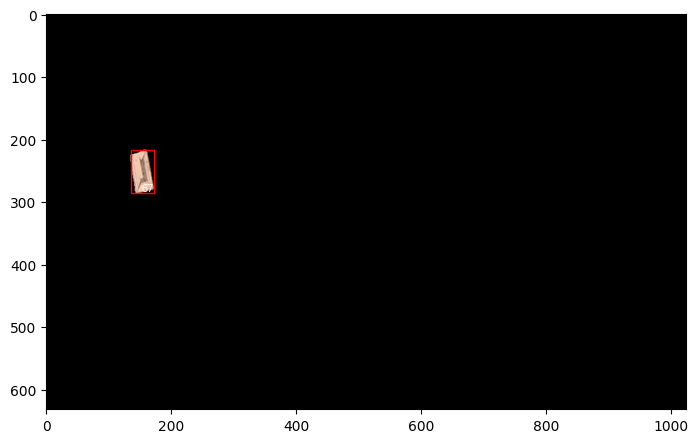

In [60]:
show_def_masks(used_img, sorted_masks,maskIDs=[67])

### (4) Keywords Retrieve

In [27826]:
# keywords = [
#         "rebar mesh", "onsite rebars","concrete surface","gravels path",
#         "concrete road","concrete wall","cement wall","surface wood",
#         "materials rebar","bricks","cement stone","stone",
#         "concrete stone","wooden board","wooden plank","steel beam",
#         "construction material: rebars","onsite worker","feet of worker",
#         "white plastic cloth","black plastic cloth","vehicle:excavator","vehicle:dump truck",
#         "traffic light","unknown region/area","gasoline tank","black wooden beam",
#         "surface: wood","steel plank","excavator bucket","asphalt road",
#         "concrete ground","white barricade: water horse","safety netting",
#         "construction material: wooden beams","construction material: concrete bricks",
#         "construction material: wooden board","electrical machine",
#         "wooden support: plank","construction tool: plank","timber",
#         "construction object: plastic cover","construction component: rebar mesh",
#         "construction structure: steel column","construction tool: white pipe",
#         "construction component: black pipe","construction component: vertical rebar rod",
#         "construction object: steel plank","construction component: column flange plate",
#         "construction component: steel plates"
# ]
# texts = [f"This is a region of '{k}'" for k in keywords]

In [27825]:
# clip_model_names = ["RN50x64","ViT-L-14","convnext_large_d","ViT-L-14-o","sig_large","sig_400m","EVA02-L-14","EVA02-L-14-336"]
# cm = "ViT-L-14"
# cm_func = clip_funcs[cm]

# img_id = #18

# # keywords_root = f"./results/final_keywords/{img_id}.json"
# # with open(keywords_root, "r") as fp:
# #     results = json.load(fp)
# # keywords = results["keywords"]
# # texts = results["texts"]

# pkl_root = f"./results/1. sam_masks/pkl_info/{img_id}.pkl"
# includeTree_root = f"./results/1. sam_masks/includeTree_info/{img_id}.pkl"
# keepNode_root = f"./results/1. sam_masks/keep_node_info/{img_id}.pkl"

# results = getInfoFromFolder(pkl_root=pkl_root, includeTree_root=includeTree_root, keepNode_root=keepNode_root)

# sorted_masks = results["sorted_masks"]
# used_img = results["used_img"]
# includeTree = results["includeTree"]
# updated_tree = results["updated_tree"]
# ancestors_node = results["ancestors_node"]
# children_box_node = results["children_box_node"]

# mask_semantics = { }

# for mask_id in tqdm(ancestors_node+children_box_node, desc=f"Masks ID of {img_id} Image"):
#     roi_image_true = getImageByMasks(used_img, sorted_masks, mask_id, children_segs=[], maskTag=True) # without background
#     roi_image_false = getImageByMasks(used_img, sorted_masks, mask_id, children_segs=[], maskTag=False) # with background
#     roi_image_true = Image.fromarray(roi_image_true)
#     roi_image_false = Image.fromarray(roi_image_false)
#     matching_results = cm_func(roi_image_true, texts, keywords, device = device, clip_name=cm)
#     mask_semantics[mask_id] = matching_results

# mask_semantic_root = f"./results/testImgs/{img_id}.json"
# with open(mask_semantic_root, "w") as fp:
#     json.dump(mask_semantics,fp)

# maskpred = pd.DataFrame(columns=["mask_id", "pred_1", "pred_2", "pred_3", "pred_4", "pred_5"])
# for i, (k, v) in enumerate(mask_semantics.items()):    
#     mask_id = k
#     preds = v["top_labels"]
#     maskpred.loc[i] = [mask_id, *preds]

# maskpred = maskpred.sort_values(by='mask_id')


# keywords_root = f"./results/final_keywords/{img_id}.json"
# with open(keywords_root, "w") as fp:
#     json.dump({
#         "keywords":keywords,
#         "texts":texts
#     }, fp)

# maskpred.to_excel(f"./results/{img_id}_1.xlsx")

In [27827]:
# keywords = [
#         "rebar mesh", "onsite rebars","concrete surface","gravels path",
#         "concrete road","concrete wall","cement wall","surface wood",
#         "materials rebar","bricks","cement stone","stone",
#         "concrete stone","wooden board","wooden plank","steel beam",
#         "construction material: rebars","onsite worker","feet of worker",
#         "white plastic cloth","black plastic cloth","vehicle:excavator","vehicle:dump truck",
#         "traffic light","unknown region/area","gasoline tank","black wooden beam",
#         "surface: wood","steel plank","excavator bucket","asphalt road",
#         "concrete ground","white barricade: water horse","safety netting",
#         "construction material: wooden beams","construction material: concrete bricks",
#         "construction material: wooden board","electrical machine",
#         "wooden support: plank","construction tool: plank","timber",
#         "construction object: plastic cover","construction component: rebar mesh",
#         "construction structure: steel column","construction tool: white pipe",
#         "construction component: black pipe","construction component: vertical rebar rod",
#         "construction object: steel plank","construction component: column flange plate",
#         "construction component: steel plates"
# ]
# texts = [f"This is a region of '{k}'" for k in keywords]

In [27829]:
# #### clip_model_names = ["RN50x64","ViT-L-14","convnext_large_d","ViT-L-14-o","sig_large","sig_400m","EVA02-L-14","EVA02-L-14-336"]
# cm = "ViT-L-14"
# cm_func = clip_funcs[cm]

# # steel board: 47; construction surface concrete ground
# mask_id = 5 # 94

# roi_image_true = getImageByMasks(used_img, sorted_masks, mask_id, children_segs=[], maskTag=True) # without background
# roi_image_false = getImageByMasks(used_img, sorted_masks, mask_id, children_segs=[], maskTag=False) # with background
# roi_image_true = Image.fromarray(roi_image_true)
# roi_image_false = Image.fromarray(roi_image_false)

# # roi_image_true_rz = roi_image_true.resize((224,224))
# # roi_image_false_rz = roi_image_false.resize((224,224))

# matching_results = cm_func(roi_image_true, texts, keywords, device = device, clip_name=cm)
# print(matching_results)

In [27828]:
# 展示图片
# show_def_masks(used_img, sorted_masks,maskIDs=[6,7,8])
# show_def_masks(used_img, sorted_masks,maskIDs=ancestors_node+children_box_node)
# simple_show(used_img,size=(8,6))

In [ ]:
mask_top5_root = f"./results/final_result/{k}/{final_clip_folder[cm]}/excel/{img_id}.xlsx"
maskpred = pd.DataFrame(columns=["mask_id", "pred_1", "pred_2", "pred_3", "pred_4", "pred_5"])
for i, (k2, v2) in enumerate(mask_semantics.items()):    
    mask_id = k2
    preds = v2["top_labels"]
    maskpred.loc[i] = [mask_id, *preds]

maskpred = maskpred.sort_values(by='mask_id')
maskpred.to_excel(mask_top5_root)

In [963]:
left_ID = [11]
for idx in left_ID:
    mask_top5_root = f"./results/testImgs/{idx}.json"
    mask_top5_output = f"./results/{idx}.xlsx"
    maskpred = pd.DataFrame(columns=["mask_id", "pred_1", "pred_2", "pred_3", "pred_4", "pred_5"])
    with open(mask_top5_root,"r") as fp:
        results = json.load(fp)

    for i, (k, v) in enumerate(results.items()):
        mask_id = k
        preds = v["top_labels"]
        maskpred.loc[i] = [mask_id, *preds]
    maskpred = maskpred.sort_values(by="mask_id")
    maskpred.to_excel(mask_top5_output)

In [12]:
img_id = 72
sam_mds = "sam"
sam_model_folder = {
    "sam":"1. sam_masks",
    "sam2":"2. sam2_masks",
    "fastsam":"3. fastsam_masks"
}

clip_model_folder = [
    "1_clip_rn","2_clip_vit",
    "3_openclip_convnext","4_openclip_vit",
    "5_siglip_large","6_siglip_400m",
    "7_evaclip_eva02_l_14","8_evaclip_eva02_l_14_336"
]
outcomes_roots = [
    f"./results/final_result/{sam_mds}/{clip_model_folder[0]}/excel/{img_id}.xlsx",
    # f"./results/final_result/{sam_mds}/{clip_model_folder[1]}/excel/{img_id}.xlsx",
    f"./results/final_result/{sam_mds}/{clip_model_folder[2]}/excel/{img_id}.xlsx",
    f"./results/final_result/{sam_mds}/{clip_model_folder[3]}/excel/{img_id}.xlsx",
    f"./results/final_result/{sam_mds}/{clip_model_folder[4]}/excel/{img_id}.xlsx",
    f"./results/final_result/{sam_mds}/{clip_model_folder[5]}/excel/{img_id}.xlsx",
    f"./results/final_result/{sam_mds}/{clip_model_folder[6]}/excel/{img_id}.xlsx",
    f"./results/final_result/{sam_mds}/{clip_model_folder[7]}/excel/{img_id}.xlsx"
]

# 检测每个每个的结果是否一致
for pth in outcomes_roots:
    data = pd.read_excel(pth)
    print(len(data), end=" ")

25 25 25 25 25 25 25 

In [13]:
pkl_root = f"./results/{sam_model_folder[sam_mds]}/pkl_info/{img_id}.pkl"
includeTree_root = f"./results/{sam_model_folder[sam_mds]}/includeTree_info/{img_id}.pkl"
keepNode_root = f"./results/{sam_model_folder[sam_mds]}/keep_node_info/{img_id}.pkl"

results = getInfoFromFolder(pkl_root=pkl_root, includeTree_root=includeTree_root, keepNode_root=keepNode_root)

sorted_masks = results["sorted_masks"]
used_img = results["used_img"]
includeTree = results["includeTree"]
updated_tree = results["updated_tree"]
ancestors_node = results["ancestors_node"]
children_box_node = results["children_box_node"]

In [14]:
print(sorted(ancestors_node + children_box_node))

[0, 1, 2, 5, 10, 11, 12, 14, 16, 18, 19, 22, 24, 25, 33, 39, 40, 46, 48, 57, 58, 63, 65, 69, 70]


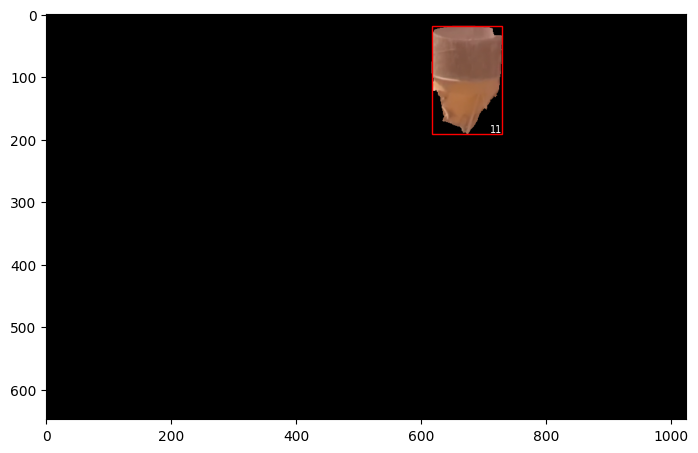

In [15]:
show_def_masks(used_img, sorted_masks,maskIDs=[11])
# 0, 1, 3, 6, 7, 8, 10, 11, 12
# 13, 14, 16, 17, 18, 21, 25
# 28, 47, 53, 63, 64, 66, 72
# 

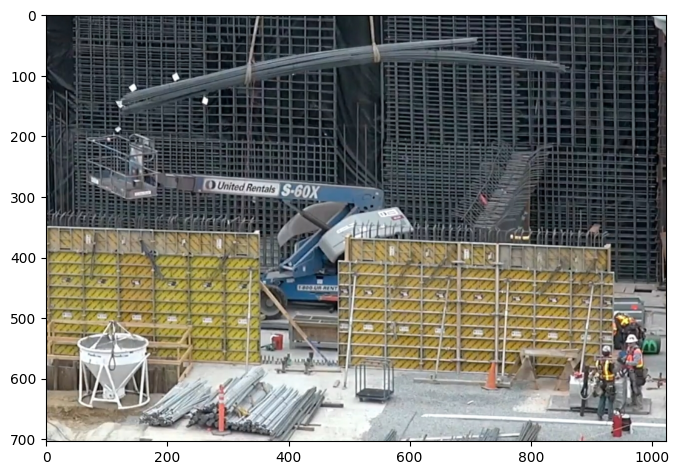

In [1379]:
simple_show(used_img,size=(8,6))